In [417]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import datetime,time
from datetime import datetime,timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
#import optuna

# Chargement des données

In [418]:
def Load_Turb(path):
    return pd.read_csv(path ,sep=';',decimal=',',parse_dates=['DateTime'],dayfirst=True)

csv_path = ['./FRSSO18.csv','./FRMHN11.csv','./FRBRE_E03.csv','./FRHVA_E04.csv','./FRMHN_E06.csv']
Turbs_Raw = [Load_Turb(p) for p in csv_path]         
Turbs = ['Turb1','Turb2','Turb3','Turb4','Turb5']

# Augmentation features

In [419]:
def Augmentation_Features(df):
    df['Year'] = pd.to_datetime(df['DateTime']).dt.year
    df['Month'] = pd.to_datetime(df['DateTime']).dt.month
    df['Day'] = pd.to_datetime(df['DateTime']).dt.day
    df['Hour'] = pd.to_datetime(df['DateTime']).dt.hour
    df['N1'] = (2 * df['ProductionForecast_M'] + df['ProductionForecast_D']) / 3
    df['N2'] = (df['ProductionForecast_M'])**(2/3) * (df['ProductionForecast_D'])**(1/3)
    df['D<M'] = df['ProductionForecast_M'] > df['ProductionForecast_D']
    df['D*M'] = df['ProductionForecast_D'] * df['ProductionForecast_M']
    df['D-M2'] = df['ProductionForecast_D']  - df['ProductionForecast_M']**2 
    df['D2-M'] = df['ProductionForecast_D']**2  - df['ProductionForecast_M']
    return df

In [420]:
Turbs_df = [Augmentation_Features(df) for df in Turbs_Raw]   

In [5]:
Turbs_df[0]

DateTime  ActivePower  ProductionForecast_D  \
0     2020-03-05 00:00:00  1614.345422            948.189357   
1     2020-03-05 01:00:00  1478.355419            967.269962   
2     2020-03-05 02:00:00  1690.147069            948.830677   
3     2020-03-05 03:00:00  1516.965994           1102.870568   
4     2020-03-05 04:00:00   936.617865            962.811666   
...                   ...          ...                   ...   
11673 2021-10-16 14:00:00     0.423586              0.000000   
11674 2021-10-16 16:00:00    33.743984              0.000000   
11675 2021-10-16 17:00:00    66.180937             29.035056   
11676 2021-10-16 22:00:00     3.609505              0.000000   
11677 2021-10-17 01:00:00     2.386485              0.000000   

       ProductionForecast_M  Year  Month  Day  Hour          N1          N2  \
0                     745.2  2020      3    5     0  812.863119  807.508166   
1                     711.8  2020      3    5     1  796.956654  788.414415   
2                     645.0  2020      3    5     2  746.276892  733.560688   
3                     645.0  2020      3    5     3  797.623523  771.284598   
4                     568.8  2020      3    5     4  700.137222  677.881070   
...                     ...   ...    ...  ...   ...         ...         ...   
11673                   0.0  2021     10   16    14    0.000000    0.000000   
11674                   0.0  2021     10   16    16    0.000000    0.000000   
11675                   0.0  2021     10   16    17    9.678352    0.000000   
11676                   4.0  2021     10   16    22    2.666667    0.000000   
11677                   2.0  2021     10   17     1    1.333333    0.000000   

         D<M            D*M           D-M2          D2-M  
0      False  706590.708836 -554374.850643  8.983179e+05  
1      False  688502.758952 -505691.970038  9.348994e+05  
2      False  611995.786665 -415076.169323  8.996347e+05  
3      False  711351.516360 -414922.129432  1.215678e+06  
4      False  547647.275621 -322570.628334  9.264375e+05  
...      ...            ...            ...           ...  
11673  False       0.000000       0.000000  0.000000e+00  
11674  False       0.000000       0.000000  0.000000e+00  
11675  False       0.000000      29.035056  8.430345e+02  
11676   True       0.000000     -16.000000 -4.000000e+00  
11677   True       0.000000      -4.000000 -2.000000e+00  

[11678 rows x 14 columns]

## Préparation train et test

In [421]:
# Si on veut un an de train et le reste de test, quel est l'indice de split dans le dataset? 
# Données Test/Train imposées
datetime_train_start = datetime(2020,3,5,0,0,0)
datetime_train_end    = datetime(2021,3,4,23,0,0)
datetime_test_start = datetime(2021,3,5,0,0,0)
datetime_test_end    = datetime(2021,10,17,0,0,0)

experts_names_df = ['ProductionForecast_D', 'ProductionForecast_M']
truth_name_df = 'ActivePower'

def traindf(df,datetime_train_start,datetime_train_end):
    return df.loc[((df['DateTime']>= datetime_train_start) &  (df['DateTime']<= datetime_train_end))]

def testdf(df,datetime_test_start,datetime_test_end ):
    return df.loc[((df['DateTime']>= datetime_test_start) &  (df['DateTime']<= datetime_test_end))]

def rmse_mae_ref(df, datetime_test_start, datetime_test_end, experts_names_df, truth_name_df):   
       list_experts_df=[]
       metrics =[]
       for exp in experts_names_df:
                list_experts_df.append(df.loc[((df['DateTime']>= datetime_test_start) &  (df['DateTime']<= datetime_test_end)),[exp]])
       
       ref_test_TruePower = df.loc[((df['DateTime']>= datetime_test_start) &  (df['DateTime']<= datetime_test_end)),[truth_name_df]]
       
       for key,exp in enumerate(experts_names_df):
            metrics .append( ( mean_squared_error(ref_test_TruePower, list_experts_df[key],squared=False),mean_absolute_error(ref_test_TruePower, list_experts_df[key])))
    
       
       return [ metrics[k] for k,exp in enumerate(experts_names_df)]

In [422]:
Turbs_train = [traindf(df_t,datetime_train_start,datetime_train_end) for df_t in Turbs_df]
Turbs_test = [testdf(df_t,datetime_test_start,datetime_test_end) for df_t in Turbs_df]                                                                    

In [678]:
reference_metrics = [rmse_mae_ref(turb_df, datetime_test_start+timedelta(hours=12), 
                                  datetime_test_end -timedelta(hours=36), experts_names_df, truth_name_df) for turb_df in Turbs_df]

In [679]:
reference_metrics

[[(330.8023382703106, 219.38783510584267),
  (305.12144800433134, 203.17001507927583)],
 [(483.49098244904707, 321.92349974586335),
  (451.9109686647749, 297.63601180451303)],
 [(241.1123209473823, 168.95157751736335),
  (233.0376073292773, 163.93459062275568)],
 [(252.48182973121996, 164.87242998444364),
  (196.11002010827843, 132.13600214849643)],
 [(533.722949300002, 358.37205114875275),
  (508.1667168518696, 339.66637888877136)]]

# Régression linéaire

In [680]:
features = ['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']

def Lreg(df_Train, df_Test,features, experts_names_df, truth_name_df ):
    
    Lreg_LR = LinearRegression().fit(df_Train[features], df_Train[truth_name_df])
    y_pred = Lreg_LR.predict(df_Test[features])    

    rmse_lreg = mean_squared_error(df_Test[truth_name_df], y_pred,squared=False)
    mae_lreg = mean_absolute_error(df_Test[truth_name_df], y_pred)
    return (rmse_lreg,mae_lreg)

#print('rmse_lreg1 : {}'.format(rmse_lreg1))
#print('mae_lreg1 : {}'.format(mae_lreg1))

In [681]:
Score = [Lreg(df_Train ,df_Test,features, experts_names_df, truth_name_df)  for df_Train,df_Test in zip(Turbs_train,Turbs_test)]

In [682]:
# Référence
for key,i in enumerate(Turbs):
    print(i,reference_metrics[key])

Turb1 [(330.8023382703106, 219.38783510584267), (305.12144800433134, 203.17001507927583)]
Turb2 [(483.49098244904707, 321.92349974586335), (451.9109686647749, 297.63601180451303)]
Turb3 [(241.1123209473823, 168.95157751736335), (233.0376073292773, 163.93459062275568)]
Turb4 [(252.48182973121996, 164.87242998444364), (196.11002010827843, 132.13600214849643)]
Turb5 [(533.722949300002, 358.37205114875275), (508.1667168518696, 339.66637888877136)]


## N1 = Moyenne pondérée des experts : exemple (2M+D)/3

In [431]:
experts_names = ['ProductionForecast_D', 'ProductionForecast_M']
alpha = [1/3]

def N_pred(df,t1, t2, experts_names, alpha, truth_name_df):
    list_experts=[]
    nb_alpha = len(alpha)
    dg= alpha[0]*df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)),experts_names[0]]
    for key,exp in enumerate(experts_names[1:-1]):
        dg = dg +(alpha[key]*df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)),experts_names[key]])
    dg = dg + (1 - np.array(alpha).sum()) * df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)), experts_names_df[-1]] 
    ref_test_TruePower = df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)),[truth_name_df]]
       
    return (mean_squared_error(ref_test_TruePower, dg,squared=False),mean_absolute_error(ref_test_TruePower, dg))

In [432]:
print ('New expert (weighted mean):', alpha, 1-np.array(alpha).sum(),' for ', experts_names)
for key,df in enumerate(Turbs_df):
    print(Turbs[key],N_pred(df,datetime_test_start, datetime_test_end, experts_names, alpha, truth_name_df))


New expert (weighted mean): [0.3333333333333333] 0.6666666666666667  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (292.57538106835364, 195.53770539018996)
Turb2 (425.9110752387927, 284.22362220833946)
Turb3 (220.50787297519236, 154.1772871341506)
Turb4 (194.82792555247002, 130.69795325606327)
Turb5 (485.45662428350465, 327.41050552487394)


## Nalpha =alpha * exp1 +  alpha2 * exp2 +....(1- (alpha+ alpha2+...))* expN

In [ ]:
# N(alpha) min for rmse/mae by Turbs 

In [433]:
alphas = np.arange(0.1,1.0,0.01)

for alpha in alphas:
    print ('New expert (weighted mean):', alpha, 1-np.array(alpha).sum(),' for ', experts_names)
    turbs_rmse = []
    turbs_mae = []
    for key,df in enumerate(Turbs_df):
        print(Turbs[key],N_pred(df,datetime_train_start, datetime_train_end, experts_names, [alpha], truth_name_df))
        
        

New expert (weighted mean): 0.1 0.9  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (341.46793444015657, 226.63743918313952)
Turb2 (511.95188585794153, 338.804655426597)
Turb3 (248.23454068220283, 173.05195933739773)
Turb4 (263.9823651426661, 179.5462163379482)
Turb5 (568.8795584687655, 379.93663606266756)
New expert (weighted mean): 0.11 0.89  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (340.9703346177282, 226.29628248834413)
Turb2 (511.2554496590014, 338.4451393837774)
Turb3 (247.49020188788162, 172.45301403891324)
Turb4 (263.66477252657353, 179.36487457243354)
Turb5 (568.2564640467579, 379.60253504150546)
New expert (weighted mean): 0.12 0.88  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (340.48729510087423, 225.9634437784939)
Turb2 (510.5910587910443, 338.1064562920202)
Turb3 (246.76930861315614, 171.8712686157964)
Turb4 (263.3712280895007, 179.19694743673486)
Turb5 (567.6631795271167, 379.2864816443032)
New expert (weighted mean): 0.13 0

Turb5 (563.1445180883225, 378.84209931786006)
New expert (weighted mean): 0.3999999999999998 0.6000000000000002  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (333.07859616776517, 220.53208962802776)
Turb2 (505.3447239165399, 337.49239766750827)
Turb3 (236.7827073917615, 165.07885067353888)
Turb4 (265.0605888274751, 181.37834357068604)
Turb5 (563.4067560348964, 379.09742397644436)
New expert (weighted mean): 0.4099999999999998 0.5900000000000002  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (333.0376494965105, 220.48513420937394)
Turb2 (505.63967954168504, 337.76909566473824)
Turb3 (236.80672998436384, 165.1408352619108)
Turb4 (265.4723891028698, 181.67498172720627)
Turb5 (563.6995802829786, 379.3646073322691)
New expert (weighted mean): 0.4199999999999998 0.5800000000000002  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (333.0123285052938, 220.44914837460894)
Turb2 (505.9677600426326, 338.0698196537732)
Turb3 (236.85751626687457, 165.22456923

Turb3 (248.07976923151514, 174.57572590805665)
Turb4 (286.037410999297, 196.63751258226074)
Turb5 (583.9982852037905, 394.5583875664052)
New expert (weighted mean): 0.6999999999999996 0.3000000000000004  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (338.60231800231077, 223.4038479672724)
Turb2 (528.1814758899994, 354.11079388250926)
Turb3 (248.84258870073032, 175.12492060116443)
Turb4 (287.06977589104383, 197.38396013827148)
Turb5 (585.1393071670527, 395.36970066914677)
New expert (weighted mean): 0.7099999999999996 0.29000000000000037  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (339.0229497131164, 223.6474357692862)
Turb2 (529.419173410145, 354.9397633859382)
Turb3 (249.6284735375962, 175.6881736273394)
Turb4 (288.12077383936696, 198.14451973802085)
Turb5 (586.3076325918959, 396.19869821069994)
New expert (weighted mean): 0.7199999999999996 0.28000000000000036  for  ['ProductionForecast_D', 'ProductionForecast_M']
Turb1 (339.45839407077904, 223.90019132

Turb5 (629.3916597263044, 425.8619615124442)


RMSE Turb1 0.3599999999999999 292.5160832034247
MAE Turb1 0.33999999999999986 195.52798700672813
RMSE Turb2 0.3999999999999998 425.2428000075699
MAE Turb2 0.3699999999999999 284.0842865754943
RMSE Turb3 0.43999999999999984 219.74771572194726
MAE Turb3 0.45999999999999985 153.36980012479322
RMSE Turb4 0.17999999999999997 192.4175210179158
MAE Turb4 0.19999999999999996 129.6055640570786
RMSE Turb5 0.3999999999999998 484.7731096447033
MAE Turb5 0.3699999999999999 327.2413768817391


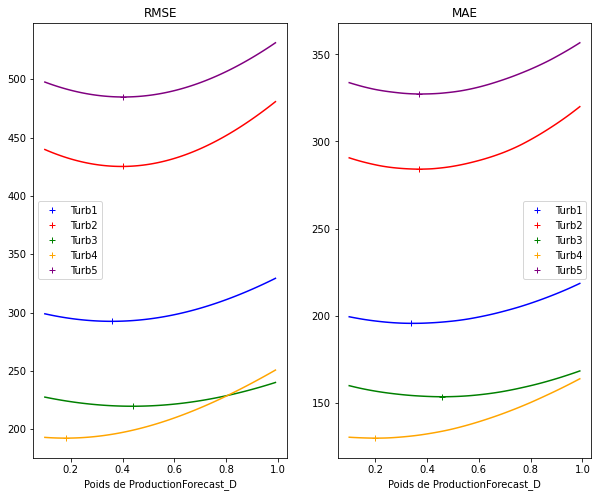

In [434]:
colors =['blue', 'red', 'green', 'orange', 'purple']
turbs_alphas_rmse = {}
turbs_alphas_mae =  {}
for key,df in enumerate(Turbs_df):
    rmse = []
    mae =  []
    for alpha in alphas:
        rmse.append(N_pred(df,datetime_test_start, datetime_test_end, experts_names, [alpha], truth_name_df)[0])
        mae.append(N_pred(df,datetime_test_start, datetime_test_end, experts_names, [alpha], truth_name_df)[1])
    turbs_alphas_rmse[key]= rmse
    turbs_alphas_mae[key]= mae   
fig, ax= plt.subplots(1,2,figsize=(10,8))
for i,turb in enumerate(Turbs) :  
    ax[0].plot(alphas,turbs_alphas_rmse[i], color=colors[i])
    ax[0].plot(alphas[np.argmin(turbs_alphas_rmse[i])],turbs_alphas_rmse[i][np.argmin(turbs_alphas_rmse[i])] , '+', color= colors[i] , label=Turbs[i])
    ax[0].set_xlabel('Poids de '+ experts_names[0]) 
    ax[0].set_title('RMSE') 
    print('RMSE',Turbs[i],alphas[np.argmin(turbs_alphas_rmse[i])],turbs_alphas_rmse[i][np.argmin(turbs_alphas_rmse[i])])
    
    ax[0].legend()
    ax[1].plot(alphas,turbs_alphas_mae[i], color= colors[i])
    ax[1].plot(alphas[np.argmin(turbs_alphas_mae[i])],turbs_alphas_mae[i][np.argmin(turbs_alphas_mae[i])] , '+' , color= colors[i], label=Turbs[i])
    ax[1].set_xlabel('Poids de '+ experts_names[0])
    ax[1].set_title('MAE')
    ax[1].legend()
    print('MAE',Turbs[i],alphas[np.argmin(turbs_alphas_mae[i])],turbs_alphas_mae[i][np.argmin(turbs_alphas_mae[i])])
    

In [435]:
def alpha_auto( df,t1, t2, experts_names, truth_name_df):
    rmse = []
    mae =  []
    alphas = np.arange(0.1,1.0,0.01)
    
    for alpha in alphas:
        rmse.append(N_pred(df,t1, t2, experts_names, [alpha], truth_name_df)[0])
        mae.append(N_pred(df,t1, t2, experts_names, [alpha], truth_name_df)[1])
    return alphas[np.argmin(rmse)], alphas[np.argmin(mae)]

In [436]:
alpha_auto(Turbs_df[0],datetime_train_start, datetime_train_end, experts_names, truth_name_df)

(0.4299999999999998, 0.45999999999999985)

## Moyenne Nalpha et régression linéaire

In [437]:
def Lreg_N(df_Train, df_Test,datetime_test_start, datetime_test_end,features, experts_names_df, truth_name_df ):
    Lreg_LR = LinearRegression().fit(df_Train[features], df_Train[truth_name_df])
    y_pred = Lreg_LR.predict(df_Test[features])
    
    alpha = alpha_auto(df_Train,datetime_train_start, datetime_train_end, experts_names_df, truth_name_df)
    dg = alpha[0]*df_Test.loc[:,experts_names_df[0]] #alpha[0]
    for key,exp in enumerate(experts_names_df[1:-1]):
        print('Plusieurs experts')
        dg = dg +(alpha[key]*df_Test.loc[:,experts_names_df[key]])
    dg = dg + (1 - np.sum(alpha)) * df_Test.loc[:, experts_names_df[-1]]

    df_mean_LREG_N = (y_pred + dg) / 2
    rmse_lreg = mean_squared_error(df_Test[truth_name_df], df_mean_LREG_N,squared=False)
    mae_lreg = mean_absolute_error(df_Test[truth_name_df], df_mean_LREG_N)
    
    return (rmse_lreg,mae_lreg)


In [438]:
Score_Mean_Lreg_N = [Lreg_N(df_Train,df_Test,datetime_test_start, datetime_test_end,features,
                    experts_names_df, truth_name_df)  for df_Train,df_Test in zip(Turbs_train,Turbs_test)]

In [439]:
Score_Mean_Lreg_N

[(321.3363531066681, 218.7677829841351),
 (438.8703357753812, 297.05208468736663),
 (236.22697605041347, 164.26504605558324),
 (188.50527152453668, 126.77482372650003),
 (483.07369499996327, 331.95773718478097)]

Conclusion : Il n'y a pas de généralisation entre l'égalité du coefficient de pondération idéal (Moyenne(LREG/Pondération Expert) entre le test et le train. Il faut donc adapter alpha au cours du temps, et notamment en fonction de la profondeur de la régression. L'approche Online est un cadre plus adapté à cette démarche.

# Online

In [587]:
date_db= datetime(2021,3,5,12,0,0)
date_fin = datetime(2021,10,17,0,0,0)-timedelta(hours=36)

def Online_Ref(date_deb,date_fin, df,expert, truth_name): 
    #metrics.append( ( mean_squared_error(ref_test_TruePower, list_experts_df[key],squared=False),mean_absolute_error(ref_test_TruePower, list_experts_df[key])))
    smae = 0
    srmse = 0
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12)) &  (df['DateTime']< dte+timedelta(hours=36))),[expert]]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12)) &  (df['DateTime']< dte+timedelta(hours=36))),[truth_name]]
        
        smae += np.sum(np.absolute(y_test.values - x_test.values))
        srmse += np.sum((y_test.values - x_test.values)**2)
        l += len(y_test)
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    return rmse,mae

In [588]:
Score_Online_RefD = [Online_Ref(date_db,date_fin,df,'ProductionForecast_D','ActivePower')  for df in Turbs_df]

In [589]:
Score_Online_RefD

[(329.9783972805106, 218.51601374087804),
 (482.61676350418844, 320.8650451213818),
 (241.14280909804663, 168.8870317343757),
 (252.44545017863095, 164.65406700211537),
 (533.1448368254779, 357.634842384024)]

In [591]:
Score_Online_RefM = [Online_Ref(date_db,date_fin,df,'ProductionForecast_M','ActivePower')  for df in Turbs_df]

In [592]:
Score_Online_RefM

[(303.7563198906642, 202.00988375295003),
 (451.41624164882217, 296.94350887223214),
 (232.90603512593412, 163.78782046026066),
 (196.0134088182459, 131.90884727034035),
 (507.48998688325185, 338.7171776222528)]

In [597]:
date_db= datetime(2021,3,5,12,0,0)
date_fin = datetime(2021,10,17,0,0,0)-timedelta(hours=36)
p=105

def Online_Reg(date_deb, date_fin, df, p, features,truth): 
    smae = 0
    srmse = 0
    y_pred_list = []
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin: #date_deb+timedelta(hours=72): 
        #print(i, dte)
        x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),features]
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),features]
        y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),[truth]]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[truth]].values
        reg = LinearRegression().fit(x_train, y_train)
        try :   
            y_pred= reg.predict(x_test)
            #print(y_test)
        except:
            print("Pas de data",i)
            pass
        if len(x_test)!=0:
            smae += np.sum(np.absolute(y_test - y_pred))
            srmse += np.sum((y_test - y_pred)**2)
            l += len(y_test)
            y_pred_list.append(y_pred)
        
        i+=1
        dte = dte+timedelta(hours=24)
    if l!=0:    
        mae = smae/l
        rmse = np.sqrt(srmse/l)
    else : 
        return (np.inf,np.inf)
    return (rmse,mae)

def Online_reg_N(date_deb, date_fin, df, p , features,truth,alpha, experts): 
    smae = 0
    srmse = 0
    y_pred_list = []
    dte = date_deb
    l=0
    i=0
    while dte<= date_fin:
        #print(i, dte)
        x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),features]
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),features]
        y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),[truth]]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[truth]]
        N_test = alpha*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[expert[0]]]
        N_test = N_test + (1-alpha)*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[expert[1]]]
        reg = LinearRegression().fit(x_train, y_train)
        try :   
            y_pred= (reg.predict(x_test)+N_test)/2
        except:
            #print("Pas de data",i)
            pass
        if len(x_test)!=0:
            smae += np.sum(np.absolute(y_test - y_pred))
            srmse += np.sum((y_test - y_pred)**2)
            l += len(y_test)
            y_pred_list.append(y_pred)
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = smae/l
    rmse = np.sqrt(srmse/l)
    return rmse,mae
    


In [586]:
Score_Online_Reg = [Online_Reg(date_db, date_fin,df,p, features,truth_name_df) for df in Turbs_df]

In [445]:
Score_Online_Reg


[(286.81276066151975, 201.21730446483085),
 (424.69245575217127, 292.7531272779197),
 (214.64034204688355, 151.88134769564016),
 (193.97853905295912, 133.53370697798644),
 (473.85519298848556, 332.23032245976947)]

In [142]:
test_p = list(range(20,150,1))

In [198]:
seek_p=[]
for p in test_p:
    seek_p.append(Online_Reg(date_db,date_fin,Turbs_df[4],p, features,truth_name_df))


profondeur Ideale RMSE :  105 473.85519298848556 MAE 332.23032245976947
profondeur Ideale MAE :  81 332.03209179243123 RMSE 474.67706392540714


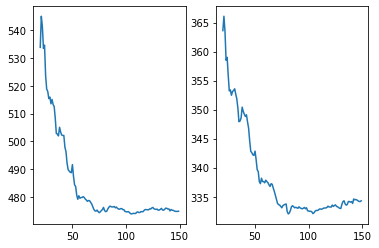

In [199]:
fig,ax = plt.subplots(1,2)
rmse_seek_p = [p[0] for p in seek_p]
rmae_seek_p = [p[1] for p in seek_p]

ax[0].plot(test_p,rmse_seek_p,  )
ax[1].plot(test_p,rmae_seek_p, )

print('profondeur Ideale RMSE : ',test_p[np.argmin(rmse_seek_p)],seek_p[np.argmin(rmse_seek_p)][0],'MAE',seek_p[np.argmin(rmse_seek_p)][1] )
print('profondeur Ideale MAE : ',test_p[np.argmin(rmae_seek_p)],seek_p[np.argmin(rmae_seek_p)][1],'RMSE',seek_p[np.argmin(rmae_seek_p)][0] )





### Stratégie de mise à jour de la profondeur :
- On considère la profondeur idéale uniquement sur le train (qui peut avancer avec le temps online)
- mise à jour la profondeur sur Train avec un test de 3 semaines pour la minimisation des critères rmse/mae (recherche entre p =50,250 par rapport à la référence M et D
- mise à jour tous les mois

((283.8627578131128, 199.50291018260268),
 230,
 (283.8887545567054, 199.48410530422996),
 225)

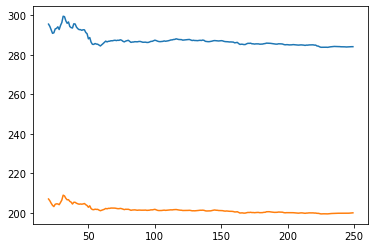

In [504]:
date_debut_train= datetime(2021,3,5,12,0,0)
date_periode_test = datetime(2021,10,17,0,0,0) - timedelta(hours=36) 

# Calcul de p sur train. 
date_train_initiale = datetime(2020,3,5,0,0,0) 

def find_best_p_reg(date_debut, date_fin, df , features,truth, plot=False):
    p_search =  list(range(20,250,1))
    seek_p=[]
    for p in p_search:
        seek_p.append(Online_Reg(date_debut,date_fin,df,p, features,truth_name_df))
       # print('valeur pour : ',p,  ' Datedébut :', date -timedelta(hours=24*p),' au', date)
    rmse_seek_p = [p[0] for p in seek_p]
    rmae_seek_p = [p[1] for p in seek_p]   
    
    if plot==True:
        
       plt.plot(p_search, rmse_seek_p)
       plt.plot(p_search, rmae_seek_p)

    
    
    return (seek_p[np.argmin(rmse_seek_p)],p_search[np.argmin(rmse_seek_p)],seek_p[np.argmin(rmae_seek_p)],p_search[np.argmin(rmae_seek_p)])
find_best_p_reg(date_debut_train,date_periode_test,Turbs_df[0],features,'ActivePower',True)     


In [207]:
date_debut_train= datetime(2021,3,5,12,0,0)
date_debut_train_encours = date_debut_train
date_fin_train = datetime(2021,10,17,0,0,0)-timedelta(hours=36)

In [ ]:
# Active power est connu jusqu'à date_debut_train
# Calcul sur les trois dernières semaines de la profondeur idéale qui maximise le gain pour un type de regression donnée

In [507]:
p_eval =100
date_deb_periode_testp = datetime(2021,3,5,0,0,0) -timedelta(weeks=1)
date_fin_periode_testp = datetime(2021,3,5,0,0,0)


In [601]:
def find_best_p_reg_min( date_dTest, date_fTest, func, df ,experts, features, truth, plot=False):
    p_search =  list(range(50,250,5))
    seek_p=[]
    ref_p ={}
    for exp in experts:
        ref_p[exp]= Online_Ref(date_dTest,date_fTest, df,exp, truth) 
         
    for p in p_search:
        #print('Debut=',date_dTest)
        #print('Fin=',date_fTest, ' p=',p)
        seek_p.append(func( date_dTest,date_fTest,df, p,features,truth_name_df))
        
       # print('valeur pour : ',p,  ' Datedébut :', date -timedelta(hours=24*p),' au', date)
        
    rmse_seek_p = [p[0] for p in seek_p]
    rmae_seek_p = [p[1] for p in seek_p]   
    
    if plot==True:
       plt.plot(p_search, rmse_seek_p)
       plt.plot(p_search, rmae_seek_p)
    print((rmse_seek_p[np.argmin(rmse_seek_p)],p_search[np.argmin(rmse_seek_p)],
           rmae_seek_p[np.argmin(rmae_seek_p)],p_search[np.argmin(rmae_seek_p)], ref_p))
    return p_search[np.argmin(rmse_seek_p)]
           

(293.1761127343236, 100, 228.34086588898674, 111, {'ProductionForecast_D': (335.3335937826132, 248.07774698462237), 'ProductionForecast_M': (429.81138254534903, 317.9556341503532)})


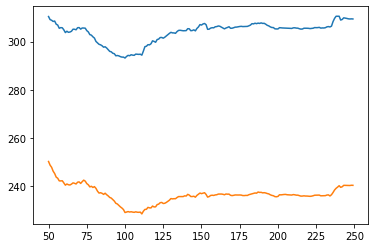

In [509]:
p_min=find_best_p_reg_min(date_deb_periode_testp,date_fin_periode_testp, Online_Reg, Turbs_df[0], 
                    experts_names, features,'ActivePower', plot = True)

In [397]:
def find_best_alpha_p (t1, t2,  df ,experts, truth):
    alphas =   np.arange(0.05,0.95,0.01)
    dgs =[]
    ref_test_TruePower = df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)),[truth]]
    for alpha in alphas:
        dg= alpha*df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)),experts_names[0]]
        dg = dg + (1 - alpha) * df.loc[((df['DateTime']>= t1) &  (df['DateTime']<= t2)), experts_names_df[1]] 
        dgs.append((mean_squared_error(ref_test_TruePower, dg,squared=False),mean_absolute_error(ref_test_TruePower, dg)))
    rmse_alpha = [p[0] for p in dgs] 
    
    rmae_apha = [p[1] for p in dgs] 
    alpha_min = np.argmin(rmse_alpha)
       
    return alphas[alpha_min]

In [510]:
find_best_alpha_p(date_debut_train - timedelta(hours=p_min*24),date_debut_train,Turbs_df[0],experts_names,'ActivePower')


0.5500000000000002

In [ ]:
# Procédure Online
# à date : prévisions 36h avec p et alpha
# mise à jour p à (date + p/2), mise à jour alpha pour ce nouveau p

In [578]:
def pred_online(dte_deb_ol, dte_fin_ol, df, experts, truth,features, nb_weeks=2 , days_upd_alphap=5, export_preds=False):
    # détermination p et alpha initial
    dte= dte_deb_ol
    dte_deb = dte_deb_ol-timedelta(nb_weeks)
    p_min=find_best_p_reg_min(dte_deb, dte, Online_Reg, df, 
                    experts_names, features,truth, plot = False)
    print('initial p=', p_min)
    alpha_min = find_best_alpha_p(dte_deb_ol - timedelta(hours=p_min*24), dte_deb_ol, df, experts, truth)
    smae = [0,0,0] #reg, reg+pond, pond
    srmse = [0,0,0]
    y_pred_list = []
    dte_newp = dte +timedelta(hours = min(24*days_upd_alphap,24*int(p_min/5)))
    l=0
    i=0
    p= p_min
    alpha= alpha_min
    df_preds=pd.DataFrame()
    
    while dte<= dte_fin_ol:
        
        if dte>=dte_newp:
            print('mise à jour p,alpha à', dte)
            dte_deb = dte - timedelta(nb_weeks)
            p_min=find_best_p_reg_min(dte_deb, dte, Online_Reg, df, 
                    experts_names, features, truth, plot = False)
            alpha_min = find_best_alpha_p(dte - timedelta(hours=p_min*24), dte, df, experts,truth)
            print('p=',p_min,' alpha=',alpha_min)
            p= p_min
            alpha= alpha_min
            dte_newp = dte +timedelta(hours = min(24*days_upd_alphap,24*int(p_min/5))) #24*int(p_min/5))
            
        #print(i, dte)
        x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),features]
        x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                         , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),features]
        y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),[truth]]
        y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[truth]].values
        N_test = alpha*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[0]]].values
        N_test = N_test + (1-alpha)*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[1]]].values
        reg = LinearRegression().fit(x_train, y_train)
        try :   
            y_pred= [reg.predict(x_test),(reg.predict(x_test)+N_test)/2,N_test]
            #print(y_pred)
        except:
            print("Pas de data",i)
            pass
            
        if len(x_test)!=0:
                smae = np.add(smae,np.array([np.sum(np.absolute(y_test - y_pred[0])),
                                             np.sum(np.absolute(y_test - y_pred[1])),np.sum(np.absolute(y_test - y_pred[2]))]))
                srmse = np.add(srmse,np.array([np.sum((y_test - y_pred[0])**2),np.sum((y_test - y_pred[1])**2),np.sum((y_test - y_pred[2])**2)]))
                l += len(y_test)
                y_pred_list.append(y_pred)
                
                if dte>=dte_newp:
                    print('mise à jour p,alpha à', dte)
                    dte_deb = dte - timedelta(nb_weeks)
                    p_min=find_best_p_reg_min(dte_deb, dte, Online_Reg, df, 
                            experts_names, features, truth, plot = False)
                    alpha_min = find_best_alpha_p(dte - timedelta(hours=p_min*24), dte, df, experts,truth)
                    print('p=',p_min,' alpha=',alpha_min)
                    p= p_min
                    alpha= alpha_min
                    dte_newp = dte +timedelta(hours = min(24*days_upd_alphap,24*int(p_min/5))) #24*int(p_min/5))
                
                if export_preds==True:
                    df_pred = df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['DateTime']]
                    df_pred['ActivePower']=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['ActivePower']]
                    df_pred[experts[0]]=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[0]]]
                    df_pred[experts[1]]=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[1]]]
                    
                    df_pred=df_pred.reset_index().drop(columns=['index'])
                    df_pred['reg'] = y_pred[0]
                    df_pred['reg+pond'] = y_pred[1]
                    df_pred['pond'] = y_pred[2]
                    df_preds=pd.concat([df_preds,df_pred],ignore_index = True)
                
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = np.array(smae)/l
    srmse = np.array(srmse)
    rmse = np.sqrt(srmse/l)
    if export_preds== True:
        return rmse,mae,df_preds
    else:
        return rmse,mae,l
    


In [541]:
result = pred_online(date_debut_train, date_fin_train, Turbs_df[0], experts_names, 'ActivePower',features)

(298.7179539951913, 95, 245.07603895341168, 95, {'ProductionForecast_D': (373.4470034081541, 300.8197617917121), 'ProductionForecast_M': (457.0940662773384, 367.7014408933654)})
initial p= 95
mise à jour p,alpha à 2021-03-24 12:00:00
(147.83117434594186, 140, 106.76605827706696, 140, {'ProductionForecast_D': (134.83403261227838, 88.95185120442784), 'ProductionForecast_M': (98.28059211964839, 70.18432874184475)})
p= 140  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-03-25 12:00:00
(306.255935099976, 175, 214.65380088606008, 180, {'ProductionForecast_D': (306.4221200502567, 195.9179567322554), 'ProductionForecast_M': (216.75530544758396, 151.90489518224368)})
p= 175  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-03-26 12:00:00
(329.1809270796264, 210, 248.02289294722985, 200, {'ProductionForecast_D': (343.0285176277769, 255.3950893498469), 'ProductionForecast_M': (295.6660177654289, 234.9035556082451)})
p= 210  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-03-27 12

p= 50  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-04-25 12:00:00
(239.95596713667453, 50, 181.02833608310758, 50, {'ProductionForecast_D': (274.16786068694745, 213.9397840274728), 'ProductionForecast_M': (307.6721104682547, 242.37532414517347)})
p= 50  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-04-26 12:00:00
(261.04367629990395, 50, 198.70319029649687, 50, {'ProductionForecast_D': (288.59796243688254, 224.8588461561211), 'ProductionForecast_M': (309.1186801508813, 239.10942558680836)})
p= 50  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-04-27 12:00:00
(361.26621779183455, 50, 211.18583442914746, 50, {'ProductionForecast_D': (374.28167368328536, 221.74005558302662), 'ProductionForecast_M': (372.18056591709814, 219.27913441329218)})
p= 50  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-04-28 12:00:00
(426.9794233698252, 50, 273.67115313742335, 50, {'ProductionForecast_D': (410.37755383594083, 255.59214921569284), 'ProductionForecast_M': (448.75251582

p= 195  alpha= 0.5200000000000001
mise à jour p,alpha à 2021-05-27 12:00:00
(184.0011853255436, 50, 124.00183025785665, 50, {'ProductionForecast_D': (262.489817490671, 150.99922769238512), 'ProductionForecast_M': (233.697780831466, 158.09392259675698)})
p= 50  alpha= 0.5600000000000002
mise à jour p,alpha à 2021-05-28 12:00:00
(194.68315137292475, 50, 126.30834180525201, 50, {'ProductionForecast_D': (187.20419026356475, 117.36514224808677), 'ProductionForecast_M': (207.42348205650677, 147.73356793969472)})
p= 50  alpha= 0.5500000000000002
mise à jour p,alpha à 2021-05-29 12:00:00
(280.61552391366695, 115, 185.03308984109594, 50, {'ProductionForecast_D': (286.7356716231606, 188.39249620195656), 'ProductionForecast_M': (332.37326097067336, 224.5370827312411)})
p= 115  alpha= 0.5500000000000002
mise à jour p,alpha à 2021-05-30 12:00:00
(290.38905156665123, 60, 206.72023732049445, 55, {'ProductionForecast_D': (294.64642879348196, 206.62186957872254), 'ProductionForecast_M': (364.9414354874

p= 115  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-06-28 12:00:00
(108.05962502662732, 60, 84.82255441664762, 55, {'ProductionForecast_D': (141.8720790013677, 96.47600991085129), 'ProductionForecast_M': (92.75548743390002, 70.92431012261538)})
p= 60  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-06-29 12:00:00
(143.40424325684936, 50, 117.04348861612002, 55, {'ProductionForecast_D': (196.03875493900077, 149.13058704073583), 'ProductionForecast_M': (139.9027620206813, 111.07598485750448)})
p= 50  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-06-30 12:00:00
(137.55183468436766, 50, 109.69152160979759, 50, {'ProductionForecast_D': (187.48297804421807, 139.88670624805366), 'ProductionForecast_M': (141.71357105383672, 110.24346651543024)})
p= 50  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-07-01 12:00:00
(128.23574031439804, 210, 97.75628252634553, 210, {'ProductionForecast_D': (177.54752749669075, 128.91928814642057), 'ProductionForecast_M': (151.7152708

p= 60  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-07-30 12:00:00
(292.1858391086925, 220, 205.21986277256815, 60, {'ProductionForecast_D': (386.126849180189, 264.1115997994096), 'ProductionForecast_M': (316.0627538505707, 225.60575635253684)})
p= 220  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-07-31 12:00:00
(275.26763087673896, 240, 195.43335969461435, 220, {'ProductionForecast_D': (376.0509366751601, 251.3545450300566), 'ProductionForecast_M': (311.35642762661956, 211.15459764305655)})
p= 240  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-08-01 12:00:00
(203.42914195904038, 70, 145.30648955601765, 140, {'ProductionForecast_D': (248.8355043586445, 166.05156364974636), 'ProductionForecast_M': (219.74637696313306, 147.85443816430416)})
p= 70  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-08-02 12:00:00
(208.98167918318856, 120, 155.6048717863485, 120, {'ProductionForecast_D': (245.55314738539516, 166.70355600960409), 'ProductionForecast_M': (223.99277

(271.6582418699458, 235, 216.83518655192233, 235, {'ProductionForecast_D': (351.9926510687286, 271.43571315892063), 'ProductionForecast_M': (376.4013080128255, 299.9624381619384)})
p= 235  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-01 12:00:00
(260.91448583689845, 235, 204.5935625574956, 235, {'ProductionForecast_D': (323.1098125362079, 245.1088328027945), 'ProductionForecast_M': (371.2955887932324, 295.7268075979055)})
p= 235  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-02 12:00:00
(224.15267620584595, 235, 168.01266232735418, 225, {'ProductionForecast_D': (284.57583969421825, 205.51566314776107), 'ProductionForecast_M': (321.7620990690929, 240.8798828179988)})
p= 235  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-03 12:00:00
(152.61763341826628, 245, 104.17219635991857, 245, {'ProductionForecast_D': (193.80929913315754, 137.12145696787246), 'ProductionForecast_M': (212.19203768100044, 143.23677478615508)})
p= 245  alpha= 0.39000000000000007
mise 

p= 175  alpha= 0.33
mise à jour p,alpha à 2021-10-03 12:00:00
(229.62522254555242, 180, 179.87328272069445, 180, {'ProductionForecast_D': (279.31150859395945, 201.9367328888948), 'ProductionForecast_M': (185.50073457454786, 144.72608294400712)})
p= 180  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-10-04 12:00:00
(348.4960036080126, 225, 275.4364349071738, 225, {'ProductionForecast_D': (366.2245550541663, 268.12556116299487), 'ProductionForecast_M': (388.7869631900222, 257.2587117780202)})
p= 225  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-10-05 12:00:00
(383.57547960628966, 225, 318.5177776114917, 225, {'ProductionForecast_D': (380.71256961429873, 290.0370015031181), 'ProductionForecast_M': (412.31108170030166, 294.63679487218184)})
p= 225  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-10-06 12:00:00
(305.12118811478115, 225, 212.2525743163156, 225, {'ProductionForecast_D': (299.4538768167962, 186.87774797243762), 'ProductionForecast_M': (336.06587984395094,

In [542]:
result

(array([275.94502511, 278.82491871, 290.39038626]),
 array([194.30774621, 190.72019735, 193.84899933]),
                 DateTime  ActivePower  ProductionForecast_D  \
 0    2021-03-06 00:00:00  1609.287954            808.297777   
 1    2021-03-06 01:00:00  1678.770945            842.445216   
 2    2021-03-06 02:00:00  1498.393694            867.448126   
 3    2021-03-06 03:00:00  1199.045645            842.374947   
 4    2021-03-06 04:00:00   768.609846            845.279023   
 ...                  ...          ...                   ...   
 4372 2021-10-13 18:00:00    29.990351             20.257808   
 4373 2021-10-16 14:00:00     0.423586              0.000000   
 4374 2021-10-16 16:00:00    33.743984              0.000000   
 4375 2021-10-16 17:00:00    66.180937             29.035056   
 4376 2021-10-16 22:00:00     3.609505              0.000000   
 
       ProductionForecast_M          reg    reg+pond        pond  
 0                    645.0   910.357868  822.585822  734.8

In [622]:
#influence de délais de mise à jour de p et alpha, sachant que le délai ne sera pas supérieur à p/5 depuis la dernière maj
days =[1,2,3,4,5,10,15,20,25,30]
res=[]
for day in days:
   res.append(pred_online(date_debut_train, date_fin_train, Turbs_df[4], experts_names,  'ActivePower',features, days_upd_alphap=day))
    
    

(474.58012451380097, 50, 362.4906207555801, 50, {'ProductionForecast_D': (573.5938873784676, 451.720901269027), 'ProductionForecast_M': (675.8529149857853, 563.3607483369505)})
initial p= 50
mise à jour p,alpha à 2021-03-06 12:00:00
(458.9527333340357, 50, 349.52658725562605, 50, {'ProductionForecast_D': (527.9914479874723, 387.50536025180173), 'ProductionForecast_M': (624.7014534568112, 491.54392984059393)})
p= 50  alpha= 0.28
mise à jour p,alpha à 2021-03-07 12:00:00
(455.1915850221384, 50, 337.0649086443603, 50, {'ProductionForecast_D': (485.01492993693773, 340.2266279085793), 'ProductionForecast_M': (593.2517772480566, 426.9135746372972)})
p= 50  alpha= 0.29000000000000004
mise à jour p,alpha à 2021-03-08 12:00:00
(227.60641631250047, 165, 184.72158722980532, 120, {'ProductionForecast_D': (229.09291103195267, 185.1657307212104), 'ProductionForecast_M': (215.03441881162001, 174.2795983228478)})
p= 165  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-03-09 12:00:00
(303.9178925

p= 245  alpha= 0.32000000000000006
mise à jour p,alpha à 2021-04-07 12:00:00
(577.0775458926238, 245, 416.68521960079573, 195, {'ProductionForecast_D': (522.9035315806846, 362.7855001656078), 'ProductionForecast_M': (803.7796650768248, 538.6763251473973)})
p= 245  alpha= 0.33
mise à jour p,alpha à 2021-04-08 12:00:00
(384.67540060377416, 150, 286.0212072622698, 150, {'ProductionForecast_D': (466.43159744278614, 325.95721040667587), 'ProductionForecast_M': (384.41850599466306, 243.15889152411202)})
p= 150  alpha= 0.27
mise à jour p,alpha à 2021-04-09 12:00:00
(485.8021753418408, 205, 344.6152581364963, 185, {'ProductionForecast_D': (538.1347857672179, 316.4021121350451), 'ProductionForecast_M': (457.4512281314464, 318.14248061336457)})
p= 205  alpha= 0.33
mise à jour p,alpha à 2021-04-10 12:00:00
(607.0878390661526, 75, 493.56809801635313, 55, {'ProductionForecast_D': (630.5879907850463, 444.38883262778177), 'ProductionForecast_M': (690.0359562123621, 565.8808833181212)})
p= 75  alpha= 

p= 75  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-05-10 12:00:00
(541.6194679991102, 75, 423.6789292763081, 80, {'ProductionForecast_D': (551.7915155631051, 430.14307427319727), 'ProductionForecast_M': (667.0014442758212, 458.45144443256385)})
p= 75  alpha= 0.5300000000000001
mise à jour p,alpha à 2021-05-11 12:00:00
(417.57551653917045, 75, 313.4709243115175, 190, {'ProductionForecast_D': (382.2171769092821, 303.3644988629238), 'ProductionForecast_M': (481.4902960719223, 315.9615057622231)})
p= 75  alpha= 0.5200000000000001
mise à jour p,alpha à 2021-05-12 12:00:00
(431.0125529713142, 190, 326.0102246379573, 190, {'ProductionForecast_D': (551.2351338946592, 389.9502566784778), 'ProductionForecast_M': (391.6809706869472, 292.8180547955444)})
p= 190  alpha= 0.29000000000000004
mise à jour p,alpha à 2021-05-13 12:00:00
(488.15530214040695, 190, 389.3237059938395, 190, {'ProductionForecast_D': (600.0918037117224, 449.86789383023597), 'ProductionForecast_M': (509.01956707781346, 

p= 245  alpha= 0.33
mise à jour p,alpha à 2021-06-12 12:00:00
(298.55264115347444, 50, 235.40064265757826, 50, {'ProductionForecast_D': (378.642759079353, 284.4524479280972), 'ProductionForecast_M': (292.66988637687535, 217.3006807399775)})
p= 50  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-06-13 12:00:00
(282.4037634133974, 50, 224.35803922421144, 50, {'ProductionForecast_D': (343.7641629784204, 251.35999488371968), 'ProductionForecast_M': (270.8807830858919, 195.87344190495747)})
p= 50  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-06-14 12:00:00
(211.7780655049534, 50, 165.49101912430578, 50, {'ProductionForecast_D': (310.48415295961235, 224.46486639274858), 'ProductionForecast_M': (235.61811829840448, 153.8977953166997)})
p= 50  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-06-15 12:00:00
(289.83153382436467, 230, 176.17930485274036, 55, {'ProductionForecast_D': (365.04511742467605, 212.79817981935213), 'ProductionForecast_M': (300.5478023783694, 167.65513485

(404.05688903286057, 195, 348.76049521805, 195, {'ProductionForecast_D': (678.6309961550892, 514.4915988891039), 'ProductionForecast_M': (458.91790744566947, 382.378419123495)})
p= 195  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-07-15 12:00:00
(455.31592556986254, 50, 393.73032421062067, 50, {'ProductionForecast_D': (603.0925127274152, 483.0782372880978), 'ProductionForecast_M': (516.0349380881482, 437.4574167225984)})
p= 50  alpha= 0.34
mise à jour p,alpha à 2021-07-16 12:00:00
(404.79195578892484, 50, 341.090360083757, 50, {'ProductionForecast_D': (497.4647835491946, 396.33293818870544), 'ProductionForecast_M': (489.0248158998137, 397.46069892198113)})
p= 50  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-07-17 12:00:00
(433.7873711268735, 115, 367.61512232307837, 80, {'ProductionForecast_D': (376.6170497742679, 320.7916976037734), 'ProductionForecast_M': (508.1949125384555, 392.3438049969214)})
p= 115  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-07-18 12:0

p= 245  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-08-16 12:00:00
(476.5518161749158, 245, 326.82530229735397, 60, {'ProductionForecast_D': (537.211659752242, 358.5914012324452), 'ProductionForecast_M': (533.9779391229664, 347.7207429697482)})
p= 245  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-08-17 12:00:00
(301.5795359515701, 50, 218.90197045036624, 55, {'ProductionForecast_D': (340.9001365271736, 222.60121618171087), 'ProductionForecast_M': (318.89207379797665, 208.19639578395066)})
p= 50  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-08-18 12:00:00
(157.73382787329157, 55, 124.63035618005046, 55, {'ProductionForecast_D': (186.62765292436774, 140.8801547983481), 'ProductionForecast_M': (174.30174136262903, 132.45192368660696)})
p= 55  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-08-19 12:00:00
(149.35804153386934, 55, 111.95652006597675, 50, {'ProductionForecast_D': (177.09084166853876, 124.11340418535602), 'ProductionForecast_M': (165.85193192

p= 235  alpha= 0.4000000000000001
mise à jour p,alpha à 2021-09-18 12:00:00
(265.50465004146884, 240, 175.8727180141507, 215, {'ProductionForecast_D': (334.8717621982755, 222.9148858368009), 'ProductionForecast_M': (321.12691300849593, 220.36996931842265)})
p= 240  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-19 12:00:00
(257.1608672946105, 215, 174.76927255002627, 150, {'ProductionForecast_D': (341.0957750895264, 237.2075636918134), 'ProductionForecast_M': (293.1332188140171, 200.75450165154197)})
p= 215  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-20 12:00:00
(228.51207904649928, 50, 164.54274097950199, 50, {'ProductionForecast_D': (320.84176018172747, 215.29223736533953), 'ProductionForecast_M': (272.3917356214881, 190.41459978126466)})
p= 50  alpha= 0.09000000000000001
mise à jour p,alpha à 2021-09-21 12:00:00
(342.0466537258591, 70, 206.53928519961795, 60, {'ProductionForecast_D': (372.54577821006245, 251.23831987304033), 'ProductionForecast_M': (419.05336

p= 175  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-03-15 12:00:00
(743.2119278509449, 145, 594.1874947878026, 140, {'ProductionForecast_D': (931.6956782869642, 769.1599845504801), 'ProductionForecast_M': (760.4705433029706, 557.7726932212021)})
p= 145  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-03-17 12:00:00
(698.4425630835883, 90, 443.47310846649697, 140, {'ProductionForecast_D': (1019.7343170163103, 706.6881724173857), 'ProductionForecast_M': (712.9717244331785, 424.75486144573887)})
p= 90  alpha= 0.21000000000000002
mise à jour p,alpha à 2021-03-19 12:00:00
(379.7624654029509, 165, 312.36488618785734, 50, {'ProductionForecast_D': (371.87196466401826, 297.01254511612206), 'ProductionForecast_M': (445.83876469347973, 351.30394072255865)})
p= 165  alpha= 0.28
mise à jour p,alpha à 2021-03-21 12:00:00
(420.23177055051355, 105, 320.48242762692036, 105, {'ProductionForecast_D': (539.8317288533111, 417.2340856522222), 'ProductionForecast_M': (466.78216320886014, 342.

p= 65  alpha= 0.5100000000000001
mise à jour p,alpha à 2021-05-20 12:00:00
(415.5985833096686, 50, 330.57650114950104, 95, {'ProductionForecast_D': (442.627162752761, 343.826589616656), 'ProductionForecast_M': (422.5011139185298, 270.5393931554141)})
p= 50  alpha= 0.6400000000000001
mise à jour p,alpha à 2021-05-22 12:00:00
(482.56788968032936, 145, 367.04571798416623, 125, {'ProductionForecast_D': (591.440088199867, 409.8031974246267), 'ProductionForecast_M': (494.57873416083794, 352.2105061191044)})
p= 145  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-05-24 12:00:00
(726.9497776132088, 70, 575.1051820949291, 70, {'ProductionForecast_D': (801.0885227784249, 602.9144213780205), 'ProductionForecast_M': (792.543522214601, 637.7402334958823)})
p= 70  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-05-26 12:00:00
(481.5163357347501, 50, 384.8212008635569, 50, {'ProductionForecast_D': (476.1626273040967, 351.15807097874136), 'ProductionForecast_M': (519.9581847240423, 381.9530

p= 155  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-07-25 12:00:00
(474.4441344507119, 120, 337.99268023680696, 120, {'ProductionForecast_D': (445.60501648510746, 283.0047802972344), 'ProductionForecast_M': (563.0406701505982, 406.16489054822335)})
p= 120  alpha= 0.5100000000000001
mise à jour p,alpha à 2021-07-27 12:00:00
(473.23523807856503, 125, 363.73137651505806, 55, {'ProductionForecast_D': (487.66816895172406, 388.6344021122549), 'ProductionForecast_M': (525.8774834545153, 392.3378394193881)})
p= 125  alpha= 0.49000000000000005
mise à jour p,alpha à 2021-07-29 12:00:00
(515.0464418789934, 245, 368.38028666337675, 225, {'ProductionForecast_D': (621.188080769035, 485.9729545491929), 'ProductionForecast_M': (561.9385509540073, 363.92586458444254)})
p= 245  alpha= 0.34
mise à jour p,alpha à 2021-07-31 12:00:00
(423.6376977476776, 245, 292.88190205925537, 55, {'ProductionForecast_D': (524.9307485948644, 363.67144414972506), 'ProductionForecast_M': (414.73770685753243, 246.7

p= 60  alpha= 0.1
mise à jour p,alpha à 2021-09-29 12:00:00
(487.55211696317014, 75, 365.64373295551275, 75, {'ProductionForecast_D': (601.6109348157589, 479.7486299605399), 'ProductionForecast_M': (577.2487369464775, 452.44013109289483)})
p= 75  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-10-01 12:00:00
(512.0583862522336, 75, 376.1858052520109, 85, {'ProductionForecast_D': (687.7225782249905, 527.2753490037965), 'ProductionForecast_M': (575.4785110464109, 428.9637599768018)})
p= 75  alpha= 0.2
mise à jour p,alpha à 2021-10-03 12:00:00
(714.1841560025367, 230, 522.202980930964, 130, {'ProductionForecast_D': (763.9938437209838, 483.7950795258727), 'ProductionForecast_M': (747.8054114870828, 511.936923840752)})
p= 230  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-10-05 12:00:00
(819.6178707175923, 145, 678.8219113845108, 145, {'ProductionForecast_D': (805.8136748457833, 621.6387992824394), 'ProductionForecast_M': (910.4772320016986, 715.6768948701326)})
p= 145  alpha=

p= 190  alpha= 0.29000000000000004
mise à jour p,alpha à 2021-05-16 12:00:00
(745.6686776213984, 65, 618.3718361045702, 65, {'ProductionForecast_D': (689.019431019608, 570.9120583167039), 'ProductionForecast_M': (854.8802358693528, 682.2412063880001)})
p= 65  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-05-19 12:00:00
(373.3280917456748, 195, 316.97259816990163, 195, {'ProductionForecast_D': (387.49004264570567, 301.1397780721588), 'ProductionForecast_M': (247.9058916565036, 198.5139985255297)})
p= 195  alpha= 0.31000000000000005
mise à jour p,alpha à 2021-05-22 12:00:00
(482.56788968032936, 145, 367.04571798416623, 125, {'ProductionForecast_D': (591.440088199867, 409.8031974246267), 'ProductionForecast_M': (494.57873416083794, 352.2105061191044)})
p= 145  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-05-25 12:00:00
(711.3223473682191, 50, 584.66215212079, 50, {'ProductionForecast_D': (743.0728972194343, 589.0627004653), 'ProductionForecast_M': (826.8074078318381, 667.7

p= 130  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-08-23 12:00:00
(551.4323323435178, 95, 456.89853727729496, 95, {'ProductionForecast_D': (1018.2794782346766, 881.468756456059), 'ProductionForecast_M': (458.8268189204307, 367.810937056345)})
p= 95  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-08-26 12:00:00
(345.20130090828405, 105, 265.9806708348108, 105, {'ProductionForecast_D': (467.1149073379289, 330.0409220173749), 'ProductionForecast_M': (356.69952595280347, 278.79499925510623)})
p= 105  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-08-29 12:00:00
(284.4478714922625, 115, 220.80178680499117, 115, {'ProductionForecast_D': (305.75751124628505, 229.0958380727153), 'ProductionForecast_M': (291.37138876846154, 218.83307838238196)})
p= 115  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-09-01 12:00:00
(303.1628976722023, 235, 246.176249970979, 235, {'ProductionForecast_D': (409.32943894463267, 339.06836009849485), 'ProductionForecast_M': (430.3482836

p= 95  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-05-04 12:00:00
(573.2976687023873, 75, 421.9084319185925, 75, {'ProductionForecast_D': (677.3245443029016, 446.16715114558457), 'ProductionForecast_M': (609.6945954561636, 412.3010600353756)})
p= 75  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-05-08 12:00:00
(625.1873360362081, 80, 493.596000149276, 80, {'ProductionForecast_D': (712.1300410552639, 547.1288852130141), 'ProductionForecast_M': (675.6059023433663, 483.8226134641695)})
p= 80  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-05-12 12:00:00
(431.0125529713142, 190, 326.0102246379573, 190, {'ProductionForecast_D': (551.2351338946592, 389.9502566784778), 'ProductionForecast_M': (391.6809706869472, 292.8180547955444)})
p= 190  alpha= 0.29000000000000004
mise à jour p,alpha à 2021-05-16 12:00:00
(745.6686776213984, 65, 618.3718361045702, 65, {'ProductionForecast_D': (689.019431019608, 570.9120583167039), 'ProductionForecast_M': (854.8802358693528, 682.24120

p= 50  alpha= 0.11000000000000001
mise à jour p,alpha à 2021-09-13 12:00:00
(480.5274442396736, 225, 319.23663649048297, 165, {'ProductionForecast_D': (450.712240398299, 293.522096439004), 'ProductionForecast_M': (638.538017770256, 397.59698856751623)})
p= 225  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-17 12:00:00
(178.90521092757592, 235, 129.22620761979965, 215, {'ProductionForecast_D': (204.17422538515635, 157.97448632677535), 'ProductionForecast_M': (248.7949628545594, 174.37410025619445)})
p= 235  alpha= 0.4000000000000001
mise à jour p,alpha à 2021-09-21 12:00:00
(342.0466537258591, 70, 206.53928519961795, 60, {'ProductionForecast_D': (372.54577821006245, 251.23831987304033), 'ProductionForecast_M': (419.0533627742186, 259.5777246064028)})
p= 70  alpha= 0.25000000000000006
mise à jour p,alpha à 2021-09-25 12:00:00
(228.5748576054254, 100, 178.90913533964786, 100, {'ProductionForecast_D': (290.6745493431252, 192.03514869598985), 'ProductionForecast_M': (261.23491523

p= 80  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-07-03 12:00:00
(288.8423785488299, 115, 211.8860618348477, 115, {'ProductionForecast_D': (348.97730143415953, 266.09498178761106), 'ProductionForecast_M': (346.5119791998438, 252.79321032227168)})
p= 115  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-07-08 12:00:00
(399.47291363144103, 50, 244.65247555579884, 50, {'ProductionForecast_D': (528.6843293540139, 339.63673423535386), 'ProductionForecast_M': (415.65263510801856, 251.56728364233715)})
p= 50  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-07-13 12:00:00
(455.98531935562573, 195, 371.11396921263747, 160, {'ProductionForecast_D': (624.5775228127417, 460.75974373777143), 'ProductionForecast_M': (468.8252995344446, 346.6815117162609)})
p= 195  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-07-18 12:00:00
(420.34005827031154, 230, 333.56740546334754, 230, {'ProductionForecast_D': (446.52761624996344, 365.6064865255773), 'ProductionForecast_M': (527.43

p= 150  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-07-03 12:00:00
(288.8423785488299, 115, 211.8860618348477, 115, {'ProductionForecast_D': (348.97730143415953, 266.09498178761106), 'ProductionForecast_M': (346.5119791998438, 252.79321032227168)})
p= 115  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-07-13 12:00:00
(455.98531935562573, 195, 371.11396921263747, 160, {'ProductionForecast_D': (624.5775228127417, 460.75974373777143), 'ProductionForecast_M': (468.8252995344446, 346.6815117162609)})
p= 195  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-07-23 12:00:00
(398.5734736278957, 155, 230.73400777006603, 80, {'ProductionForecast_D': (436.1857496539549, 265.85918073076533), 'ProductionForecast_M': (433.56603083617256, 258.63003281469184)})
p= 155  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-08-02 12:00:00
(193.47556406741035, 50, 151.69204815657864, 55, {'ProductionForecast_D': (211.66779464285307, 156.25964443096666), 'ProductionForecast_M': (217.0

p= 75  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-05-24 12:00:00
(726.9497776132088, 70, 575.1051820949291, 70, {'ProductionForecast_D': (801.0885227784249, 602.9144213780205), 'ProductionForecast_M': (792.543522214601, 637.7402334958823)})
p= 70  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-06-07 12:00:00
(216.14912116550875, 60, 168.27463901806124, 60, {'ProductionForecast_D': (233.15944171525715, 162.49963404231184), 'ProductionForecast_M': (162.83481978527956, 120.1993076231505)})
p= 60  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-06-19 12:00:00
(457.6123017650324, 220, 341.97211505808855, 70, {'ProductionForecast_D': (640.749999542371, 463.4484532734528), 'ProductionForecast_M': (474.0530761086532, 343.8611360653459)})
p= 220  alpha= 0.31000000000000005
mise à jour p,alpha à 2021-07-09 12:00:00
(178.11207350704547, 60, 136.81390423426348, 75, {'ProductionForecast_D': (233.12663285159275, 168.30296579450413), 'ProductionForecast_M': (222.35172955601487, 1

In [623]:
# Turbine n°5 : Toutes valeurs Rmse/Mae pour Regression / Pondération-Régression / Pondération pour les rythmes de mise à jours de p et alpha 
res


[(array([456.00232474, 463.66641642, 483.05861047]),
  array([321.50428286, 316.07474853, 326.0817738 ]),
  4410),
 (array([472.69633464, 471.54603912, 485.99913345]),
  array([332.95215235, 322.45264485, 327.59525429]),
  4410),
 (array([470.78731053, 473.02928531, 487.3644837 ]),
  array([331.99176188, 322.54904101, 328.47732716]),
  4410),
 (array([474.51388504, 475.09418305, 487.84849983]),
  array([333.92276689, 323.54983093, 328.36279474]),
  4410),
 (array([472.93796706, 475.00891667, 489.52824534]),
  array([333.34852405, 323.47443626, 329.17826412]),
  4410),
 (array([475.0154883 , 475.40157398, 488.27278167]),
  array([335.57346032, 324.44654902, 328.71610929]),
  4410),
 (array([479.72064556, 477.23370234, 488.24435774]),
  array([338.19540162, 325.7502888 , 328.79488646]),
  4410),
 (array([475.35159657, 475.43843656, 486.34352422]),
  array([333.17883532, 323.16049037, 327.65743921]),
  4410),
 (array([477.12404129, 476.32214934, 488.10407169]),
  array([336.87685935, 325.

Une mise à jour fréquente (chaque jour) semble la meilleure option, avec la régression seule pour maximiser la Rmse, la pondération pour maximiser la MAE et Rgression+Pondération pour le compromis)


In [600]:
res_turbs=[]
for turb in Turbs_df:
   res_turbs.append(pred_online(date_debut_train, date_fin_train, turb, experts_names,  'ActivePower',features, days_upd_alphap=1))
    
    

Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 50
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 55
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 60
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 65
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 70
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 75
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 80
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 85
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 90
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 95
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 100
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 105
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 110
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 115
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 120
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 125
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:0

Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 85
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 90
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 95
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 100
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 105
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 110
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 115
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 120
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 125
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 130
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 135
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 140
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 145
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 150
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 155
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 160
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 

Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 130
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 135
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 140
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 145
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 150
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 155
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 160
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 165
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 170
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 175
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 180
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 185
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 190
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 195
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 200
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 205
Debut= 2021-03-09 12:00:00
Fin= 2021-03-

Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 160
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 165
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 170
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 175
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 180
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 185
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 190
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 195
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 200
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 205
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 210
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 215
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 220
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 225
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 230
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 235
Debut= 2021-03-12 12:00:00
Fin= 2021-03-

Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 185
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 190
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 195
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 200
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 205
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 210
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 215
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 220
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 225
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 230
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 235
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 240
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 245
(424.40049608255015, 165, 349.21108708960514, 60, {'ProductionForecast_D': (544.0067955058207, 404.3214504557464), 'ProductionForecast_M': (427.1520555205329, 297.6558920416791)})
p= 165  alpha= 0.4600000000000001
mise à

Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 230
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 235
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 240
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 245
(277.0583489518567, 210, 215.8855728032524, 240, {'ProductionForecast_D': (338.6231186728832, 259.7669360077833), 'ProductionForecast_M': (326.1750809364092, 249.80612182628076)})
p= 210  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-03-21 12:00:00
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 50
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 55
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 60
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 65
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 70
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 75
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 80
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 85
Debut= 2021-03-19 12:00:00
Fin=

p= 85  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-03-24 12:00:00
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 50
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 55
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 60
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 65
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 70
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 75
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 80
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 85
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 90
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 95
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 100
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 105
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 110
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 115
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 120
Debut= 2021-03-22 12:00:00
Fin= 20

Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 75
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 80
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 85
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 90
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 95
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 100
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 105
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 110
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 115
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 120
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 125
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 130
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 135
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 140
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 145
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 150
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12

Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 110
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 115
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 120
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 125
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 130
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 135
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 140
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 145
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 150
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 155
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 160
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 165
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 170
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 175
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 180
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 185
Debut= 2021-03-28 12:00:00
Fin= 2021-03-

Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 135
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 140
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 145
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 150
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 155
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 160
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 165
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 170
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 175
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 180
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 185
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 190
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 195
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 200
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 205
Debut= 2021-03-31 12:00:00
Fin= 2021-04-02 12:00:00  p= 210
Debut= 2021-03-31 12:00:00
Fin= 2021-04-

Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 160
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 165
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 170
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 175
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 180
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 185
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 190
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 195
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 200
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 205
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 210
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 215
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 220
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 225
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 230
Debut= 2021-04-03 12:00:00
Fin= 2021-04-05 12:00:00  p= 235
Debut= 2021-04-03 12:00:00
Fin= 2021-04-

Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 195
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 200
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 205
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 210
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 215
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 220
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 225
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 230
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 235
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 240
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 245
(352.00450618314386, 230, 252.0105984800889, 55, {'ProductionForecast_D': (378.0934396874879, 259.9178076852111), 'ProductionForecast_M': (357.0329217069484, 214.74704168602912)})
p= 230  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-04-09 12:00:00
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 50
Debut= 2021-04-07 12:00:

Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 235
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 240
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 245
(375.78915414547095, 60, 288.7950746138754, 60, {'ProductionForecast_D': (351.5345350773626, 264.37986509273213), 'ProductionForecast_M': (441.6552264665418, 343.58868415018804)})
p= 60  alpha= 0.5500000000000002
mise à jour p,alpha à 2021-04-12 12:00:00
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 50
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 55
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 60
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 65
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 70
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 75
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 80
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 85
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 90
Debut= 2021-04-10 12:00:00
Fin= 20

p= 205  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-04-15 12:00:00
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 50
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 55
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 60
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 65
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 70
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 75
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 80
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 85
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 90
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 95
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 100
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 105
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 110
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 115
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 120
Debut= 2021-04-13 12:00:00
Fin= 20

Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 80
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 85
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 90
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 95
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 100
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 105
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 110
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 115
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 120
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 125
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 130
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 135
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 140
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 145
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 150
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 155
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 1

Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 125
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 130
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 135
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 140
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 145
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 150
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 155
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 160
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 165
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 170
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 175
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 180
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 185
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 190
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 195
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 200
Debut= 2021-04-19 12:00:00
Fin= 2021-04-

Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 155
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 160
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 165
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 170
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 175
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 180
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 185
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 190
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 195
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 200
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 205
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 210
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 215
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 220
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 225
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 230
Debut= 2021-04-22 12:00:00
Fin= 2021-04-

Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 190
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 195
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 200
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 205
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 210
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 215
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 220
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 225
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 230
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 235
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 240
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 245
(361.26621779183455, 50, 211.18583442914746, 50, {'ProductionForecast_D': (374.28167368328536, 221.74005558302662), 'ProductionForecast_M': (372.18056591709814, 219.27913441329218)})
p= 50  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-04-28 12:00:00
Debut= 2021-04-26 12:

Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 225
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 230
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 235
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 240
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 245
(271.4316182883875, 50, 178.2587311590927, 55, {'ProductionForecast_D': (230.26507045859452, 154.39555824960468), 'ProductionForecast_M': (305.9239802519887, 192.8321204659554)})
p= 50  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-05-01 12:00:00
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 50
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 55
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 60
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 65
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 70
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 75
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 80
Debut= 2021-04-29 12:00:00
Fin= 

(237.35133971036478, 215, 169.30193829353112, 220, {'ProductionForecast_D': (276.7920835351267, 159.22121504602828), 'ProductionForecast_M': (263.07609344282827, 138.42819888213435)})
p= 215  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-05-04 12:00:00
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 50
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 55
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 60
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 65
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 70
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 75
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 80
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 85
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 90
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 95
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 100
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 105
Debut= 2021-05-02 12:00:00
Fin

Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 80
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 85
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 90
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 95
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 100
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 105
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 110
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 115
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 120
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 125
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 130
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 135
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 140
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 145
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 150
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 155
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 1

Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 110
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 115
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 120
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 125
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 130
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 135
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 140
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 145
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 150
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 155
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 160
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 165
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 170
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 175
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 180
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 185
Debut= 2021-05-08 12:00:00
Fin= 2021-05-

Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 145
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 150
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 155
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 160
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 165
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 170
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 175
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 180
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 185
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 190
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 195
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 200
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 205
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 210
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 215
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 220
Debut= 2021-05-11 12:00:00
Fin= 2021-05-

Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 175
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 180
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 185
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 190
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 195
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 200
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 205
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 210
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 215
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 220
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 225
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 230
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 235
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 240
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 245
(336.409825570897, 65, 269.3892396528232, 65, {'ProductionForecast_D': (408.77004042044626, 335.8534

Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 210
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 215
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 220
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 225
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 230
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 235
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 240
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 245
(281.9088321120126, 200, 217.50256960790153, 105, {'ProductionForecast_D': (326.3302900809161, 233.55495985742436), 'ProductionForecast_M': (348.8128851475562, 273.7534842566742)})
p= 200  alpha= 0.5300000000000001
mise à jour p,alpha à 2021-05-20 12:00:00
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 50
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 55
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 60
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 65
Debut= 2021-05-18 12:00:00


(263.59512656771545, 205, 196.47388195741226, 230, {'ProductionForecast_D': (277.47444332081386, 183.35522050546663), 'ProductionForecast_M': (283.87196833742746, 195.4156043743808)})
p= 205  alpha= 0.5200000000000001
mise à jour p,alpha à 2021-05-23 12:00:00
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 50
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 55
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 60
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 65
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 70
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 75
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 80
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 85
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 90
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 95
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 100
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 105
Debut= 2021-05-21 12:00:00
Fin

Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 70
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 75
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 80
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 85
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 90
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 95
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 100
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 105
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 110
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 115
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 120
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 125
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 130
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 135
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 140
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 145
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:

Fin= 2021-05-29 12:00:00  p= 100
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 105
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 110
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 115
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 120
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 125
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 130
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 135
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 140
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 145
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 150
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 155
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 160
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 165
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 170
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 175
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 180
Debut= 

Fin= 2021-06-01 12:00:00  p= 125
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 130
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 135
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 140
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 145
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 150
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 155
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 160
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 165
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 170
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 175
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 180
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 185
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 190
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 195
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 200
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 205
Debut= 

Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 150
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 155
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 160
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 165
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 170
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 175
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 180
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 185
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 190
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 195
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 200
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 205
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 210
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 215
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 220
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 225
Debut= 2021-06-02 12:00:00
Fin= 2021-06-

Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 175
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 180
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 185
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 190
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 195
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 200
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 205
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 210
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 215
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 220
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 225
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 230
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 235
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 240
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 245
(149.62188358004838, 55, 123.0161764989491, 55, {'ProductionForecast_D': (148.17932950222254, 115.86

Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 205
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 210
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 215
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 220
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 225
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 230
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 235
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 240
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 245
(113.05852398097129, 225, 78.57094754280233, 225, {'ProductionForecast_D': (123.63043772948937, 82.80661554869128), 'ProductionForecast_M': (120.32286669991213, 76.69862747114293)})
p= 225  alpha= 0.5200000000000001
mise à jour p,alpha à 2021-06-11 12:00:00
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 50
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 55
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 60
Debut= 2021-06-09 12:00:0

Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 235
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 240
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 245
(176.83289015761804, 50, 130.81961808157823, 115, {'ProductionForecast_D': (187.02753275592426, 136.343449350508), 'ProductionForecast_M': (180.93316981450081, 116.9978744694708)})
p= 50  alpha= 0.5300000000000001
mise à jour p,alpha à 2021-06-14 12:00:00
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 50
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 55
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 60
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 65
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 70
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 75
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 80
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 85
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 90
Debut= 2021-06-12 12:00:00
Fin= 2

p= 195  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-06-17 12:00:00
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 50
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 55
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 60
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 65
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 70
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 75
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 80
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 85
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 90
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 95
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 100
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 105
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 110
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 115
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 120
Debut= 2021-06-15 12:00:00
Fin= 20

Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 70
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 75
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 80
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 85
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 90
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 95
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 100
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 105
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 110
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 115
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 120
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 125
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 130
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 135
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 140
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 145
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:

Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 100
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 105
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 110
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 115
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 120
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 125
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 130
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 135
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 140
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 145
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 150
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 155
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 160
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 165
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 170
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 175
Debut= 2021-06-21 12:00:00
Fin= 2021-06-

Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 140
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 145
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 150
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 155
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 160
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 165
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 170
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 175
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 180
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 185
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 190
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 195
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 200
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 205
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 210
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 215
Debut= 2021-06-24 12:00:00
Fin= 2021-06-

Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 185
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 190
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 195
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 200
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 205
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 210
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 215
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 220
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 225
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 230
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 235
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 240
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 245
(143.40424325684936, 50, 117.04348861612002, 55, {'ProductionForecast_D': (196.03875493900077, 149.13058704073583), 'ProductionForecast_M': (139.9027620206813, 111.07598485750448)})
p= 50  alpha= 0.43000000000000005
mise

Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 220
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 225
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 230
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 235
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 240
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 245
(118.28150805203273, 210, 91.42970925257255, 215, {'ProductionForecast_D': (130.98582550436947, 95.87115687362807), 'ProductionForecast_M': (169.1850667596749, 121.2162643128716)})
p= 210  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-07-03 12:00:00
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 50
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 55
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 60
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 65
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 70
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 75
Debut= 2021-07-01 12:00:00
Fi

Fin= 2021-07-05 12:00:00  p= 245
(383.7005660027919, 195, 299.2860691608235, 195, {'ProductionForecast_D': (504.03516556414036, 393.0109295796887), 'ProductionForecast_M': (404.8815111093959, 295.41007429190665)})
p= 195  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-07-06 12:00:00
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 50
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 55
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 60
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 65
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 70
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 75
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 80
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 85
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 90
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 95
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 100
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 105


Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 75
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 80
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 85
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 90
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 95
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 100
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 105
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 110
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 115
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 120
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 125
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 130
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 135
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 140
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 145
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 150
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12

Fin= 2021-07-12 12:00:00  p= 105
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 110
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 115
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 120
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 125
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 130
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 135
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 140
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 145
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 150
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 155
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 160
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 165
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 170
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 175
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 180
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 185
Debut= 

Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 130
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 135
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 140
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 145
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 150
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 155
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 160
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 165
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 170
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 175
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 180
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 185
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 190
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 195
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 200
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 205
Debut= 2021-07-13 12:00:00
Fin= 2021-07-

Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 170
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 175
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 180
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 185
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 190
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 195
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 200
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 205
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 210
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 215
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 220
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 225
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 230
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 235
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 240
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 245
(369.7825741626224, 230, 284.44720119806

Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 210
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 215
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 220
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 225
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 230
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 235
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 240
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 245
(93.34705162723358, 50, 73.14330004072168, 75, {'ProductionForecast_D': (131.92580980614187, 98.24520029361588), 'ProductionForecast_M': (108.86152656503894, 85.21319764071238)})
p= 50  alpha= 0.34
mise à jour p,alpha à 2021-07-22 12:00:00
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 50
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 55
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 60
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 65
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 1

Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 235
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 240
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 245
(464.7517341900506, 110, 295.3934971570849, 110, {'ProductionForecast_D': (462.9576351544016, 283.8115347735842), 'ProductionForecast_M': (482.13423622040494, 313.7992291857265)})
p= 110  alpha= 0.49000000000000005
mise à jour p,alpha à 2021-07-25 12:00:00
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 50
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 55
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 60
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 65
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 70
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 75
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 80
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 85
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 90
Debut= 2021-07-23 12:00:00
Fin= 

p= 110  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-07-28 12:00:00
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 50
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 55
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 60
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 65
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 70
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 75
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 80
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 85
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 90
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 95
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 100
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 105
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 110
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 115
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 120
Debut= 2021-07-26 12:00:00
Fin= 20

Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 80
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 85
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 90
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 95
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 100
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 105
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 110
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 115
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 120
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 125
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 130
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 135
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 140
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 145
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 150
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 155
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 1

Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 110
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 115
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 120
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 125
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 130
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 135
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 140
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 145
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 150
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 155
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 160
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 165
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 170
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 175
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 180
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 185
Debut= 2021-08-01 12:00:00
Fin= 2021-08-

Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 155
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 160
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 165
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 170
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 175
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 180
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 185
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 190
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 195
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 200
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 205
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 210
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 215
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 220
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 225
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 230
Debut= 2021-08-04 12:00:00
Fin= 2021-08-

Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 185
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 190
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 195
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 200
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 205
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 210
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 215
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 220
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 225
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 230
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 235
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 240
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 245
(212.1222506890272, 125, 166.8043785219476, 125, {'ProductionForecast_D': (228.008150255818, 170.54230903075083), 'ProductionForecast_M': (195.219913864035, 155.42474599217945)})
p= 125  alpha= 0.45000000000000007
mise à

Fin= 2021-08-12 12:00:00  p= 215
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 220
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 225
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 230
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 235
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 240
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 245
(86.37672493748694, 175, 59.4701903690338, 170, {'ProductionForecast_D': (69.61434750212419, 46.715900500081695), 'ProductionForecast_M': (63.50619275296581, 42.024889280469665)})
p= 175  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-08-13 12:00:00
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 50
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 55
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 60
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 65
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 70
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p=

p= 245  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-08-16 12:00:00
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 50
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 55
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 60
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 65
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 70
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 75
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 80
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 85
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 90
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 95
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 100
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 105
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 110
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 115
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 120
Debut= 2021-08-14 12:00:00
Fin= 20

Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 80
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 85
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 90
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 95
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 100
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 105
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 110
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 115
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 120
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 125
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 130
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 135
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 140
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 145
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 150
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 155
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 1

Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 120
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 125
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 130
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 135
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 140
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 145
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 150
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 155
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 160
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 165
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 170
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 175
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 180
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 185
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 190
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 195
Debut= 2021-08-20 12:00:00
Fin= 2021-08-

Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 150
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 155
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 160
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 165
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 170
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 175
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 180
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 185
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 190
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 195
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 200
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 205
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 210
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 215
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 220
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 225
Debut= 2021-08-23 12:00:00
Fin= 2021-08-

Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 175
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 180
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 185
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 190
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 195
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 200
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 205
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 210
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 215
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 220
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 225
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 230
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 235
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 240
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 245
(210.23782603567608, 80, 160.72484849520856, 85, {'ProductionForecast_D': (327.3266603398404, 262.04

Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 200
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 205
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 210
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 215
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 220
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 225
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 230
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 235
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 240
Debut= 2021-08-29 12:00:00
Fin= 2021-08-31 12:00:00  p= 245
(271.6582418699458, 235, 216.83518655192233, 235, {'ProductionForecast_D': (351.9926510687286, 271.43571315892063), 'ProductionForecast_M': (376.4013080128255, 299.9624381619384)})
p= 235  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-01 12:00:00
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 50
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 55
Debut= 2021-08-30 12:00:

Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 235
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 240
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 245
(152.61763341826628, 245, 104.17219635991857, 245, {'ProductionForecast_D': (193.80929913315754, 137.12145696787246), 'ProductionForecast_M': (212.19203768100044, 143.23677478615508)})
p= 245  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-09-04 12:00:00
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 50
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 55
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 60
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 65
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 70
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 75
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 80
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 85
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 90
Debut= 2021-09-02 12:00:00


p= 235  alpha= 0.42000000000000004
mise à jour p,alpha à 2021-09-07 12:00:00
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 50
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 55
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 60
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 65
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 70
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 75
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 80
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 85
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 90
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 95
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 100
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 105
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 110
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 115
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 120
Debut= 2021-09-05 12:00:00
Fin= 2

Fin= 2021-09-10 12:00:00  p= 65
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 70
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 75
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 80
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 85
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 90
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 95
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 100
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 105
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 110
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 115
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 120
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 125
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 130
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 135
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 140
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 145
Debut= 2021-09

Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 90
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 95
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 100
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 105
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 110
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 115
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 120
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 125
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 130
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 135
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 140
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 145
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 150
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 155
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 160
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 165
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13

Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 120
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 125
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 130
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 135
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 140
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 145
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 150
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 155
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 160
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 165
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 170
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 175
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 180
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 185
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 190
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 195
Debut= 2021-09-14 12:00:00
Fin= 2021-09-

Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 145
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 150
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 155
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 160
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 165
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 170
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 175
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 180
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 185
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 190
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 195
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 200
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 205
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 210
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 215
Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 220
Debut= 2021-09-17 12:00:00
Fin= 2021-09-

Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 170
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 175
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 180
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 185
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 190
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 195
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 200
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 205
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 210
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 215
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 220
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 225
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 230
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 235
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 240
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 245
(146.40022527409218, 240, 101.6323460385

Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 195
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 200
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 205
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 210
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 215
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 220
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 225
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 230
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 235
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 240
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 245
(193.93702711544242, 170, 139.18194622571576, 170, {'ProductionForecast_D': (192.469765045133, 140.21804411593993), 'ProductionForecast_M': (180.24966102307906, 128.50517947558254)})
p= 170  alpha= 0.34
mise à jour p,alpha à 2021-09-26 12:00:00
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 50
Debut= 2021-09-24 12:00:00
Fin= 2021

Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 220
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 225
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 230
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 235
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 240
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 245
(219.02933455321573, 115, 165.40232520697066, 110, {'ProductionForecast_D': (285.9191151141054, 212.32178084076082), 'ProductionForecast_M': (242.6072212643547, 178.3014531856899)})
p= 115  alpha= 0.19
mise à jour p,alpha à 2021-09-29 12:00:00
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 50
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 55
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 60
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 65
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 70
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 75
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29

Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 245
(283.29628290951314, 175, 215.75450381103965, 175, {'ProductionForecast_D': (283.51553504097797, 221.46351240416024), 'ProductionForecast_M': (256.90249706229633, 205.91540646912875)})
p= 175  alpha= 0.34
mise à jour p,alpha à 2021-10-02 12:00:00
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 50
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 55
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 60
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 65
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 70
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 75
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 80
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 85
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 90
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 95
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 100
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 

Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 75
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 80
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 85
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 90
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 95
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 100
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 105
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 110
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 115
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 120
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 125
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 130
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 135
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 140
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 145
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 150
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12

Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 100
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 105
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 110
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 115
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 120
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 125
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 130
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 135
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 140
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 145
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 150
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 155
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 160
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 165
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 170
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 175
Debut= 2021-10-06 12:00:00
Fin= 2021-10-

Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 140
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 145
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 150
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 155
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 160
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 165
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 170
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 175
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 180
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 185
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 190
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 195
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 200
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 205
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 210
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 215
Debut= 2021-10-09 12:00:00
Fin= 2021-10-

Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 95
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 100
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 105
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 110
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 115
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 120
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 125
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 130
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 135
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 140
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut

Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 190
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 195
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 200
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 205
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 210
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 215
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 220
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 225
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 230
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 235
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 240
Debut= 2021-03-03 12:00:00
Fin= 2021-03-05 12:00:00  p= 245
(326.2214444519909, 245, 245.37156260282032, 245, {'ProductionForecast_D': (421.9941442304873, 335.0181786062256), 'ProductionForecast_M': (403.8534516950647, 304.5105662405567)})
initial p= 245
mise à jour p,alpha à 2021-03-06 12:00:00
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 

Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 220
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 225
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 230
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 235
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 240
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 245
(201.5714539684527, 120, 160.45784172905581, 120, {'ProductionForecast_D': (218.02818372517302, 174.24946868829142), 'ProductionForecast_M': (176.96693854031184, 146.74488193644913)})
p= 120  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-03-09 12:00:00
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 50
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 55
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 60
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 65
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 70
Debut= 2021-03-07 12:00:00
Fin= 2021-03-09 12:00:00  p= 75
Debut= 2021-03-07 12:00:0

(378.9750340335222, 75, 296.3990730433552, 75, {'ProductionForecast_D': (464.6335204649538, 293.78383660040157), 'ProductionForecast_M': (400.36888799701734, 279.3094936461493)})
p= 75  alpha= 0.25000000000000006
mise à jour p,alpha à 2021-03-12 12:00:00
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 50
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 55
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 60
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 65
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 70
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 75
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 80
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 85
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 90
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 95
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 100
Debut= 2021-03-10 12:00:00
Fin= 2021-03-12 12:00:00  p= 105
Debut= 2021-03-10 12:00:00
Fin= 202

Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 70
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 75
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 80
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 85
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 90
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 95
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 100
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 105
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 110
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 115
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 120
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 125
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 130
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 135
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 140
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:00:00  p= 145
Debut= 2021-03-13 12:00:00
Fin= 2021-03-15 12:

Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 95
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 100
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 105
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 110
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 115
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 120
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 125
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 130
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 135
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 140
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 145
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 150
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 155
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 160
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 165
Debut= 2021-03-16 12:00:00
Fin= 2021-03-18 12:00:00  p= 170
Debut= 2021-03-16 12:00:00
Fin= 2021-03-1

Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 135
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 140
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 145
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 150
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 155
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 160
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 165
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 170
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 175
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 180
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 185
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 190
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 195
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 200
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 205
Debut= 2021-03-19 12:00:00
Fin= 2021-03-21 12:00:00  p= 210
Debut= 2021-03-19 12:00:00
Fin= 2021-03-

Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 160
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 165
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 170
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 175
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 180
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 185
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 190
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 195
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 200
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 205
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 210
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 215
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 220
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 225
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 230
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 235
Debut= 2021-03-22 12:00:00
Fin= 2021-03-

Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 195
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 200
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 205
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 210
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 215
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 220
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 225
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 230
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 235
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 240
Debut= 2021-03-25 12:00:00
Fin= 2021-03-27 12:00:00  p= 245
(458.694852766691, 65, 370.70763741344666, 230, {'ProductionForecast_D': (577.0691707891654, 434.40145458574904), 'ProductionForecast_M': (479.49101171408745, 391.5676598575343)})
p= 65  alpha= 0.28
mise à jour p,alpha à 2021-03-28 12:00:00
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 50
Debut= 2021-03-26 12:00:00
Fin= 2021-03-

Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 220
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 225
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 230
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 235
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 240
Debut= 2021-03-28 12:00:00
Fin= 2021-03-30 12:00:00  p= 245
(376.14406453207465, 65, 194.98092577456507, 65, {'ProductionForecast_D': (424.70582232694295, 253.2283720680948), 'ProductionForecast_M': (439.71596008974194, 247.81068944201067)})
p= 65  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-03-31 12:00:00
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 50
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 55
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 60
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 65
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 70
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 75
Debut= 2021-03-29 12:00:00
F

p= 65  alpha= 0.31000000000000005
mise à jour p,alpha à 2021-04-03 12:00:00
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 50
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 55
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 60
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 65
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 70
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 75
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 80
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 85
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 90
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 95
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 100
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 105
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 110
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 115
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 120
Debut= 2021-04-01 12:00:00
Fin= 20

Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 75
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 80
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 85
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 90
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 95
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 100
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 105
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 110
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 115
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 120
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 125
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 130
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 135
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 140
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 145
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 150
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12

Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 105
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 110
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 115
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 120
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 125
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 130
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 135
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 140
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 145
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 150
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 155
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 160
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 165
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 170
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 175
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 180
Debut= 2021-04-07 12:00:00
Fin= 2021-04-

Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 130
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 135
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 140
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 145
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 150
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 155
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 160
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 165
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 170
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 175
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 180
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 185
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 190
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 195
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 200
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 205
Debut= 2021-04-10 12:00:00
Fin= 2021-04-

Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 175
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 180
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 185
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 190
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 195
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 200
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 205
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 210
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 215
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 220
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 225
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 230
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 235
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 240
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 245
(411.20404758447467, 105, 317.8344228859131, 105, {'ProductionForecast_D': (416.2600597576588, 291.4

Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 210
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 215
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 220
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 225
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 230
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 235
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 240
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 245
(264.53924011753014, 120, 208.9074487797152, 115, {'ProductionForecast_D': (280.12966089068505, 210.05254100206628), 'ProductionForecast_M': (243.81722044123697, 186.58624896014672)})
p= 120  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-04-19 12:00:00
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 50
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 55
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 60
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 65
Debut= 2021-04-17 12:00

Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 240
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 245
(205.22613661930765, 130, 153.06263632713888, 150, {'ProductionForecast_D': (275.52687551406166, 189.69587507562633), 'ProductionForecast_M': (244.0279500795346, 161.8038440166315)})
p= 130  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-04-22 12:00:00
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 50
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 55
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 60
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 65
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 70
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 75
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 80
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 85
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 90
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 95
Debut= 2021-04-20 12:00:00
Fin

p= 60  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-04-25 12:00:00
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 50
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 55
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 60
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 65
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 70
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 75
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 80
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 85
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 90
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 95
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 100
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 105
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 110
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 115
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 120
Debut= 2021-04-23 12:00:00
Fin= 20

Fin= 2021-04-28 12:00:00  p= 70
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 75
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 80
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 85
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 90
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 95
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 100
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 105
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 110
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 115
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 120
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 125
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 130
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 135
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 140
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 145
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 150
Debut= 2021-0

Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 105
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 110
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 115
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 120
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 125
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 130
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 135
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 140
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 145
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 150
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 155
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 160
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 165
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 170
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 175
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 180
Debut= 2021-04-29 12:00:00
Fin= 2021-05-

Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 145
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 150
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 155
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 160
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 165
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 170
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 175
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 180
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 185
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 190
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 195
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 200
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 205
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 210
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 215
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 220
Debut= 2021-05-02 12:00:00
Fin= 2021-05-

Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 185
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 190
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 195
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 200
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 205
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 210
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 215
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 220
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 225
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 230
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 235
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 240
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 245
(463.28153690874717, 80, 345.12300057126856, 80, {'ProductionForecast_D': (552.204184959296, 394.27759427647595), 'ProductionForecast_M': (459.09906910446813, 332.44831483465043)})
p= 80  alpha= 0.35000000000000003
mise 

Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 215
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 220
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 225
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 230
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 235
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 240
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 245
(582.1246984218271, 110, 440.90706450092074, 75, {'ProductionForecast_D': (728.2871025373568, 517.5875603663366), 'ProductionForecast_M': (626.3402128288226, 450.5476202039171)})
p= 110  alpha= 0.34
mise à jour p,alpha à 2021-05-11 12:00:00
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 50
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 55
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 60
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 65
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 70
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 1

Fin= 2021-05-13 12:00:00  p= 245
(424.40367440368806, 235, 332.4388398626984, 140, {'ProductionForecast_D': (511.9905142777291, 408.07696410007674), 'ProductionForecast_M': (464.9246007835276, 327.68547885454075)})
p= 235  alpha= 0.34
mise à jour p,alpha à 2021-05-14 12:00:00
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 50
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 55
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 60
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 65
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 70
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 75
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 80
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 85
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 90
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 95
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 100
Debut= 2021-05-12 12:00:00
Fin= 2021-05-14 12:00:00  p= 105
Debut= 2021-0

Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 75
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 80
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 85
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 90
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 95
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 100
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 105
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 110
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 115
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 120
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 125
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 130
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 135
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 140
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 145
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 150
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12

Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 105
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 110
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 115
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 120
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 125
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 130
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 135
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 140
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 145
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 150
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 155
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 160
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 165
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 170
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 175
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 180
Debut= 2021-05-18 12:00:00
Fin= 2021-05-

Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 140
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 145
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 150
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 155
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 160
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 165
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 170
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 175
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 180
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 185
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 190
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 195
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 200
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 205
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 210
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 215
Debut= 2021-05-21 12:00:00
Fin= 2021-05-

Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 165
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 170
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 175
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 180
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 185
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 190
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 195
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 200
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 205
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 210
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 215
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 220
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 225
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 230
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 235
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 240
Debut= 2021-05-24 12:00:00
Fin= 2021-05-

Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 195
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 200
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 205
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 210
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 215
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 220
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 225
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 230
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 235
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 240
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 245
(224.07041296399208, 100, 172.10723538741433, 50, {'ProductionForecast_D': (271.89599055850215, 207.6906454602292), 'ProductionForecast_M': (247.43137218550555, 194.34855099174285)})
p= 100  alpha= 0.4100000000000001
mise à jour p,alpha à 2021-05-30 12:00:00
Debut= 2021-05-28 12:00:00
Fin= 2021-05-30 12:00:00  p= 50
Debut= 2021-05-28 12:0

Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 230
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 235
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 240
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 245
(301.21768564416067, 70, 229.46820406888511, 75, {'ProductionForecast_D': (359.3479752577824, 272.17727158595216), 'ProductionForecast_M': (338.45563890189675, 273.73885616472523)})
p= 70  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-06-02 12:00:00
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 50
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 55
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 60
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 65
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 70
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 75
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 80
Debut= 2021-05-31 12:00:00
Fin= 2021-06-02 12:00:00  p= 85
Debut= 2021-05-31 12:00:00
Fin=

p= 70  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-06-05 12:00:00
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 50
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 55
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 60
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 65
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 70
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 75
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 80
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 85
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 90
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 95
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 100
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 105
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 110
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 115
Debut= 2021-06-03 12:00:00
Fin= 2021-06-05 12:00:00  p= 120
Debut= 2021-06-03 12:00:00
Fin= 202

Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 75
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 80
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 85
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 90
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 95
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 100
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 105
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 110
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 115
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 120
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 125
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 130
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 135
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 140
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 145
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12:00:00  p= 150
Debut= 2021-06-06 12:00:00
Fin= 2021-06-08 12

Fin= 2021-06-11 12:00:00  p= 95
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 100
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 105
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 110
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 115
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 120
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 125
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 130
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 135
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 140
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 145
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 150
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 155
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 160
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 165
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 170
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 175
Debut= 2

Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 120
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 125
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 130
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 135
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 140
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 145
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 150
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 155
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 160
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 165
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 170
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 175
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 180
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 185
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 190
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 195
Debut= 2021-06-12 12:00:00
Fin= 2021-06-

Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 145
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 150
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 155
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 160
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 165
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 170
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 175
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 180
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 185
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 190
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 195
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 200
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 205
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 210
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 215
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 220
Debut= 2021-06-15 12:00:00
Fin= 2021-06-

Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 175
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 180
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 185
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 190
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 195
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 200
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 205
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 210
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 215
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 220
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 225
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 230
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 235
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 240
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 245
(592.766263663997, 70, 393.2858152109437, 70, {'ProductionForecast_D': (541.318467217853, 431.914675

Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 210
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 215
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 220
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 225
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 230
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 235
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 240
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 245
(290.4094699197549, 145, 207.54580849698553, 70, {'ProductionForecast_D': (299.30414578245706, 204.38967891231871), 'ProductionForecast_M': (321.7194776315339, 225.18647384052818)})
p= 145  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-06-24 12:00:00
Debut= 2021-06-22 12:00:00
Fin= 2021-06-24 12:00:00  p= 50
Debut= 2021-06-22 12:00:00
Fin= 2021-06-24 12:00:00  p= 55
Debut= 2021-06-22 12:00:00
Fin= 2021-06-24 12:00:00  p= 60
Debut= 2021-06-22 12:00:00
Fin= 2021-06-24 12:00:00  p= 65
Debut= 2021-06-22 12:00:0

(191.43778204129893, 50, 151.76532093259172, 55, {'ProductionForecast_D': (285.91145966751293, 216.47869372320923), 'ProductionForecast_M': (186.9862488490802, 112.52452853813732)})
p= 50  alpha= 0.42000000000000004
mise à jour p,alpha à 2021-06-27 12:00:00
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 50
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 55
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 60
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 65
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 70
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 75
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 80
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 85
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 90
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 95
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 100
Debut= 2021-06-25 12:00:00
Fin= 2021-06-27 12:00:00  p= 105
Debut= 2021-06-25 12:00:00
Fin= 

Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 70
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 75
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 80
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 85
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 90
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 95
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 100
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 105
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 110
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 115
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 120
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 125
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 130
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 135
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 140
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 145
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:

Fin= 2021-07-03 12:00:00  p= 95
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 100
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 105
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 110
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 115
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 120
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 125
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 130
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 135
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 140
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 145
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 150
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 155
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 160
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 165
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 170
Debut= 2021-07-01 12:00:00
Fin= 2021-07-03 12:00:00  p= 175
Debut= 2

Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 130
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 135
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 140
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 145
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 150
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 155
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 160
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 165
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 170
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 175
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 180
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 185
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 190
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 195
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 200
Debut= 2021-07-04 12:00:00
Fin= 2021-07-06 12:00:00  p= 205
Debut= 2021-07-04 12:00:00
Fin= 2021-07-

Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 160
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 165
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 170
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 175
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 180
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 185
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 190
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 195
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 200
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 205
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 210
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 215
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 220
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 225
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 230
Debut= 2021-07-07 12:00:00
Fin= 2021-07-09 12:00:00  p= 235
Debut= 2021-07-07 12:00:00
Fin= 2021-07-

Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 185
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 190
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 195
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 200
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 205
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 210
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 215
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 220
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 225
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 230
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 235
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 240
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 245
(357.0492937570784, 70, 267.14080022766893, 55, {'ProductionForecast_D': (384.09937152601486, 280.34024255612417), 'ProductionForecast_M': (373.2044473981648, 255.38950509462703)})
p= 70  alpha= 0.4100000000000001
mise à

Fin= 2021-07-15 12:00:00  p= 210
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 215
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 220
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 225
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 230
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 235
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 240
Debut= 2021-07-13 12:00:00
Fin= 2021-07-15 12:00:00  p= 245
(413.740720032957, 120, 356.68743561801404, 120, {'ProductionForecast_D': (560.5503627021927, 437.0722387794004), 'ProductionForecast_M': (667.5848311467023, 552.1287688752029)})
p= 120  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-07-16 12:00:00
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 50
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 55
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 60
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 65
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p=

Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 235
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 240
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 245
(334.62525166324826, 230, 267.9474381662854, 230, {'ProductionForecast_D': (392.77023081788235, 296.9933018106659), 'ProductionForecast_M': (354.64821175348976, 273.3653583384606)})
p= 230  alpha= 0.34
mise à jour p,alpha à 2021-07-19 12:00:00
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 50
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 55
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 60
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 65
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 70
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 75
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 80
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 85
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12:00:00  p= 90
Debut= 2021-07-17 12:00:00
Fin= 2021-07-19 12

p= 60  alpha= 0.4100000000000001
mise à jour p,alpha à 2021-07-22 12:00:00
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 50
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 55
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 60
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 65
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 70
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 75
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 80
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 85
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 90
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 95
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 100
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 105
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 110
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 115
Debut= 2021-07-20 12:00:00
Fin= 2021-07-22 12:00:00  p= 120
Debut= 2021-07-20 12:00:00
Fin= 202

Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 75
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 80
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 85
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 90
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 95
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 100
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 105
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 110
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 115
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 120
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 125
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 130
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 135
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 140
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 145
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12:00:00  p= 150
Debut= 2021-07-23 12:00:00
Fin= 2021-07-25 12

Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 115
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 120
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 125
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 130
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 135
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 140
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 145
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 150
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 155
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 160
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 165
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 170
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 175
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 180
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 185
Debut= 2021-07-26 12:00:00
Fin= 2021-07-28 12:00:00  p= 190
Debut= 2021-07-26 12:00:00
Fin= 2021-07-

Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 155
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 160
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 165
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 170
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 175
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 180
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 185
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 190
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 195
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 200
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 205
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 210
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 215
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 220
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 225
Debut= 2021-07-29 12:00:00
Fin= 2021-07-31 12:00:00  p= 230
Debut= 2021-07-29 12:00:00
Fin= 2021-07-

Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 190
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 195
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 200
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 205
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 210
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 215
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 220
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 225
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 230
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 235
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 240
Debut= 2021-08-01 12:00:00
Fin= 2021-08-03 12:00:00  p= 245
(190.57646796139645, 50, 140.6573652533403, 55, {'ProductionForecast_D': (246.21981542125928, 179.23821640502817), 'ProductionForecast_M': (202.43594713856638, 135.41335350828788)})
p= 50  alpha= 0.4100000000000001
mise à jour p,alpha à 2021-08-04 12:00:00
Debut= 2021-08-02 12:00

Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 225
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 230
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 235
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 240
Debut= 2021-08-04 12:00:00
Fin= 2021-08-06 12:00:00  p= 245
(523.2702933412198, 245, 394.2782919687358, 50, {'ProductionForecast_D': (655.0798936086227, 486.7002909840386), 'ProductionForecast_M': (559.2920038669993, 422.19403049556246)})
p= 245  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-08-07 12:00:00
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 50
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 55
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 60
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 65
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 70
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 75
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 80
Debut= 2021-08-05 12:00:00
Fin=

p= 50  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-08-10 12:00:00
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 50
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 55
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 60
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 65
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 70
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 75
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 80
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 85
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 90
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 95
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 100
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 105
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 110
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 115
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 120
Debut= 2021-08-08 12:00:00
Fin= 202

Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 70
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 75
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 80
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 85
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 90
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 95
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 100
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 105
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 110
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 115
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 120
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 125
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 130
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 135
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 140
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:00:00  p= 145
Debut= 2021-08-11 12:00:00
Fin= 2021-08-13 12:

Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 95
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 100
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 105
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 110
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 115
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 120
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 125
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 130
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 135
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 140
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 145
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 150
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 155
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 160
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 165
Debut= 2021-08-14 12:00:00
Fin= 2021-08-16 12:00:00  p= 170
Debut= 2021-08-14 12:00:00
Fin= 2021-08-1

Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 135
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 140
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 145
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 150
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 155
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 160
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 165
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 170
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 175
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 180
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 185
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 190
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 195
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 200
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 205
Debut= 2021-08-17 12:00:00
Fin= 2021-08-19 12:00:00  p= 210
Debut= 2021-08-17 12:00:00
Fin= 2021-08-

Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 160
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 165
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 170
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 175
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 180
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 185
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 190
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 195
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 200
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 205
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 210
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 215
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 220
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 225
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 230
Debut= 2021-08-20 12:00:00
Fin= 2021-08-22 12:00:00  p= 235
Debut= 2021-08-20 12:00:00
Fin= 2021-08-

Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 200
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 205
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 210
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 215
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 220
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 225
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 230
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 235
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 240
Debut= 2021-08-23 12:00:00
Fin= 2021-08-25 12:00:00  p= 245
(355.18146710757327, 75, 273.43376089551396, 75, {'ProductionForecast_D': (694.1166179724315, 504.5129232004986), 'ProductionForecast_M': (329.49542091129354, 264.93397816779463)})
p= 75  alpha= 0.32000000000000006
mise à jour p,alpha à 2021-08-26 12:00:00
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 50
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 55
Debut= 2021-08-24 12:00:0

Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 235
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 240
Debut= 2021-08-26 12:00:00
Fin= 2021-08-28 12:00:00  p= 245
(289.6628299729844, 145, 253.9398345168906, 145, {'ProductionForecast_D': (258.06299573333047, 190.25404577528911), 'ProductionForecast_M': (309.6697042230045, 263.9418211217062)})
p= 145  alpha= 0.4000000000000001
mise à jour p,alpha à 2021-08-29 12:00:00
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 50
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 55
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 60
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 65
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 70
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 75
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 80
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 85
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 90
Debut= 2021-08-27 12:00:00
Fin= 

p= 60  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-09-01 12:00:00
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 50
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 55
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 60
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 65
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 70
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 75
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 80
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 85
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 90
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 95
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 100
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 105
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 110
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 115
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 120
Debut= 2021-08-30 12:00:00
Fin= 20

Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 70
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 75
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 80
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 85
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 90
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 95
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 100
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 105
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 110
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 115
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 120
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 125
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 130
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 135
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 140
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:00:00  p= 145
Debut= 2021-09-02 12:00:00
Fin= 2021-09-04 12:

Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 115
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 120
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 125
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 130
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 135
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 140
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 145
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 150
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 155
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 160
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 165
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 170
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 175
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 180
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 185
Debut= 2021-09-05 12:00:00
Fin= 2021-09-07 12:00:00  p= 190
Debut= 2021-09-05 12:00:00
Fin= 2021-09-

Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 140
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 145
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 150
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 155
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 160
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 165
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 170
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 175
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 180
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 185
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 190
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 195
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 200
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 205
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 210
Debut= 2021-09-08 12:00:00
Fin= 2021-09-10 12:00:00  p= 215
Debut= 2021-09-08 12:00:00
Fin= 2021-09-

Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 175
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 180
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 185
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 190
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 195
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 200
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 205
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 210
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 215
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 220
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 225
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 230
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 235
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 240
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 245
(492.4376435081362, 170, 305.4652589520673, 160, {'ProductionForecast_D': (481.95149629943535, 287.1

Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 215
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 220
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 225
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 230
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 235
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 240
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 245
(418.0153479419142, 230, 271.9377034203462, 205, {'ProductionForecast_D': (461.8501236031709, 300.96022481480094), 'ProductionForecast_M': (459.3326695580796, 289.2277902552399)})
p= 230  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-09-17 12:00:00
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 50
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 55
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 60
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 65
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 70
Debut= 2021-09-15 12:00:00
F

Debut= 2021-09-17 12:00:00
Fin= 2021-09-19 12:00:00  p= 245
(147.99587081456133, 210, 123.45103697297549, 140, {'ProductionForecast_D': (196.68566772866689, 146.16515471909753), 'ProductionForecast_M': (171.32326724253488, 123.3402598413173)})
p= 210  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-09-20 12:00:00
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 50
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 55
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 60
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 65
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 70
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 75
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 80
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 85
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 90
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 95
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 100
Debut= 2021-09-18 12:00:00
Fi

Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 70
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 75
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 80
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 85
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 90
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 95
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 100
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 105
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 110
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 115
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 120
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 125
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 130
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 135
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 140
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 145
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:

Fin= 2021-09-26 12:00:00  p= 90
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 95
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 100
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 105
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 110
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 115
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 120
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 125
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 130
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 135
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 140
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 145
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 150
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 155
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 160
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 165
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 170
Debut= 20

Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 120
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 125
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 130
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 135
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 140
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 145
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 150
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 155
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 160
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 165
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 170
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 175
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 180
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 185
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 190
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 195
Debut= 2021-09-27 12:00:00
Fin= 2021-09-

Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 155
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 160
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 165
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 170
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 175
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 180
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 185
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 190
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 195
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 200
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 205
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 210
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 215
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 220
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 225
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 230
Debut= 2021-09-30 12:00:00
Fin= 2021-10-

Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 190
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 195
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 200
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 205
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 210
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 215
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 220
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 225
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 230
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 235
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 240
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 245
(667.3581941406457, 80, 539.1800471726606, 80, {'ProductionForecast_D': (649.49947687733, 487.2730651945782), 'ProductionForecast_M': (789.053537838293, 630.95596139674)})
p= 80  alpha= 0.34
mise à jour p,alpha à 2021-10-06 12:00:00
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:0

Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 225
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 230
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 235
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 240
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 245
(276.333432024312, 70, 181.71756631612658, 70, {'ProductionForecast_D': (339.84026497522945, 253.7572189260093), 'ProductionForecast_M': (320.71182487325694, 225.7895943291867)})
p= 70  alpha= 0.33
mise à jour p,alpha à 2021-10-09 12:00:00
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 50
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 55
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 60
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 65
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 70
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 75
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 80
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:0

(213.56894738539376, 190, 165.56574565563096, 185, {'ProductionForecast_D': (177.02997751652808, 114.42175188637798), 'ProductionForecast_M': (181.700004123199, 129.20237798449458)})
p= 190  alpha= 0.42000000000000004
mise à jour p,alpha à 2021-10-12 12:00:00
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 50
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 55
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 60
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 65
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 70
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 75
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 80
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 85
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 90
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 95
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 100
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 105
Debut= 2021-10-10 12:00:00
Fin

Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 75
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 80
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 85
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 90
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 95
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 100
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 105
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 110
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 115
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 120
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 125
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 130
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 135
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 140
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 145
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 150
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12

Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 115
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 120
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 125
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 130
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 135
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 140
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 145
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 150
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 155
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 160
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 165
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 170
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 175
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 180
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 185
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 190
Debut= 2021-03-05 12:00:00
Fin= 2021-03-

Fin= 2021-03-10 12:00:00  p= 145
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 150
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 155
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 160
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 165
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 170
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 175
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 180
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 185
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 190
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 195
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 200
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 205
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 210
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 215
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 220
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 225
Debut= 

Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 180
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 185
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 190
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 195
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 200
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 205
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 210
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 215
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 220
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 225
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 230
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 235
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 240
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 245
(295.05801325548464, 165, 227.9449160220343, 95, {'ProductionForecast_D': (463.31884827129727, 362.72988389747013), 'ProductionForecast_M': (308.06671612406535,

Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 220
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 225
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 230
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 235
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 240
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 245
(204.78855226057263, 160, 156.42037797940657, 160, {'ProductionForecast_D': (360.39053124395616, 260.0725481092452), 'ProductionForecast_M': (225.6883801061743, 160.1717746148929)})
p= 160  alpha= 0.34
mise à jour p,alpha à 2021-03-17 12:00:00
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 50
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 55
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 60
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 65
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 70
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 75
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17

Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 220
Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 225
Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 230
Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 235
Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 240
Pas de data 2
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 245
Pas de data 2
(122.49591600359801, 175, 105.13919244066425, 175, {'ProductionForecast_D': (125.93353476661619, 95.18906427493523), 'ProductionForecast_M': (166.94843549633353, 138.66504796725)})
p= 175  alpha= 0.32000000000000006
Pas de data 14
mise à jour p,alpha à 2021-03-20 12:00:00
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 50
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 55
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 60
Pas de data 1
Pas de data 2
Debut= 2

p= 50  alpha= 0.42000000000000004
mise à jour p,alpha à 2021-03-22 12:00:00
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 50
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 55
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 60
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 65
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 70
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 75
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 80
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 85
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 90
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 95
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 100
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 105
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:

Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 240
Debut= 2021-03-22 12:00:00
Fin= 2021-03-24 12:00:00  p= 245
(76.46908035046334, 180, 58.529981332719395, 200, {'ProductionForecast_D': (87.37509697250212, 67.08178531459656), 'ProductionForecast_M': (91.53187369719757, 69.19011399297383)})
p= 180  alpha= 0.32000000000000006
mise à jour p,alpha à 2021-03-25 12:00:00
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 50
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 55
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 60
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 65
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 70
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 75
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 80
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 85
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 90
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 95
Debut= 2021-03-23 12:00:00
Fin= 2

p= 210  alpha= 0.34
mise à jour p,alpha à 2021-03-28 12:00:00
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 50
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 55
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 60
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 65
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 70
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 75
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 80
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 85
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 90
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 95
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 100
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 105
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 110
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 115
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 120
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00

Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 70
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 75
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 80
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 85
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 90
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 95
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 100
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 105
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 110
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 115
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 120
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 125
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 130
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 135
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 140
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 145
Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:

Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 95
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 100
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 105
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 110
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 115
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 120
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 125
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 130
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 135
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 140
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 145
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 150
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 155
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 160
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 165
Debut= 2021-04-01 12:00:00
Fin= 2021-04-03 12:00:00  p= 170
Debut= 2021-04-01 12:00:00
Fin= 2021-04-0

Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 120
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 125
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 130
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 135
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 140
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 145
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 150
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 155
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 160
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 165
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 170
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 175
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 180
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 185
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 190
Debut= 2021-04-04 12:00:00
Fin= 2021-04-06 12:00:00  p= 195
Debut= 2021-04-04 12:00:00
Fin= 2021-04-

Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 160
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 165
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 170
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 175
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 180
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 185
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 190
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 195
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 200
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 205
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 210
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 215
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 220
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 225
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 230
Debut= 2021-04-07 12:00:00
Fin= 2021-04-09 12:00:00  p= 235
Debut= 2021-04-07 12:00:00
Fin= 2021-04-

Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 95
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 100
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 105
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 110
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 115
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 120
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 125
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 130
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 135
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 140
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 145
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 150
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04-12 12:00:00  p= 155
Pas de data 0
Debut= 2021-04-10 12:00:00
Fin= 2021-04

Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 100
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 105
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 110
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 115
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 120
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 125
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 130
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 135
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 140
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 145
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 150
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 155
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 160
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 165
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 170
Debut= 2021-04-13 12:00:00
Fin= 2021-04-15 12:00:00  p= 175
Debut= 2021-04-13 12:00:00
Fin= 2021-04-

Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 145
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 150
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 155
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 160
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 165
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 170
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 175
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 180
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 185
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 190
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 195
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 200
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 205
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 210
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 215
Debut= 2021-04-16 12:00:00
Fin= 2021-04-18 12:00:00  p= 220
Debut= 2021-04-16 12:00:00
Fin= 2021-04-

Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 175
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 180
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 185
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 190
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 195
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 200
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 205
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 210
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 215
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 220
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 225
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 230
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 235
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 240
Debut= 2021-04-19 12:00:00
Fin= 2021-04-21 12:00:00  p= 245
(129.99726391977126, 120, 89.34783803742539, 205, {'ProductionForecast_D': (147.39652576180006, 110.

Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 205
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 210
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 215
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 220
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 225
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 230
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 235
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 240
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 245
(238.6597470444805, 115, 179.3259497646527, 155, {'ProductionForecast_D': (264.1224182630021, 183.01458992886032), 'ProductionForecast_M': (314.16207804335687, 216.33975527613984)})
p= 115  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-04-25 12:00:00
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 50
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 55
Debut= 2021-04-23 12:00:00
Fin= 2021-04-25 12:00:00  p= 60
Debut= 2021-04-23 12:00:

Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 240
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 245
(354.04885188229395, 110, 242.15505219658326, 110, {'ProductionForecast_D': (328.0022365107754, 224.67490676450592), 'ProductionForecast_M': (457.73864425396556, 301.11667265795046)})
p= 110  alpha= 0.5300000000000001
mise à jour p,alpha à 2021-04-28 12:00:00
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 50
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 55
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 60
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 65
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 70
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 75
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 80
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 85
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 90
Debut= 2021-04-26 12:00:00
Fin= 2021-04-28 12:00:00  p= 95
Debut= 2021-04-26 12:00:00
Fin

p= 220  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-05-01 12:00:00
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 50
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 55
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 60
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 65
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 70
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 75
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 80
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 85
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 90
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 95
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 100
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 105
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 110
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 115
Debut= 2021-04-29 12:00:00
Fin= 2021-05-01 12:00:00  p= 120
Debut= 2021-04-29 12:00:00
Fin= 2

Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 70
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 75
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 80
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 85
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 90
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 95
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 100
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 105
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 110
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 115
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 120
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 125
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 130
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 135
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 140
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:00:00  p= 145
Debut= 2021-05-02 12:00:00
Fin= 2021-05-04 12:

Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 100
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 105
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 110
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 115
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 120
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 125
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 130
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 135
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 140
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 145
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 150
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 155
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 160
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 165
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 170
Debut= 2021-05-05 12:00:00
Fin= 2021-05-07 12:00:00  p= 175
Debut= 2021-05-05 12:00:00
Fin= 2021-05-

Fin= 2021-05-10 12:00:00  p= 130
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 135
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 140
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 145
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 150
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 155
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 160
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 165
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 170
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 175
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 180
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 185
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 190
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 195
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 200
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 205
Debut= 2021-05-08 12:00:00
Fin= 2021-05-10 12:00:00  p= 210
Debut= 

Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 155
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 160
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 165
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 170
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 175
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 180
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 185
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 190
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 195
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 200
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 205
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 210
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 215
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 220
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 225
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 230
Debut= 2021-05-11 12:00:00
Fin= 2021-05-

Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 185
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 190
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 195
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 200
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 205
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 210
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 215
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 220
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 225
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 230
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 235
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 240
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 245
(284.34315706435115, 235, 227.546943673782, 235, {'ProductionForecast_D': (307.4748229808927, 244.95331365070172), 'ProductionForecast_M': (251.22278887964634, 183.42109586768777)})
p= 235  alpha= 0.36000000000000004
mis

Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 215
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 220
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 225
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 230
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 235
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 240
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 245
(148.80772747690295, 50, 117.8817436306544, 50, {'ProductionForecast_D': (160.22570665407204, 112.64572714834372), 'ProductionForecast_M': (189.01502256794157, 138.43263068766674)})
p= 50  alpha= 0.6100000000000001
mise à jour p,alpha à 2021-05-20 12:00:00
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 50
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 55
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 60
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 65
Debut= 2021-05-18 12:00:00
Fin= 2021-05-20 12:00:00  p= 70
Debut= 2021-05-18 12:00:00
F

Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 245
(202.94646572171814, 60, 147.65130698435118, 240, {'ProductionForecast_D': (207.772927831176, 157.1627865159404), 'ProductionForecast_M': (230.13760966979814, 183.12908499502996)})
p= 60  alpha= 0.6300000000000001
mise à jour p,alpha à 2021-05-23 12:00:00
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 50
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 55
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 60
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 65
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 70
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 75
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 80
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 85
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 90
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 95
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 100
Debut= 2021-05-21 12:00:00
Fin= 20

Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 70
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 75
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 80
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 85
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 90
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 95
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 100
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 105
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 110
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 115
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 120
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 125
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 130
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 135
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 140
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:00:00  p= 145
Debut= 2021-05-24 12:00:00
Fin= 2021-05-26 12:

Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 95
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 100
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 105
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 110
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 115
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 120
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 125
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 130
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 135
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 140
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 145
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 150
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 155
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 160
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 165
Debut= 2021-05-27 12:00:00
Fin= 2021-05-29 12:00:00  p= 170
Debut= 2021-05-27 12:00:00
Fin= 2021-05-2

Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 135
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 140
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 145
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 150
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 155
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 160
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 165
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 170
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 175
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 180
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 185
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 190
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 195
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 200
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 205
Debut= 2021-05-30 12:00:00
Fin= 2021-06-01 12:00:00  p= 210
Debut= 2021-05-30 12:00:00
Fin= 2021-06-

Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 160
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 165
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 170
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 175
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 180
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 185
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 190
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 195
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 200
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 205
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 210
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 215
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 220
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 225
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 230
Debut= 2021-06-02 12:00:00
Fin= 2021-06-04 12:00:00  p= 235
Debut= 2021-06-02 12:00:00
Fin= 2021-06-

Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 190
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 195
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 200
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 205
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 210
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 215
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 220
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 225
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 230
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 235
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 240
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 245
(92.50950954018357, 245, 80.46825184578313, 240, {'ProductionForecast_D': (85.84042099214338, 74.77738505430928), 'ProductionForecast_M': (53.21449084640374, 42.29959965419045)})
p= 245  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-06-08 12:00:00
Debut= 2021-06-06 12:00:

Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 215
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 220
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 225
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 230
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 235
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 240
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 245
(112.99142751371345, 75, 83.6843524451468, 85, {'ProductionForecast_D': (125.60718557061544, 93.6876995609584), 'ProductionForecast_M': (160.32886808144235, 121.7298444130797)})
p= 75  alpha= 0.6200000000000001
mise à jour p,alpha à 2021-06-11 12:00:00
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 50
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 55
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 60
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 65
Debut= 2021-06-09 12:00:00
Fin= 2021-06-11 12:00:00  p= 70
Debut= 2021-06-09 12:00:00
Fin= 

Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 245
(163.69619743082393, 160, 119.0495480623592, 205, {'ProductionForecast_D': (208.8900151874261, 148.3578649790524), 'ProductionForecast_M': (219.4880023000013, 142.56584381700318)})
p= 160  alpha= 0.5100000000000001
mise à jour p,alpha à 2021-06-14 12:00:00
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 50
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 55
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 60
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 65
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 70
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 75
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 80
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 85
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 90
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 95
Debut= 2021-06-12 12:00:00
Fin= 2021-06-14 12:00:00  p= 100
Debut= 2021-06-12 12:00:00
Fin= 2

Fin= 2021-06-17 12:00:00  p= 70
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 75
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 80
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 85
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 90
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 95
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 100
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 105
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 110
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 115
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 120
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 125
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 130
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 135
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 140
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 145
Debut= 2021-06-15 12:00:00
Fin= 2021-06-17 12:00:00  p= 150
Debut= 2021-0

Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 100
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 105
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 110
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 115
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 120
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 125
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 130
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 135
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 140
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 145
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 150
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 155
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 160
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 165
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 170
Debut= 2021-06-18 12:00:00
Fin= 2021-06-20 12:00:00  p= 175
Debut= 2021-06-18 12:00:00
Fin= 2021-06-

Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 145
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 150
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 155
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 160
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 165
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 170
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 175
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 180
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 185
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 190
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 195
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 200
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 205
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 210
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 215
Debut= 2021-06-21 12:00:00
Fin= 2021-06-23 12:00:00  p= 220
Debut= 2021-06-21 12:00:00
Fin= 2021-06-

Fin= 2021-06-26 12:00:00  p= 180
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 185
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 190
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 195
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 200
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 205
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 210
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 215
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 220
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 225
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 230
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 235
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 240
Debut= 2021-06-24 12:00:00
Fin= 2021-06-26 12:00:00  p= 245
(125.78671995935555, 215, 103.20054137998265, 215, {'ProductionForecast_D': (152.80765511809395, 113.20477825740102), 'ProductionForecast_M': (133.6781588399367, 96.51282864306768)})
p= 2

Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 225
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 230
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 235
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 240
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 245
(181.2984009246256, 60, 123.84141790804588, 60, {'ProductionForecast_D': (220.85010466495353, 148.94199862475494), 'ProductionForecast_M': (181.1788045931445, 116.58281851491833)})
p= 60  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-06-30 12:00:00
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 50
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 55
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 60
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 65
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 70
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 75
Debut= 2021-06-28 12:00:00
Fin= 2021-06-30 12:00:00  p= 80
Debut= 2021-06-28 12:00:00
Fin=

Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 180
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 185
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 190
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 195
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 200
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 205
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 210
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 215
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 220
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 225
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 230
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 235
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 240
Pas de data 1
Debut= 2021-06-30 12:00:00
Fin= 2021-0

Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 145
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 150
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 155
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 160
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 165
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 170
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 175
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 180
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 185
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 190
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 195
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 200
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 205
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 210
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 215
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 220
Debut= 2021-07-03 12:00:00
Fin= 2021-07-

Fin= 2021-07-08 12:00:00  p= 170
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 175
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 180
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 185
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 190
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 195
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 200
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 205
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 210
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 215
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 220
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 225
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 230
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 235
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 240
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 245
(109.04289216708297, 140, 76.68287226781271, 215, {'ProductionForec

Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 210
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 215
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 220
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 225
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 230
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 235
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 240
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 245
(150.90069606019748, 50, 90.15464529214584, 75, {'ProductionForecast_D': (204.67104496041708, 124.56292273412234), 'ProductionForecast_M': (163.64373065801507, 96.08631461478899)})
p= 50  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-07-12 12:00:00
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 50
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 55
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 60
Debut= 2021-07-10 12:00:00
Fin= 2021-07-12 12:00:00  p= 65
Debut= 2021-07-10 12:00:00
F

Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 200
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 205
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 210
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 215
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 220
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 225
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 230
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 235
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 240
Pas de data 2
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 245
Pas de data 2
(240.02637810713887, 65, 189.09118027856508, 65, {'ProductionForecast_D': (278.19241998360104, 244.4482436690229), 'ProductionForecast_M': (210.1506263003862, 159.2015565155046)})
p= 65  alpha= 0.4700000000000001
Pas de data 131
mise à jour p,alp

Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 125
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 130
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 135
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 140
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 145
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 150
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 155
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 160
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 165
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 170
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 175
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 180
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 185
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 190
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 195
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 200
Debut= 2021-07-15 12:00:00
Fin= 2021-07-

Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 155
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 160
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 165
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 170
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 175
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 180
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 185
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 190
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 195
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 200
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 205
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 210
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 215
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 220
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 225
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 230
Debut= 2021-07-18 12:00:00
Fin= 2021-07-

Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 185
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 190
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 195
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 200
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 205
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 210
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 215
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 220
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 225
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 230
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 235
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 240
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 245
(274.15344107339416, 205, 192.81338493477688, 245, {'ProductionForecast_D': (308.85892720563015, 210.50348388752934), 'ProductionForecast_M': (294.871137949319, 174.90828693070588)})
p= 205  alpha= 0.49000000000000005
mi

Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 210
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 215
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 220
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 225
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 230
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 235
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 240
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 245
(140.91564837354537, 50, 113.02408376791807, 115, {'ProductionForecast_D': (165.19094198822896, 132.0424323904005), 'ProductionForecast_M': (158.77657500049276, 134.5401521129705)})
p= 50  alpha= 0.5100000000000001
mise à jour p,alpha à 2021-07-27 12:00:00
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 50
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 55
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 60
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 65
Debut= 2021-07-25 12:00:00


Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 235
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 240
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 245
(207.9464446334072, 235, 163.02279401243274, 245, {'ProductionForecast_D': (236.76854800023253, 193.65067771983928), 'ProductionForecast_M': (259.5356657246304, 196.1073706889823)})
p= 235  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-07-30 12:00:00
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 50
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 55
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 60
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 65
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 70
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 75
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 80
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 85
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 90
Debut= 2021-07-28 12:00:00
Fin

p= 60  alpha= 0.5000000000000001
mise à jour p,alpha à 2021-08-02 12:00:00
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 50
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 55
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 60
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 65
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 70
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 75
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 80
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 85
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 90
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 95
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 100
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 105
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 110
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 115
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 120
Debut= 2021-07-31 12:00:00
Fin= 202

Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 70
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 75
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 80
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 85
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 90
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 95
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 100
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 105
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 110
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 115
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 120
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 125
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 130
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 135
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 140
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 145
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:

Pas de data 1
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 235
Pas de data 1
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 240
Pas de data 1
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 245
Pas de data 1
(233.6653937325258, 90, 178.68448975068648, 65, {'ProductionForecast_D': (282.2346192125296, 228.1544310338871), 'ProductionForecast_M': (220.930680680828, 162.94092988531864)})
p= 90  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-08-08 12:00:00
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 50
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 55
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 60
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 65
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 70
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 75
Pas de data 0
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 80
Pas de data 0

Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 215
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 220
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 225
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 230
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 235
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 240
Debut= 2021-08-08 12:00:00
Fin= 2021-08-10 12:00:00  p= 245
(100.30561828487512, 75, 83.76480955107435, 75, {'ProductionForecast_D': (130.6979759871824, 98.8105047330728), 'ProductionForecast_M': (110.82470928009829, 86.92185429167716)})
p= 75  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-08-11 12:00:00
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 50
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 55
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 60
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 65
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 70
Debut= 2021-08-09 12:00:00
Fin= 

p= 75  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-08-14 12:00:00
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 50
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 55
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 60
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 65
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 70
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 75
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 80
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 85
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 90
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 95
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 100
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 105
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 110
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 115
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 120
Debut= 2021-08-12 12:00:00
Fin= 202

Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 75
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 80
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 85
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 90
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 95
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 100
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 105
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 110
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 115
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 120
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 125
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 130
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 135
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 140
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 145
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 150
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12

Fin= 2021-08-20 12:00:00  p= 105
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 110
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 115
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 120
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 125
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 130
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 135
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 140
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 145
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 150
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 155
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 160
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 165
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 170
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 175
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 180
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 185
Debut= 

Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 145
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 150
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 155
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 160
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 165
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 170
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 175
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 180
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 185
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 190
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 195
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 200
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 205
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 210
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 215
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 220
Debut= 2021-08-21 12:00:00
Fin= 2021-08-

Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 180
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 185
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 190
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 195
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 200
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 205
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 210
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 215
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 220
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 225
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 230
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 235
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 240
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 245
(160.35463877285602, 185, 117.09087498749228, 180, {'ProductionForecast_D': (262.8132219730749, 171.81523207857518), 'ProductionForecast_M': (205.11589784181515

Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 210
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 215
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 220
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 225
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 230
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 235
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 240
Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 245
(127.06928320729774, 170, 89.49730614439109, 70, {'ProductionForecast_D': (120.07495587064244, 87.47377037518785), 'ProductionForecast_M': (166.3059237934435, 115.96520555447283)})
p= 170  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-08-30 12:00:00
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 50
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 55
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 60
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 65
Debut= 2021-08-28 12:00:00

Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 240
Debut= 2021-08-30 12:00:00
Fin= 2021-09-01 12:00:00  p= 245
(200.56804491477695, 215, 151.76816035366704, 215, {'ProductionForecast_D': (220.94821518839225, 170.94318466057976), 'ProductionForecast_M': (263.8522853334208, 205.28463687632376)})
p= 215  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-09-02 12:00:00
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 50
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 55
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 60
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 65
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 70
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 75
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 80
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 85
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 90
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 95
Debut= 2021-08-31 12:00:00
Fin

p= 170  alpha= 0.49000000000000005
mise à jour p,alpha à 2021-09-05 12:00:00
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 50
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 55
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 60
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 65
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 70
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 75
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 80
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 85
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 90
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 95
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 100
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 105
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 110
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 115
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 120
Debut= 2021-09-03 12:00:00
Fin= 2

Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 65
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 70
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 75
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 80
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 85
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 90
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 95
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 100
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 105
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 110
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 115
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 120
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 125
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 130
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 135
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 140
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:0

Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 85
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 90
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 95
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 100
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 105
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 110
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 115
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 120
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 125
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 130
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 135
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 140
Pas de data 2
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 145
Pas de data 2
Debut= 2021-09-09 12:00:00


Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 205
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 210
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 215
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 220
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 225
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 230
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 235
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 240
Pas de data 0
Debut= 2021-09-11 12:00:00
Fin= 2021-09-13 12:00:00  p= 245
Pas de data 0
(176.09054465603708, 190, 129.97315805195117, 190, {'ProductionForecast_D': (184.8946990669907, 141.85991511333327), 'ProductionForecast_M': (221.69681737669998, 172.13166388860503)})
p= 190  alpha= 0.42000000000000004
mise à jour p,alpha à 2021-09-14 12:00:00
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 50
Debut= 2021-09

Fin= 2021-09-16 12:00:00  p= 230
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 235
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 240
Debut= 2021-09-14 12:00:00
Fin= 2021-09-16 12:00:00  p= 245
(155.0741422641185, 205, 116.96037108149461, 205, {'ProductionForecast_D': (151.8959951992948, 123.04571001384906), 'ProductionForecast_M': (224.371213796778, 176.05078407204707)})
p= 205  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-09-17 12:00:00
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 50
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 55
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 60
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 65
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 70
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 75
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 80
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 85
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 9

p= 110  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-09-20 12:00:00
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 50
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 55
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 60
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 65
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 70
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 75
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 80
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 85
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 90
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 95
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 100
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 105
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 110
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 115
Debut= 2021-09-18 12:00:00
Fin= 2021-09-20 12:00:00  p= 120
Debut= 2021-09-18 12:00:00
Fin= 2

Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 75
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 80
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 85
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 90
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 95
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 100
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 105
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 110
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 115
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 120
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 125
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 130
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 135
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 140
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 145
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12:00:00  p= 150
Debut= 2021-09-21 12:00:00
Fin= 2021-09-23 12

Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 115
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 120
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 125
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 130
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 135
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 140
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 145
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 150
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 155
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 160
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 165
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 170
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 175
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 180
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 185
Debut= 2021-09-24 12:00:00
Fin= 2021-09-26 12:00:00  p= 190
Debut= 2021-09-24 12:00:00
Fin= 2021-09-

Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 140
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 145
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 150
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 155
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 160
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 165
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 170
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 175
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 180
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 185
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 190
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 195
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 200
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 205
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 210
Debut= 2021-09-27 12:00:00
Fin= 2021-09-29 12:00:00  p= 215
Debut= 2021-09-27 12:00:00
Fin= 2021-09-

Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 180
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 185
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 190
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 195
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 200
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 205
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 210
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 215
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 220
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 225
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 230
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 235
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 240
Debut= 2021-09-30 12:00:00
Fin= 2021-10-02 12:00:00  p= 245
(217.58092436353442, 160, 168.22229454939844, 130, {'ProductionForecast_D': (224.65338094775208, 164.01708292674283), 'ProductionForecast_M': (240.6855736125854

Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 205
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 210
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 215
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 220
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 225
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 230
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 235
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 240
Debut= 2021-10-03 12:00:00
Fin= 2021-10-05 12:00:00  p= 245
(174.99354039030396, 180, 155.0736789311338, 150, {'ProductionForecast_D': (150.9994540945266, 125.13131604128921), 'ProductionForecast_M': (171.5914421472467, 147.2887574805833)})
p= 180  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-10-06 12:00:00
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 50
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 55
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 60
Debut= 2021-10-04 12:00:00

Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 240
Debut= 2021-10-06 12:00:00
Fin= 2021-10-08 12:00:00  p= 245
(300.2712357715078, 165, 230.38814756063837, 165, {'ProductionForecast_D': (299.99161129575145, 235.4500998511082), 'ProductionForecast_M': (332.47226437625073, 242.5077904096579)})
p= 165  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-10-09 12:00:00
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 50
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 55
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 60
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 65
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 70
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 75
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 80
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 85
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 90
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 95
Debut= 2021-10-07 12:00:00
Fin=

p= 175  alpha= 0.49000000000000005
mise à jour p,alpha à 2021-10-12 12:00:00
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 50
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 55
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 60
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 65
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 70
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 75
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 80
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 85
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 90
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 95
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 100
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 105
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 110
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 115
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 120
Debut= 2021-10-10 12:00:00
Fin= 2

Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 185
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 190
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 195
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 200
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 205
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 210
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 215
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 220
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 225
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 230
Pas de data 1
Pas de data 2
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 235
Pas de data 1
Pas de data 2
Debut= 2021-10-12 

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 115


Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 130
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 135
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 140
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 150
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 155
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 160
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 165
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 170
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 175
Pas de data 1
Pas de data 2
Debut= 2021-03-04 12:00:00
Fin= 2021-03-06 12:00:00  p= 180
Pas de data 1
Pas de data 2
Debut= 2021-03-04 

Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 195
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 200
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 205
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 210
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 215
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 220
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 225
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 230
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 235
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 240
Pas de data 0
Debut= 2021-03-06 12:00:00
Fin= 2021-03-08 12:00:00  p= 245
Pas de data 0
(60.15775913728539, 185, 47.992502233521044, 185, {'ProductionForecast_D': (80.0462847311251, 66.15796345417948), 'ProductionForecast_M': (46.2528320535258, 37.472124116038465)})
p= 185 

Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 190
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 195
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 200
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 205
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 210
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 215
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 220
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 225
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 230
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 235
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 240
Pas de data 2
Debut= 2021-03-09 12:00:00
Fin= 2021-03-11 12:00:00  p= 245
Pas de data 2
(313.1569023111194, 170, 266.4750849178531, 215, {'ProductionForecast_D': (886.7191698722331, 694.

Fin= 2021-03-14 12:00:00  p= 110
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 115
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 120
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 125
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 130
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 135
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 140
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 145
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 150
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 155
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 160
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 165
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 170
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 175
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 180
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 185
Debut= 2021-03-12 12:00:00
Fin= 2021-03-14 12:00:00  p= 190
Debut= 

Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 145
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 150
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 155
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 160
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 165
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 170
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 175
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 180
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 185
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 190
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 195
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 200
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 205
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 210
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 215
Debut= 2021-03-15 12:00:00
Fin= 2021-03-17 12:00:00  p= 220
Debut= 2021-03-15 12:00:00
Fin= 2021-03-

Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 115
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 120
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 125
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 130
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 135
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 140
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 150
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 155
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 160
Pas de data 1
Pas de data 2
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 165
Pas de data 1
Pas de data 2
Debu

Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 175
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 180
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 185
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 190
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 195
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 200
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 205
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 210
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 215
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 220
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 225
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 230
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-03-22 12:00:00  p= 235
Pas de data 0
Debut= 2021-03-20 12:00:00
Fin= 2021-0

Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 190
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 195
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 200
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 205
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 210
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 215
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 220
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 225
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 230
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 235
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 240
Debut= 2021-03-23 12:00:00
Fin= 2021-03-25 12:00:00  p= 245
(106.50504601194528, 50, 79.45995500214667, 50, {'ProductionForecast_D': (95.14581560965742, 79.56365830453403), 'ProductionForecast_M': (119.0817247894088, 84.45531612880559)})
p= 50  alpha= 0.16000000000000003
mise à jour p,alpha à 2021-03-26 12:00:00
Debut= 2021-03-24 12:00:00

Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 220
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 225
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 230
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 235
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 240
Debut= 2021-03-26 12:00:00
Fin= 2021-03-28 12:00:00  p= 245
(132.80283159876655, 245, 97.05456176699376, 205, {'ProductionForecast_D': (323.98890845205386, 202.23851548147513), 'ProductionForecast_M': (145.70168414672034, 101.48190387833066)})
p= 245  alpha= 0.18000000000000005
mise à jour p,alpha à 2021-03-29 12:00:00
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 50
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 55
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 60
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 65
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 70
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 75
Debut= 2021-03-27 12:00:0

Debut= 2021-03-29 12:00:00
Fin= 2021-03-31 12:00:00  p= 245
(60.10836461867768, 65, 47.98903127925923, 75, {'ProductionForecast_D': (87.03724951045629, 65.91431869205141), 'ProductionForecast_M': (118.86953368618985, 100.44819920290608)})
p= 65  alpha= 0.16000000000000003
mise à jour p,alpha à 2021-04-01 12:00:00
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 50
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 55
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 60
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 65
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 70
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 75
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 80
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 85
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 90
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 95
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 100
Debut= 2021-03-30 12:00:00
Fin= 202

Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 70
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 75
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 80
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 85
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 90
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 95
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 100
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 105
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 110
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 115
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 120
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 125
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 130
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 135
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 140
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 145
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:

Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 95
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 100
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 105
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 110
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 115
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 120
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 125
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 130
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 135
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 140
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 145
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 150
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 155
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 160
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 165
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 170
Debut= 2021-04-05 12:00:00
Fin= 2021-04-0

Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 135
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 140
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 145
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 150
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 155
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 160
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 165
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 170
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 175
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 180
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 185
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 190
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 195
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 200
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 205
Debut= 2021-04-08 12:00:00
Fin= 2021-04-10 12:00:00  p= 210
Debut= 2021-04-08 12:00:00
Fin= 2021-04-

Fin= 2021-04-13 12:00:00  p= 155
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 160
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 165
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 170
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 175
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 180
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 185
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 190
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 195
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 200
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 205
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 210
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 215
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 220
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 225
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 230
Debut= 2021-04-11 12:00:00
Fin= 2021-04-13 12:00:00  p= 235
Debut= 

Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 180
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 185
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 190
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 195
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 200
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 205
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 210
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 215
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 220
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 225
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 230
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 235
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 240
Debut= 2021-04-14 12:00:00
Fin= 2021-04-16 12:00:00  p= 245
(179.96270773146924, 125, 144.05460985495077, 95, {'ProductionForecast_D': (190.29873104091988, 159.85446867009202), 'ProductionForecast_M': (205.74473140202448

Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 205
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 210
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 215
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 220
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 225
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 230
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 235
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 240
Debut= 2021-04-17 12:00:00
Fin= 2021-04-19 12:00:00  p= 245
(61.90598258012684, 70, 51.381446424311655, 70, {'ProductionForecast_D': (64.17436780283857, 49.46543854938413), 'ProductionForecast_M': (93.6172456248138, 70.44549788257254)})
p= 70  alpha= 0.22000000000000003
mise à jour p,alpha à 2021-04-20 12:00:00
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 50
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 55
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 60
Debut= 2021-04-18 12:00:00
Fin

Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 150
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 155
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 160
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 165
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 170
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 175
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 180
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 185
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 190
Pas de data 1
Pas de data 2
Debut= 2021-04-20 12:00:00
Fin= 2021-04-22 12:00:00  p= 195
Pas de data 1
Pas de data 2
Debut= 2021-04-20 

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 65
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 110
Pas de data 0
P

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-04-22 12:00:00
Fin= 2021-04-24 12:

Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 95
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 100
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 105
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 110
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 115
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 120
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 125
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 130
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 135
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 140
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 145
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 150
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 155
Pas de data 0
Debut= 2021-04-24 12:00:00
Fin= 2021-04

Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 100
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 105
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 110
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 115
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 120
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 125
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 130
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 135
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 140
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 145
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 150
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 155
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 160
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 165
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 170
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 175
Debut= 2021-04-27 12:00:00
Fin= 2021-04-

Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 140
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 145
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 150
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 155
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 160
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 165
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 170
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 175
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 180
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 185
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 190
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 195
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 200
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 205
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 210
Debut= 2021-04-30 12:00:00
Fin= 2021-05-02 12:00:00  p= 215
Debut= 2021-04-30 12:00:00
Fin= 2021-05-

Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 165
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 170
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 175
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 180
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 185
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 190
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 195
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 200
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 205
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 210
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 215
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 220
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 225
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 230
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 235
Debut= 2021-05-03 12:00:00
Fin= 2021-05-05 12:00:00  p= 240
Debut= 2021-05-03 12:00:00
Fin= 2021-05-

Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 190
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 195
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 200
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 205
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 210
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 215
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 220
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 225
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 230
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 235
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 240
Debut= 2021-05-06 12:00:00
Fin= 2021-05-08 12:00:00  p= 245
(312.84007247674987, 50, 235.80782418709845, 50, {'ProductionForecast_D': (501.9671692135677, 329.1948954326255), 'ProductionForecast_M': (294.77468255184357, 218.6352611802359)})
p= 50  alpha= 0.31000000000000005
mise à jour p,alpha à 2021-05-09 12:00:00
Debut= 2021-05-07 12:00:

Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 135
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 140
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 150
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 155
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 160
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 165
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 170
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 175
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 180
Pas de data 1
Pas de data 2
Debut= 2021-05-09 12:00:00
Fin= 2021-05-11 12:00:00  p= 185
Pas de data 1
Pas de data 2
Debu

Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 200
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 205
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 210
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 215
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 220
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 225
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 230
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 235
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 240
Pas de data 0
Debut= 2021-05-11 12:00:00
Fin= 2021-05-13 12:00:00  p= 245
Pas de data 0
(110.90588576781381, 50, 85.77013703145187, 50, {'ProductionForecast_D': (114.8949994088749, 93.31667979216093), 'ProductionForecast_M': (103.63421014046112, 72.1665112841379)})
p= 50  alpha= 0.29000000000000004
mise à jour p,alpha à 2021-05-14 1

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-14 12:00:00
Fin= 2021-05-16 12:00:00  p= 115


C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-15 12:00:00
Fin= 2021-05-17 12:00:00  p= 115


C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 115
Pas de data 0


C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:

Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 95
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 100
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 105
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 110
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 115
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 120
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 125
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 130
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 135
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 140
Pas de data 0
Pas de data 2
Debut= 2021-05-19 12:00:00
Fin= 2021-05-21 12:00:00  p= 145
Pas de data 0
Pas de data 2
Debut

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-05-21 12:00:00
Fin= 2021-05-23 12:00:00  p= 115
Pas de data 0


Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 95
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 100
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 105
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 110
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 115
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 120
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 125
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 130
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 135
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 140
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 145
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 150
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 155
Pas de data 0
Debut= 2021-05-23 12:00:00
Fin= 2021-05

Fin= 2021-05-28 12:00:00  p= 75
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 80
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 85
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 90
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 95
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 100
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 105
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 110
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 115
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 120
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 125
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 130
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 135
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 140
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 145
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 150
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 155
Debut= 2021-

Fin= 2021-05-31 12:00:00  p= 95
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 100
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 105
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 110
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 115
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 120
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 125
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 130
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 135
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 140
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 145
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 150
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 155
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 160
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 165
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 170
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 175
Debut= 2

Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 125
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 130
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 135
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 140
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 145
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 150
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 155
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 160
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 165
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 170
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 175
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 180
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 185
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 190
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 195
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 200
Debut= 2021-06-01 12:00:00
Fin= 2021-06-

Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 155
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 160
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 165
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 170
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 175
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 180
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 185
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 190
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 195
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 200
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 205
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 210
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 215
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 220
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 225
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 230
Debut= 2021-06-04 12:00:00
Fin= 2021-06-

Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 200
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 205
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 210
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 215
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 220
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 225
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 230
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 235
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 240
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 245
(56.10273582398431, 125, 50.16230069127013, 125, {'ProductionForecast_D': (69.56317898020829, 54.847019198592704), 'ProductionForecast_M': (74.82028139972348, 57.23644390217293)})
p= 125  alpha= 0.21000000000000002
mise à jour p,alpha à 2021-06-10 12:00:00
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 50
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 55
Debut= 2021-06-08 12:00:0

Debut= 2021-06-10 12:00:00
Fin= 2021-06-12 12:00:00  p= 225
Debut= 2021-06-10 12:00:00
Fin= 2021-06-12 12:00:00  p= 230
Debut= 2021-06-10 12:00:00
Fin= 2021-06-12 12:00:00  p= 235
Debut= 2021-06-10 12:00:00
Fin= 2021-06-12 12:00:00  p= 240
Debut= 2021-06-10 12:00:00
Fin= 2021-06-12 12:00:00  p= 245
(68.32863074089364, 60, 50.44720467834261, 50, {'ProductionForecast_D': (101.70938045588512, 75.91171944167341), 'ProductionForecast_M': (86.8285288092289, 67.10519039868679)})
p= 60  alpha= 0.22000000000000003
mise à jour p,alpha à 2021-06-13 12:00:00
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 50
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 55
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 60
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 65
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 70
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 75
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 80
Debut= 2021-06-11 12:00:00
Fin= 20

p= 140  alpha= 0.2
mise à jour p,alpha à 2021-06-16 12:00:00
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 50
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 55
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 60
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 65
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 70
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 75
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 80
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 85
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 90
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 95
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 100
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 105
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 110
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 115
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 120
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:

Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 75
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 80
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 85
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 90
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 95
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 100
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 105
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 110
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 115
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 120
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 125
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 130
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 135
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 140
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 145
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 150
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12

Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 120
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 125
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 130
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 135
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 140
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 145
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 150
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 155
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 160
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 165
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 170
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 175
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 180
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 185
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 190
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 195
Debut= 2021-06-20 12:00:00
Fin= 2021-06-

Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 145
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 150
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 155
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 160
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 165
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 170
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 175
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 180
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 185
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 190
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 195
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 200
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 205
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 210
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 215
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 220
Debut= 2021-06-23 12:00:00
Fin= 2021-06-

Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 185
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 190
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 195
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 200
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 205
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 210
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 215
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 220
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 225
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 230
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 235
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 240
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 245
(129.74399191502445, 210, 104.13636425245704, 230, {'ProductionForecast_D': (237.91414272168254, 186.8389511499612), 'ProductionForecast_M': (149.165433468093, 105.01003717900558)})
p= 210  alpha= 0.13
mise à jour p,alph

Fin= 2021-07-01 12:00:00  p= 105
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 110
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 115
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 120
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 125
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 130
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 135
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 140
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 145
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 150
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 155
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 160
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 165
Pas de data 0
Debut= 2021-06-29 12:00:00
Fin= 2021-07-01 12:00:00  p= 170
Pas d

Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 100
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 105
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 110
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 115
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 120
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 125
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 130
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 135
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 140
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 145
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 150
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 155
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 160
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 165
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 170
Debut= 2021-07-02 12:00:00
Fin= 2021-07-04 12:00:00  p= 175
Debut= 2021-07-02 12:00:00
Fin= 2021-07-

Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 135
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 140
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 145
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 150
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 155
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 160
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 165
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 170
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 175
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 180
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 185
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 190
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 195
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 200
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 205
Debut= 2021-07-05 12:00:00
Fin= 2021-07-07 12:00:00  p= 210
Debut= 2021-07-05 12:00:00
Fin= 2021-07-

Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 175
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 180
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 185
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 190
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 195
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 200
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 205
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 210
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 215
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 220
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 225
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 230
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 235
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 240
Debut= 2021-07-08 12:00:00
Fin= 2021-07-10 12:00:00  p= 245
(95.39619955237059, 135, 75.55549314456542, 60, {'ProductionForecast_D': (111.15328629450377, 79.487

Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 205
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 210
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 215
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 220
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 225
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 230
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 235
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 240
Debut= 2021-07-11 12:00:00
Fin= 2021-07-13 12:00:00  p= 245
(159.8087319847697, 80, 134.42856527674974, 80, {'ProductionForecast_D': (237.24637654301299, 191.46856621949726), 'ProductionForecast_M': (143.80204614141502, 120.76726145510477)})
p= 80  alpha= 0.2
mise à jour p,alpha à 2021-07-14 12:00:00
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 50
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 55
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 60
Debut= 2021-07-12 12:00:00
Fin= 2021-07-1

Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 235
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 240
Debut= 2021-07-14 12:00:00
Fin= 2021-07-16 12:00:00  p= 245
(172.48263813261926, 95, 141.61347871081625, 90, {'ProductionForecast_D': (228.46773435342206, 165.9994271919786), 'ProductionForecast_M': (212.41713916051117, 159.3007677251166)})
p= 95  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-07-17 12:00:00
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 50
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 55
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 60
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 65
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 70
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 75
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 80
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 85
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 90
Debut= 2021-07-15 12:00:00
Fin= 

p= 175  alpha= 0.21000000000000002
mise à jour p,alpha à 2021-07-20 12:00:00
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 50
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 55
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 60
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 65
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 70
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 75
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 80
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 85
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 90
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 95
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 100
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 105
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 110
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 115
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 120
Debut= 2021-07-18 12:00:00
Fin= 2

Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 85
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 90
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 95
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 100
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 105
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 110
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 115
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 120
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 125
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 130
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 135
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 140
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 145
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 150
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 155
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 12:00:00  p= 160
Debut= 2021-07-21 12:00:00
Fin= 2021-07-23 

Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 115
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 120
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 125
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 130
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 135
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 140
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 145
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 150
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 155
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 160
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 165
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 170
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 175
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 180
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 185
Debut= 2021-07-24 12:00:00
Fin= 2021-07-26 12:00:00  p= 190
Debut= 2021-07-24 12:00:00
Fin= 2021-07-

Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 140
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 145
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 150
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 155
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 160
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 165
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 170
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 175
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 180
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 185
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 190
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 195
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 200
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 205
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 210
Debut= 2021-07-27 12:00:00
Fin= 2021-07-29 12:00:00  p= 215
Debut= 2021-07-27 12:00:00
Fin= 2021-07-

Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 180
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 185
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 190
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 195
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 200
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 205
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 210
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 215
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 220
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 225
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 230
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 235
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 240
Debut= 2021-07-30 12:00:00
Fin= 2021-08-01 12:00:00  p= 245
(99.41193455165038, 100, 81.26080158858711, 100, {'ProductionForecast_D': (138.72893655538292, 102.1387748336103), 'ProductionForecast_M': (102.43812520929019, 

Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 205
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 210
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 215
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 220
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 225
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 230
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 235
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 240
Debut= 2021-08-02 12:00:00
Fin= 2021-08-04 12:00:00  p= 245
(142.5551027984197, 225, 106.55014397498849, 180, {'ProductionForecast_D': (203.61002083714618, 145.36083752753512), 'ProductionForecast_M': (171.56310385948697, 123.53347045192109)})
p= 225  alpha= 0.15000000000000002
mise à jour p,alpha à 2021-08-05 12:00:00
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 50
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 55
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 60
Debut= 2021-08-03 12:0

Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 230
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 235
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 240
Debut= 2021-08-05 12:00:00
Fin= 2021-08-07 12:00:00  p= 245
(204.17706337729678, 60, 156.3888805877206, 60, {'ProductionForecast_D': (228.04152597918343, 178.162630852819), 'ProductionForecast_M': (248.56274460712712, 202.4490443818095)})
p= 60  alpha= 0.30000000000000004
mise à jour p,alpha à 2021-08-08 12:00:00
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 50
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 55
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 60
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 65
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 70
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 75
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 80
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 85
Debut= 2021-08-06 12:00:00
Fin= 2

p= 110  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-08-11 12:00:00
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 50
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 55
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 60
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 65
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 70
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 75
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 80
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 85
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 90
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 95
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 100
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 105
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 110
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 115
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 120
Debut= 2021-08-09 12:00:00
Fin= 2

Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 70
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 75
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 80
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 85
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 90
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 95
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 100
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 105
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 110
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 115
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 120
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 125
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 130
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 135
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 140
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:00:00  p= 145
Debut= 2021-08-12 12:00:00
Fin= 2021-08-14 12:

Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 110
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 115
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 120
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 125
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 130
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 135
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 140
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 145
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 150
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 155
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 160
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 165
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 170
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 175
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 180
Debut= 2021-08-15 12:00:00
Fin= 2021-08-17 12:00:00  p= 185
Debut= 2021-08-15 12:00:00
Fin= 2021-08-

Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 140
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 145
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 150
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 155
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 160
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 165
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 170
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 175
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 180
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 185
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 190
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 195
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 200
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 205
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 210
Debut= 2021-08-18 12:00:00
Fin= 2021-08-20 12:00:00  p= 215
Debut= 2021-08-18 12:00:00
Fin= 2021-08-

Fin= 2021-08-23 12:00:00  p= 175
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 180
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 185
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 190
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 195
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 200
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 205
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 210
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 215
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 220
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 225
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 230
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 235
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 240
Debut= 2021-08-21 12:00:00
Fin= 2021-08-23 12:00:00  p= 245
(213.04516842514317, 245, 152.07814600826566, 245, {'ProductionForecast_D': (499.81581900708755, 411.25464704360365), 'Producti

Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 205
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 210
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 215
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 220
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 225
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 230
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 235
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 240
Debut= 2021-08-24 12:00:00
Fin= 2021-08-26 12:00:00  p= 245
(165.10283389756412, 245, 122.49649912427549, 180, {'ProductionForecast_D': (285.4802599669287, 184.24825465103248), 'ProductionForecast_M': (169.2458935911083, 115.77276214906217)})
p= 245  alpha= 0.13
mise à jour p,alpha à 2021-08-27 12:00:00
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 50
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 55
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 60
Debut= 2021-08-25 12:00:00
Fin= 2021-0

Debut= 2021-08-27 12:00:00
Fin= 2021-08-29 12:00:00  p= 245
(107.22318571605217, 160, 85.70685815375106, 185, {'ProductionForecast_D': (124.24642855262579, 88.38926804144286), 'ProductionForecast_M': (101.10458152311845, 70.69377858644268)})
p= 160  alpha= 0.22000000000000003
mise à jour p,alpha à 2021-08-30 12:00:00
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 50
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 55
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 60
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 65
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 70
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 75
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 80
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 85
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 90
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 95
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 100
Debut= 2021-08-28 12:00:00
Fin=

Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 70
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 75
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 80
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 85
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 90
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 95
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 100
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 105
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 110
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 115
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 120
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 125
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 130
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 135
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 140
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 145
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:

Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 95
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 100
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 105
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 110
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 115
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 120
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 125
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 130
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 135
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 140
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 145
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 150
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 155
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 160
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 165
Debut= 2021-09-03 12:00:00
Fin= 2021-09-05 12:00:00  p= 170
Debut= 2021-09-03 12:00:00
Fin= 2021-09-0

Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 130
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 135
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 140
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 145
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 150
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 155
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 160
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 165
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 170
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 175
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 180
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 185
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 190
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 195
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 200
Debut= 2021-09-06 12:00:00
Fin= 2021-09-08 12:00:00  p= 205
Debut= 2021-09-06 12:00:00
Fin= 2021-09-

Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 155
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 160
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 165
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 170
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 175
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 180
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 185
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 190
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 195
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 200
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 205
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 210
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 215
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 220
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 225
Debut= 2021-09-09 12:00:00
Fin= 2021-09-11 12:00:00  p= 230
Debut= 2021-09-09 12:00:00
Fin= 2021-09-

Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 180
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 185
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 190
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 195
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 200
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 205
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 210
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 215
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 220
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 225
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 230
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 235
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 240
Debut= 2021-09-12 12:00:00
Fin= 2021-09-14 12:00:00  p= 245
(141.6411065160551, 155, 98.19337359785655, 145, {'ProductionForecast_D': (193.27364365275943, 147.44850185320203), 'ProductionForecast_M': (166.38842850068107,

Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 220
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 225
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 230
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 235
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 240
Debut= 2021-09-15 12:00:00
Fin= 2021-09-17 12:00:00  p= 245
(140.00015919882017, 110, 104.71884421600001, 110, {'ProductionForecast_D': (190.0545101857435, 139.01680686380968), 'ProductionForecast_M': (174.07595491430644, 130.60433449846045)})
p= 110  alpha= 0.11000000000000001
mise à jour p,alpha à 2021-09-18 12:00:00
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 50
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 55
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 60
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 65
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 70
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 75
Debut= 2021-09-16 12:00:0

p= 175  alpha= 0.22000000000000003
mise à jour p,alpha à 2021-09-21 12:00:00
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 50
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 55
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 60
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 65
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 70
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 75
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 80
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 85
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 90
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 95
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 100
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 105
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 110
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 115
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 120
Debut= 2021-09-19 12:00:00
Fin= 2

Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 70
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 75
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 80
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 85
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 90
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 95
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 100
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 105
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 110
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 115
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 120
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 125
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 130
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 135
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 140
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:00:00  p= 145
Debut= 2021-09-22 12:00:00
Fin= 2021-09-24 12:

Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 95
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 100
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 105
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 110
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 115
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 120
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 125
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 130
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 135
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 140
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 145
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 150
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 155
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 160
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 165
Debut= 2021-09-25 12:00:00
Fin= 2021-09-27 12:00:00  p= 170
Debut= 2021-09-25 12:00:00
Fin= 2021-09-2

Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 120
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 125
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 130
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 135
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 140
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 145
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 150
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 155
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 160
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 165
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 170
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 175
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 180
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 185
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 190
Debut= 2021-09-28 12:00:00
Fin= 2021-09-30 12:00:00  p= 195
Debut= 2021-09-28 12:00:00
Fin= 2021-09-

Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 145
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 150
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 155
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 160
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 165
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 170
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 175
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 180
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 185
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 190
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 195
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 200
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 205
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 210
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 215
Debut= 2021-10-01 12:00:00
Fin= 2021-10-03 12:00:00  p= 220
Debut= 2021-10-01 12:00:00
Fin= 2021-10-

Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 170
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 175
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 180
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 185
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 190
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 195
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 200
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 205
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 210
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 215
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 220
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 225
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 230
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 235
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 240
Debut= 2021-10-04 12:00:00
Fin= 2021-10-06 12:00:00  p= 245
(168.4550129461878, 185, 133.80652055915

Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 195
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 200
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 205
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 210
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 215
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 220
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 225
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 230
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 235
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 240
Debut= 2021-10-07 12:00:00
Fin= 2021-10-09 12:00:00  p= 245
(272.1517022396485, 240, 199.14412996275863, 80, {'ProductionForecast_D': (268.92751868511044, 194.977066829179), 'ProductionForecast_M': (303.1574441427141, 211.039804970875)})
p= 240  alpha= 0.2
mise à jour p,alpha à 2021-10-10 12:00:00
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 50
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10

Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 140
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 145
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 150
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 155
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 160
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 165
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 170
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 175
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 180
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 185
Pas de data 1
Pas de data 2
Debut= 2021-10-10 12:00:00
Fin= 2021-10-12 12:00:00  p= 190
Pas de data 1
Pas de data 2
Debut= 2021-10-10 

C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:21: RuntimeWarning: invalid value encountered in double_scalars
  mae = smae/l
C:\Users\sflan\AppData\Local\Temp/ipykernel_29220/303211442.py:22: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(srmse/l)


Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 70
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 75
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 80
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 85
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 90
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 95
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 100
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 105
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 110
Pas de data 0
Pas de data 1
Pas de data 2
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:

Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 95
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 100
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 105
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 110
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 115
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 120
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 125
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 130
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 135
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 140
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 145
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 150
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10-15 12:00:00  p= 155
Pas de data 0
Debut= 2021-10-13 12:00:00
Fin= 2021-10

Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 100
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 105
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 110
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 115
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 120
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 125
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 130
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 135
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 140
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 145
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 150
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 155
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 160
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 165
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 170
Debut= 2021-03-05 12:00:00
Fin= 2021-03-07 12:00:00  p= 175
Debut= 2021-03-05 12:00:00
Fin= 2021-03-

Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 125
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 130
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 135
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 140
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 145
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 150
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 155
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 160
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 165
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 170
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 175
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 180
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 185
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 190
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 195
Debut= 2021-03-08 12:00:00
Fin= 2021-03-10 12:00:00  p= 200
Debut= 2021-03-08 12:00:00
Fin= 2021-03-

Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 150
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 155
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 160
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 165
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 170
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 175
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 180
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 185
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 190
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 195
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 200
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 205
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 210
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 215
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 220
Debut= 2021-03-11 12:00:00
Fin= 2021-03-13 12:00:00  p= 225
Debut= 2021-03-11 12:00:00
Fin= 2021-03-

Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 190
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 195
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 200
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 205
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 210
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 215
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 220
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 225
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 230
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 235
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 240
Debut= 2021-03-14 12:00:00
Fin= 2021-03-16 12:00:00  p= 245
(854.9037576636736, 145, 608.8388175344415, 140, {'ProductionForecast_D': (1080.371372904645, 850.5713226473163), 'ProductionForecast_M': (919.7001950164622, 621.7419713061788)})
p= 145  alpha= 0.26000000000000006
mise à jour p,alpha à 2021-03-17 12:00:00
Debut= 2021-03-15 12:00:

Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 230
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 235
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 240
Debut= 2021-03-17 12:00:00
Fin= 2021-03-19 12:00:00  p= 245
(379.7624654029509, 165, 312.36488618785734, 50, {'ProductionForecast_D': (371.87196466401826, 297.01254511612206), 'ProductionForecast_M': (445.83876469347973, 351.30394072255865)})
p= 165  alpha= 0.28
mise à jour p,alpha à 2021-03-20 12:00:00
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 50
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 55
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 60
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 65
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 70
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 75
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 80
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 12:00:00  p= 85
Debut= 2021-03-18 12:00:00
Fin= 2021-03-20 

p= 70  alpha= 0.24000000000000005
mise à jour p,alpha à 2021-03-23 12:00:00
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 50
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 55
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 60
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 65
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 70
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 75
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 80
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 85
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 90
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 95
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 100
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 105
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 110
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 115
Debut= 2021-03-21 12:00:00
Fin= 2021-03-23 12:00:00  p= 120
Debut= 2021-03-21 12:00:00
Fin= 20

Fin= 2021-03-26 12:00:00  p= 70
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 75
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 80
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 85
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 90
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 95
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 100
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 105
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 110
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 115
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 120
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 125
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 130
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 135
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 140
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 145
Debut= 2021-03-24 12:00:00
Fin= 2021-03-26 12:00:00  p= 150
Debut= 2021-0

Fin= 2021-03-29 12:00:00  p= 115
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 120
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 125
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 130
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 135
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 140
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 145
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 150
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 155
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 160
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 165
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 170
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 175
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 180
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 185
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 190
Debut= 2021-03-27 12:00:00
Fin= 2021-03-29 12:00:00  p= 195
Debut= 

Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 140
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 145
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 150
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 155
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 160
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 165
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 170
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 175
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 180
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 185
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 190
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 195
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 200
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 205
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 210
Debut= 2021-03-30 12:00:00
Fin= 2021-04-01 12:00:00  p= 215
Debut= 2021-03-30 12:00:00
Fin= 2021-04-

Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 180
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 185
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 190
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 195
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 200
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 205
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 210
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 215
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 220
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 225
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 230
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 235
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 240
Debut= 2021-04-02 12:00:00
Fin= 2021-04-04 12:00:00  p= 245
(615.817749386333, 240, 458.7528119276463, 230, {'ProductionForecast_D': (614.2537522907754, 446.6336080599235), 'ProductionForecast_M': (727.4379440415983, 533

Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 210
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 215
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 220
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 225
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 230
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 235
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 240
Debut= 2021-04-05 12:00:00
Fin= 2021-04-07 12:00:00  p= 245
(577.0775458926238, 245, 416.68521960079573, 195, {'ProductionForecast_D': (522.9035315806846, 362.7855001656078), 'ProductionForecast_M': (803.7796650768248, 538.6763251473973)})
p= 245  alpha= 0.33
mise à jour p,alpha à 2021-04-08 12:00:00
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 50
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 55
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 60
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08 12:00:00  p= 65
Debut= 2021-04-06 12:00:00
Fin= 2021-04-08

(607.0878390661526, 75, 493.56809801635313, 55, {'ProductionForecast_D': (630.5879907850463, 444.38883262778177), 'ProductionForecast_M': (690.0359562123621, 565.8808833181212)})
p= 75  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-04-11 12:00:00
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 50
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 55
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 60
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 65
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 70
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 75
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 80
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 85
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 90
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 95
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 100
Debut= 2021-04-09 12:00:00
Fin= 2021-04-11 12:00:00  p= 105
Debut= 2021-04-09 12:00:00
Fin= 2021

Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 70
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 75
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 80
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 85
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 90
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 95
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 100
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 105
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 110
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 115
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 120
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 125
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 130
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 135
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 140
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:00:00  p= 145
Debut= 2021-04-12 12:00:00
Fin= 2021-04-14 12:

Fin= 2021-04-17 12:00:00  p= 95
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 100
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 105
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 110
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 115
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 120
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 125
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 130
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 135
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 140
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 145
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 150
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 155
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 160
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 165
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 170
Debut= 2021-04-15 12:00:00
Fin= 2021-04-17 12:00:00  p= 175
Debut= 2

Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 140
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 145
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 150
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 155
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 160
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 165
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 170
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 175
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 180
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 185
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 190
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 195
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 200
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 205
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 210
Debut= 2021-04-18 12:00:00
Fin= 2021-04-20 12:00:00  p= 215
Debut= 2021-04-18 12:00:00
Fin= 2021-04-

Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 170
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 175
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 180
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 185
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 190
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 195
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 200
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 205
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 210
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 215
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 220
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 225
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 230
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 235
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 240
Debut= 2021-04-21 12:00:00
Fin= 2021-04-23 12:00:00  p= 245
(439.57948977779296, 180, 335.2851668464

Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 195
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 200
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 205
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 210
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 215
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 220
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 225
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 230
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 235
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 240
Debut= 2021-04-24 12:00:00
Fin= 2021-04-26 12:00:00  p= 245
(374.8124896491688, 65, 298.3709249901649, 65, {'ProductionForecast_D': (459.3038360790385, 347.4694265196861), 'ProductionForecast_M': (462.2448412815454, 372.84347258875476)})
p= 65  alpha= 0.5300000000000001
mise à jour p,alpha à 2021-04-27 12:00:00
Debut= 2021-04-25 12:00:00
Fin= 2021-04-27 12:00:00  p= 50
Debut= 2021-04-25 12:00:00
F

Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 230
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 235
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 240
Debut= 2021-04-27 12:00:00
Fin= 2021-04-29 12:00:00  p= 245
(666.3720838448546, 245, 450.3498114674373, 170, {'ProductionForecast_D': (739.8172277664315, 457.9758384142042), 'ProductionForecast_M': (651.1265884665174, 398.61475263011823)})
p= 245  alpha= 0.34
mise à jour p,alpha à 2021-04-30 12:00:00
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 50
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 55
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 60
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 65
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 70
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 75
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 80
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:00:00  p= 85
Debut= 2021-04-28 12:00:00
Fin= 2021-04-30 12:

p= 50  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-05-03 12:00:00
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 50
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 55
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 60
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 65
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 70
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 75
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 80
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 85
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 90
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 95
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 100
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 105
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 110
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 115
Debut= 2021-05-01 12:00:00
Fin= 2021-05-03 12:00:00  p= 120
Debut= 2021-05-01 12:00:00
Fin= 202

Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 70
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 75
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 80
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 85
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 90
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 95
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 100
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 105
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 110
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 115
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 120
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 125
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 130
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 135
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 140
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:00:00  p= 145
Debut= 2021-05-04 12:00:00
Fin= 2021-05-06 12:

Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 110
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 115
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 120
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 125
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 130
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 135
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 140
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 145
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 150
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 155
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 160
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 165
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 170
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 175
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 180
Debut= 2021-05-07 12:00:00
Fin= 2021-05-09 12:00:00  p= 185
Debut= 2021-05-07 12:00:00
Fin= 2021-05-

Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 150
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 155
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 160
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 165
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 170
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 175
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 180
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 185
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 190
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 195
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 200
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 205
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 210
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 215
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 220
Debut= 2021-05-10 12:00:00
Fin= 2021-05-12 12:00:00  p= 225
Debut= 2021-05-10 12:00:00
Fin= 2021-05-

Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 180
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 185
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 190
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 195
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 200
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 205
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 210
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 215
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 220
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 225
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 230
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 235
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 240
Debut= 2021-05-13 12:00:00
Fin= 2021-05-15 12:00:00  p= 245
(699.6314881651523, 65, 559.1995802881651, 65, {'ProductionForecast_D': (643.8035096847226, 532.5012658104039), 'ProductionForecast_M': (839.4010674526404, 640.

Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 220
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 225
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 230
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 235
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 240
Debut= 2021-05-16 12:00:00
Fin= 2021-05-18 12:00:00  p= 245
(512.7416435827096, 65, 434.9133339826925, 65, {'ProductionForecast_D': (513.4536273025893, 400.93373702702405), 'ProductionForecast_M': (462.91491014007363, 355.9884037657191)})
p= 65  alpha= 0.5100000000000001
mise à jour p,alpha à 2021-05-19 12:00:00
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 50
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 55
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 60
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 65
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 70
Debut= 2021-05-17 12:00:00
Fin= 2021-05-19 12:00:00  p= 75
Debut= 2021-05-17 12:00:00
Fin= 

p= 115  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-05-22 12:00:00
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 50
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 55
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 60
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 65
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 70
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 75
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 80
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 85
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 90
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 95
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 100
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 105
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 110
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 115
Debut= 2021-05-20 12:00:00
Fin= 2021-05-22 12:00:00  p= 120
Debut= 2021-05-20 12:00:00
Fin= 20

Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 70
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 75
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 80
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 85
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 90
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 95
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 100
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 105
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 110
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 115
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 120
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 125
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 130
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 135
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 140
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:00:00  p= 145
Debut= 2021-05-23 12:00:00
Fin= 2021-05-25 12:

Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 105
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 110
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 115
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 120
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 125
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 130
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 135
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 140
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 145
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 150
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 155
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 160
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 165
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 170
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 175
Debut= 2021-05-26 12:00:00
Fin= 2021-05-28 12:00:00  p= 180
Debut= 2021-05-26 12:00:00
Fin= 2021-05-

Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 140
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 145
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 150
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 155
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 160
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 165
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 170
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 175
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 180
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 185
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 190
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 195
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 200
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 205
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 210
Debut= 2021-05-29 12:00:00
Fin= 2021-05-31 12:00:00  p= 215
Debut= 2021-05-29 12:00:00
Fin= 2021-05-

Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 165
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 170
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 175
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 180
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 185
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 190
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 195
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 200
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 205
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 210
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 215
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 220
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 225
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 230
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 235
Debut= 2021-06-01 12:00:00
Fin= 2021-06-03 12:00:00  p= 240
Debut= 2021-06-01 12:00:00
Fin= 2021-06-

Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 195
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 200
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 205
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 210
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 215
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 220
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 225
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 230
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 235
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 240
Debut= 2021-06-04 12:00:00
Fin= 2021-06-06 12:00:00  p= 245
(246.0211149732377, 55, 190.2037366649557, 60, {'ProductionForecast_D': (256.2581149270845, 194.59541568932096), 'ProductionForecast_M': (245.4945446181174, 194.1010871343701)})
p= 55  alpha= 0.49000000000000005
mise à jour p,alpha à 2021-06-07 12:00:00
Debut= 2021-06-05 12:00:00
Fin= 2021-06-07 12:00:00  p= 50
Debut= 2021-06-05 12:00:00


Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 225
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 230
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 235
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 240
Debut= 2021-06-07 12:00:00
Fin= 2021-06-09 12:00:00  p= 245
(181.3700055566603, 245, 131.40171632342253, 245, {'ProductionForecast_D': (261.25481576683967, 183.6724482917512), 'ProductionForecast_M': (201.1742060852888, 134.83122716324792)})
p= 245  alpha= 0.34
mise à jour p,alpha à 2021-06-10 12:00:00
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 50
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 55
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 60
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 65
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 70
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 75
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 12:00:00  p= 80
Debut= 2021-06-08 12:00:00
Fin= 2021-06-10 

p= 50  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-06-13 12:00:00
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 50
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 55
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 60
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 65
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 70
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 75
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 80
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 85
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 90
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 95
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 100
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 105
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 110
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 115
Debut= 2021-06-11 12:00:00
Fin= 2021-06-13 12:00:00  p= 120
Debut= 2021-06-11 12:00:00
Fin= 202

Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 85
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 90
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 95
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 100
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 105
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 110
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 115
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 120
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 125
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 130
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 135
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 140
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 145
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 150
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 155
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 12:00:00  p= 160
Debut= 2021-06-14 12:00:00
Fin= 2021-06-16 

Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 125
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 130
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 135
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 140
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 145
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 150
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 155
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 160
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 165
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 170
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 175
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 180
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 185
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 190
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 195
Debut= 2021-06-17 12:00:00
Fin= 2021-06-19 12:00:00  p= 200
Debut= 2021-06-17 12:00:00
Fin= 2021-06-

Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 155
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 160
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 165
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 170
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 175
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 180
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 185
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 190
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 195
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 200
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 205
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 210
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 215
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 220
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 225
Debut= 2021-06-20 12:00:00
Fin= 2021-06-22 12:00:00  p= 230
Debut= 2021-06-20 12:00:00
Fin= 2021-06-

Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 185
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 190
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 195
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 200
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 205
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 210
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 215
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 220
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 225
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 230
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 235
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 240
Debut= 2021-06-23 12:00:00
Fin= 2021-06-25 12:00:00  p= 245
(216.57687042038387, 65, 175.69616514768055, 65, {'ProductionForecast_D': (274.37052703852015, 196.27237634330268), 'ProductionForecast_M': (224.64430160036787, 161.24861640412573)})
p= 65  alpha= 0.43000000000000005
mis

Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 215
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 220
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 225
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 230
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 235
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 240
Debut= 2021-06-26 12:00:00
Fin= 2021-06-28 12:00:00  p= 245
(214.97479855026157, 80, 183.0364854026978, 80, {'ProductionForecast_D': (243.95087245245472, 189.83955006875368), 'ProductionForecast_M': (210.0843071965523, 142.49718816079178)})
p= 80  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-06-29 12:00:00
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 50
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 55
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 60
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 65
Debut= 2021-06-27 12:00:00
Fin= 2021-06-29 12:00:00  p= 70
Debut= 2021-06-27 12:00:00
F

(161.47859740447808, 85, 136.65138364305537, 90, {'ProductionForecast_D': (201.868959116702, 152.76353364811183), 'ProductionForecast_M': (170.91033953155937, 133.43066137818664)})
p= 85  alpha= 0.43000000000000005
mise à jour p,alpha à 2021-07-02 12:00:00
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 50
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 55
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 60
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 65
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 70
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 75
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 80
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 85
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 90
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 95
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 100
Debut= 2021-06-30 12:00:00
Fin= 2021-07-02 12:00:00  p= 105
Debut= 2021-06-30 12:00:00
Fin= 2

Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 70
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 75
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 80
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 85
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 90
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 95
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 100
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 105
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 110
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 115
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 120
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 125
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 130
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 135
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 140
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:00:00  p= 145
Debut= 2021-07-03 12:00:00
Fin= 2021-07-05 12:

Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 100
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 105
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 110
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 115
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 120
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 125
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 130
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 135
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 140
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 145
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 150
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 155
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 160
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 165
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 170
Debut= 2021-07-06 12:00:00
Fin= 2021-07-08 12:00:00  p= 175
Debut= 2021-07-06 12:00:00
Fin= 2021-07-

Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 130
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 135
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 140
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 145
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 150
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 155
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 160
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 165
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 170
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 175
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 180
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 185
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 190
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 195
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 200
Debut= 2021-07-09 12:00:00
Fin= 2021-07-11 12:00:00  p= 205
Debut= 2021-07-09 12:00:00
Fin= 2021-07-

Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 165
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 170
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 175
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 180
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 185
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 190
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 195
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 200
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 205
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 210
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 215
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 220
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 225
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 230
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 235
Debut= 2021-07-12 12:00:00
Fin= 2021-07-14 12:00:00  p= 240
Debut= 2021-07-12 12:00:00
Fin= 2021-07-

Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 210
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 215
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 220
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 225
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 230
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 235
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 240
Debut= 2021-07-15 12:00:00
Fin= 2021-07-17 12:00:00  p= 245
(433.7873711268735, 115, 367.61512232307837, 80, {'ProductionForecast_D': (376.6170497742679, 320.7916976037734), 'ProductionForecast_M': (508.1949125384555, 392.3438049969214)})
p= 115  alpha= 0.4800000000000001
mise à jour p,alpha à 2021-07-18 12:00:00
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 50
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 55
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 60
Debut= 2021-07-16 12:00:00
Fin= 2021-07-18 12:00:00  p= 65
Debut= 2021-07-16 12:00:00
Fi

Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 235
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 240
Debut= 2021-07-18 12:00:00
Fin= 2021-07-20 12:00:00  p= 245
(339.93820950241957, 225, 236.06742461714592, 225, {'ProductionForecast_D': (443.84963841062313, 331.8979348988836), 'ProductionForecast_M': (426.93424587685587, 304.2902463802552)})
p= 225  alpha= 0.33
mise à jour p,alpha à 2021-07-21 12:00:00
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 50
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 55
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 60
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 65
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 70
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 75
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 80
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 85
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 12:00:00  p= 90
Debut= 2021-07-19 12:00:00
Fin= 2021-07-21 1

p= 155  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-07-24 12:00:00
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 50
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 55
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 60
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 65
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 70
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 75
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 80
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 85
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 90
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 95
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 100
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 105
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 110
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 115
Debut= 2021-07-22 12:00:00
Fin= 2021-07-24 12:00:00  p= 120
Debut= 2021-07-22 12:00:00
Fin= 2

Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 75
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 80
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 85
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 90
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 95
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 100
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 105
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 110
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 115
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 120
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 125
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 130
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 135
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 140
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 145
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12:00:00  p= 150
Debut= 2021-07-25 12:00:00
Fin= 2021-07-27 12

Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 105
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 110
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 115
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 120
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 125
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 130
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 135
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 140
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 145
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 150
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 155
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 160
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 165
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 170
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 175
Debut= 2021-07-28 12:00:00
Fin= 2021-07-30 12:00:00  p= 180
Debut= 2021-07-28 12:00:00
Fin= 2021-07-

Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 130
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 135
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 140
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 145
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 150
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 155
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 160
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 165
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 170
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 175
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 180
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 185
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 190
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 195
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 200
Debut= 2021-07-31 12:00:00
Fin= 2021-08-02 12:00:00  p= 205
Debut= 2021-07-31 12:00:00
Fin= 2021-08-

Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 165
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 170
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 175
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 180
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 185
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 190
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 195
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 200
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 205
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 210
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 215
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 220
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 225
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 230
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 235
Debut= 2021-08-03 12:00:00
Fin= 2021-08-05 12:00:00  p= 240
Debut= 2021-08-03 12:00:00
Fin= 2021-08-

Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 205
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 210
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 215
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 220
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 225
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 230
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 235
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 240
Debut= 2021-08-06 12:00:00
Fin= 2021-08-08 12:00:00  p= 245
(649.2128235642954, 245, 538.3159708925477, 50, {'ProductionForecast_D': (703.046794822454, 557.2140536906069), 'ProductionForecast_M': (731.2636954383238, 596.296474718488)})
p= 245  alpha= 0.33
mise à jour p,alpha à 2021-08-09 12:00:00
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 50
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 55
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12:00:00  p= 60
Debut= 2021-08-07 12:00:00
Fin= 2021-08-09 12

Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 230
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 235
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 240
Debut= 2021-08-09 12:00:00
Fin= 2021-08-11 12:00:00  p= 245
(161.19714297247816, 65, 132.9325484015037, 65, {'ProductionForecast_D': (174.1560191571947, 131.33331455428453), 'ProductionForecast_M': (115.56015365978948, 89.02256812899012)})
p= 65  alpha= 0.39000000000000007
mise à jour p,alpha à 2021-08-12 12:00:00
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 50
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 55
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 60
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 65
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 70
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 75
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 80
Debut= 2021-08-10 12:00:00
Fin= 2021-08-12 12:00:00  p= 85
Debut= 2021-08-10 12:00:00
Fin= 

p= 215  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-08-15 12:00:00
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 50
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 55
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 60
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 65
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 70
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 75
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 80
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 85
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 90
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 95
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 100
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 105
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 110
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 115
Debut= 2021-08-13 12:00:00
Fin= 2021-08-15 12:00:00  p= 120
Debut= 2021-08-13 12:00:00
Fin= 2

Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 70
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 75
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 80
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 85
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 90
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 95
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 100
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 105
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 110
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 115
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 120
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 125
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 130
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 135
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 140
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:00:00  p= 145
Debut= 2021-08-16 12:00:00
Fin= 2021-08-18 12:

Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 115
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 120
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 125
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 130
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 135
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 140
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 145
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 150
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 155
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 160
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 165
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 170
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 175
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 180
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 185
Debut= 2021-08-19 12:00:00
Fin= 2021-08-21 12:00:00  p= 190
Debut= 2021-08-19 12:00:00
Fin= 2021-08-

Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 140
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 145
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 150
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 155
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 160
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 165
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 170
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 175
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 180
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 185
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 190
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 195
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 200
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 205
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 210
Debut= 2021-08-22 12:00:00
Fin= 2021-08-24 12:00:00  p= 215
Debut= 2021-08-22 12:00:00
Fin= 2021-08-

Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 165
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 170
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 175
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 180
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 185
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 190
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 195
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 200
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 205
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 210
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 215
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 220
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 225
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 230
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 235
Debut= 2021-08-25 12:00:00
Fin= 2021-08-27 12:00:00  p= 240
Debut= 2021-08-25 12:00:00
Fin= 2021-08-

Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 190
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 195
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 200
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 205
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 210
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 215
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 220
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 225
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 230
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 235
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 240
Debut= 2021-08-28 12:00:00
Fin= 2021-08-30 12:00:00  p= 245
(305.24355478395944, 60, 232.6471808811716, 70, {'ProductionForecast_D': (341.15684670516276, 262.710373960398), 'ProductionForecast_M': (331.69338425871643, 248.45836159079622)})
p= 60  alpha= 0.28
mise à jour p,alpha à 2021-08-31 12:00:00
Debut= 2021-08-29 12:00:00
Fin= 2021-08

Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 225
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 230
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 235
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 240
Debut= 2021-08-31 12:00:00
Fin= 2021-09-02 12:00:00  p= 245
(303.91589724260405, 235, 249.96501262134416, 235, {'ProductionForecast_D': (400.96954358458646, 314.2800091503552), 'ProductionForecast_M': (411.7940292571903, 339.60362920936007)})
p= 235  alpha= 0.34
mise à jour p,alpha à 2021-09-03 12:00:00
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 50
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 55
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 60
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 65
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 70
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 75
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03 12:00:00  p= 80
Debut= 2021-09-01 12:00:00
Fin= 2021-09-03

(208.12105114320042, 130, 121.49234193627169, 125, {'ProductionForecast_D': (300.79225591645695, 183.39881568008764), 'ProductionForecast_M': (253.3333440091184, 161.16409726349184)})
p= 130  alpha= 0.35000000000000003
mise à jour p,alpha à 2021-09-06 12:00:00
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 50
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 55
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 60
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 65
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 70
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 75
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 80
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 85
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 90
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 95
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 100
Debut= 2021-09-04 12:00:00
Fin= 2021-09-06 12:00:00  p= 105
Debut= 2021-09-04 12:00:00
Fi

Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 70
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 75
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 80
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 85
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 90
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 95
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 100
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 105
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 110
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 115
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 120
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 125
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 130
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 135
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 140
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:00:00  p= 145
Debut= 2021-09-07 12:00:00
Fin= 2021-09-09 12:

Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 105
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 110
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 115
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 120
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 125
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 130
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 135
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 140
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 145
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 150
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 155
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 160
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 165
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 170
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 175
Debut= 2021-09-10 12:00:00
Fin= 2021-09-12 12:00:00  p= 180
Debut= 2021-09-10 12:00:00
Fin= 2021-09-

Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 145
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 150
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 155
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 160
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 165
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 170
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 175
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 180
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 185
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 190
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 195
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 200
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 205
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 210
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 215
Debut= 2021-09-13 12:00:00
Fin= 2021-09-15 12:00:00  p= 220
Debut= 2021-09-13 12:00:00
Fin= 2021-09-

Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 180
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 185
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 190
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 195
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 200
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 205
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 210
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 215
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 220
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 225
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 230
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 235
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 240
Debut= 2021-09-16 12:00:00
Fin= 2021-09-18 12:00:00  p= 245
(265.50465004146884, 240, 175.8727180141507, 215, {'ProductionForecast_D': (334.8717621982755, 222.9148858368009), 'ProductionForecast_M': (321.12691300849593, 

Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 215
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 220
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 225
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 230
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 235
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 240
Debut= 2021-09-19 12:00:00
Fin= 2021-09-21 12:00:00  p= 245
(342.0466537258591, 70, 206.53928519961795, 60, {'ProductionForecast_D': (372.54577821006245, 251.23831987304033), 'ProductionForecast_M': (419.0533627742186, 259.5777246064028)})
p= 70  alpha= 0.25000000000000006
mise à jour p,alpha à 2021-09-22 12:00:00
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 50
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 55
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 60
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 65
Debut= 2021-09-20 12:00:00
Fin= 2021-09-22 12:00:00  p= 70
Debut= 2021-09-20 12:00:00
Fi

p= 165  alpha= 0.36000000000000004
mise à jour p,alpha à 2021-09-25 12:00:00
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 50
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 55
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 60
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 65
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 70
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 75
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 80
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 85
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 90
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 95
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 100
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 105
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 110
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 115
Debut= 2021-09-23 12:00:00
Fin= 2021-09-25 12:00:00  p= 120
Debut= 2021-09-23 12:00:00
Fin= 2

Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 70
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 75
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 80
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 85
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 90
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 95
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 100
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 105
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 110
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 115
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 120
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 125
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 130
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 135
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 140
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:00:00  p= 145
Debut= 2021-09-26 12:00:00
Fin= 2021-09-28 12:

Fin= 2021-10-01 12:00:00  p= 100
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 105
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 110
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 115
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 120
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 125
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 130
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 135
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 140
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 145
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 150
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 155
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 160
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 165
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 170
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 175
Debut= 2021-09-29 12:00:00
Fin= 2021-10-01 12:00:00  p= 180
Debut= 

Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 145
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 150
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 155
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 160
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 165
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 170
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 175
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 180
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 185
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 190
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 195
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 200
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 205
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 210
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 215
Debut= 2021-10-02 12:00:00
Fin= 2021-10-04 12:00:00  p= 220
Debut= 2021-10-02 12:00:00
Fin= 2021-10-

Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 175
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 180
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 185
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 190
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 195
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 200
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 205
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 210
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 215
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 220
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 225
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 230
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 235
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 240
Debut= 2021-10-05 12:00:00
Fin= 2021-10-07 12:00:00  p= 245
(630.5461696479979, 145, 428.16528258617757, 145, {'ProductionForecast_D': (595.6177588806227, 397.0

Fin= 2021-10-10 12:00:00  p= 200
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 205
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 210
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 215
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 220
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 225
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 230
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 235
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 240
Debut= 2021-10-08 12:00:00
Fin= 2021-10-10 12:00:00  p= 245
(318.945594232943, 240, 235.40198361965022, 240, {'ProductionForecast_D': (349.3162561995835, 223.829627600624), 'ProductionForecast_M': (361.8730942420421, 241.03437129119135)})
p= 240  alpha= 0.4100000000000001
mise à jour p,alpha à 2021-10-11 12:00:00
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 50
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p= 55
Debut= 2021-10-09 12:00:00
Fin= 2021-10-11 12:00:00  p

Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 235
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 240
Debut= 2021-10-11 12:00:00
Fin= 2021-10-13 12:00:00  p= 245
(267.5270245432209, 165, 205.18037798351074, 165, {'ProductionForecast_D': (359.6357112218559, 220.5615794955878), 'ProductionForecast_M': (193.8400165866022, 131.6800177099649)})
p= 165  alpha= 0.37000000000000005
mise à jour p,alpha à 2021-10-14 12:00:00
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 50
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 55
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 60
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 65
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 70
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 75
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 80
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 85
Debut= 2021-10-12 12:00:00
Fin= 2021-10-14 12:00:00  p= 90
Debut= 2021-10-12 12:00:00
Fin= 

In [603]:
res_turbs

[(array([274.76535083, 278.06448428, 289.85120523]),
  array([193.38868121, 190.18564527, 193.53806123]),
  4377),
 (array([409.71973181, 414.56892517, 424.3750173 ]),
  array([283.14132241, 279.63728357, 282.71085024]),
  4466),
 (array([198.27760402, 204.88817648, 220.12745605]),
  array([142.48873667, 144.10710706, 153.48275241]),
  3569),
 (array([174.41125454, 179.89295286, 192.98983283]),
  array([123.73473135, 122.22594494, 129.55321647]),
  3260),
 (array([456.00232474, 463.66641642, 483.05861047]),
  array([321.50428286, 316.07474853, 326.0817738 ]),
  4410)]

In [557]:
reference_metrics


[[(330.47829663202106, 219.1740624644702),
  (304.8275867964184, 202.98449888295977)],
 [(482.5415023736993, 321.16168308183677),
  (450.87578328362144, 296.8428625530067)],
 [(240.8273601480287, 168.72311512533088),
  (232.7529679649421, 163.77567378777545)],
 [(252.0207394422888, 164.47385463125553),
  (195.67398484260968, 131.6857131636786)],
 [(532.7529495417341, 357.63126460711055),
  (507.19527108087067, 339.0708691204602)]]

In [608]:
# % de gain par rapport aux experts : Regression / Regression + Pond / Pond
for j,exp in enumerate(experts_names):
    for k,metrics in enumerate(['RMSE','MAE']):
        for i,turb in enumerate(Turbs):
            print(exp,metrics,turb,(1-(res_turbs[i][k]/np.array(reference_metrics[i][j][k])))*100)
# en valeur de RMSE/MAE par rapport aux experts : Regression / Regression + Pond / Pond  
for j,exp in enumerate(experts_names):
    for k,metrics in enumerate(['RMSE','MAE']):
        for i,turb in enumerate(Turbs):
            print(exp,metrics,turb,res_turbs[i][k])

ProductionForecast_D RMSE Turb1 [16.85827674 15.85998623 12.29342193]
ProductionForecast_D RMSE Turb2 [15.09129685 14.08636912 12.05419322]
ProductionForecast_D RMSE Turb3 [17.66815701 14.92321456  8.59532907]
ProductionForecast_D RMSE Turb4 [30.79488025 28.61978214 23.42303524]
ProductionForecast_D RMSE Turb5 [14.4064195  12.96783681  9.32783931]
ProductionForecast_D MAE Turb1 [11.76479597 13.22620791 11.69664008]
ProductionForecast_D MAE Turb2 [11.83838629 12.92943763 11.97242226]
ProductionForecast_D MAE Turb3 [15.54877554 14.58958842  9.03276513]
ProductionForecast_D MAE Turb4 [24.76936129 25.68670248 21.231726  ]
ProductionForecast_D MAE Turb5 [10.10174035 11.61993377  8.82179326]
ProductionForecast_M RMSE Turb1 [9.86204572 8.77975081 4.91306634]
ProductionForecast_M RMSE Turb2 [9.12802439 8.052519   5.87762017]
ProductionForecast_M RMSE Turb3 [14.81199756 11.97183079  5.42442574]
ProductionForecast_M RMSE Turb4 [10.86640635  8.06496173  1.371747  ]
ProductionForecast_M RMSE Turb5

In [501]:
def pred_online_3p(dte_deb_ol, dte_fin_ol, df, experts, truth,features,ps=[60,100,140], delay_upd_alpha =5, export_preds=False):
    # détermination p et alpha initial
    dte= dte_deb_ol
    alpha_min = [find_best_alpha_p(dte - timedelta(hours=p*24),dte, df ,experts,truth) for p in ps]
    #print(alpha_min)
    smae = np.array ([0,0,0]) #reg, reg+pond, pond)
    srmse = np.array([0,0,0])
    y_pred_list = []
    
    l=0
    i=0
    dte_alpha = dte +timedelta(days= delay_upd_alpha)
    df_preds=pd.DataFrame()
    
    
    while dte<= dte_fin_ol:
        df_pred = pd.DataFrame()
        y_pred_mean =[]
        for k,p in enumerate(ps):
            if dte>= dte_alpha:
                alpha_min = [find_best_alpha_p(dte - timedelta(hours=p*24),dte, df ,experts,truth) for p in ps]
                dte_alpha = dte + timedelta(days= delay_upd_alpha)
                #print('mise à jour_alpha ',alpha_min )
            
            x_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24)) &  (df['DateTime']<= dte)),features]
            x_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                             , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),features]
            y_train = df.loc[((df['DateTime']>= dte+timedelta( hours=-p*24, weeks=0)) &  (df['DateTime']<= dte)),[truth]]
            y_test = df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[truth]].values
            
           
            N_test = alpha_min[k]*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[0]]].values
            N_test = N_test + (1-alpha_min[k])*df.loc[((df['DateTime']>= dte+timedelta(hours=12, weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[1]]].values
            #print(N_test)
            reg = LinearRegression().fit(x_train, y_train)
            
           
            try :
                res = reg.predict(x_test)
                #print('date :',dte, ' profondeur =',p )
                #print('ajout : ',[res,(res +N_test)/2,N_test])
                y_pred_mean.append([res,(res +N_test)/2,N_test])
            except:
                print("Pas de data",i,' - date :',dte+timedelta(hours=i*24))
                pass
        
        if len(x_test)!=0:
                
                y_pred_mean= np.mean(y_pred_mean, axis=0)
        
                smae = np.add(smae,np.array([np.sum(np.absolute(y_test - y_pred_mean[0])),
                                             np.sum(np.absolute(y_test - y_pred_mean[1])),np.sum(np.absolute(y_test - y_pred_mean[2]))]))
                srmse = np.add(srmse,np.array([np.sum((y_test - y_pred_mean[0])**2),np.sum((y_test - y_pred_mean[1])**2),np.sum((y_test - y_pred_mean[2])**2)]))
                l += len(y_test)
                y_pred_list.append(y_pred_mean)
                if export_preds==True:
                    df_pred = df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['DateTime']]
                    df_pred['ActivePower']=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),['ActivePower']]
                    df_pred[experts[0]]=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[0]]]
                    df_pred[experts[1]]=df.loc[((df['DateTime']>= dte+timedelta(hours=12
                                                                 , weeks=0)) &  (df['DateTime']< dte+timedelta(hours=36))),[experts[1]]]
                    
                    df_pred=df_pred.reset_index().drop(columns=['index'])
                    df_pred['reg'] = y_pred_mean[0]
                    df_pred['reg+pond'] = y_pred_mean[1]
                    df_pred['pond'] = y_pred_mean[2]
                    df_preds=pd.concat([df_preds,df_pred],ignore_index = True)
                    # print(df_pred)
                    # print(df_preds)
        
        i+=1
        dte = dte+timedelta(hours=24)
    mae = np.array(smae)/l
    srmse = np.array(srmse)
    rmse = np.sqrt(srmse/l)
    if export_preds== True:
        return rmse,mae,df_preds
    else:
        return rmse,mae,l
        


In [626]:
date_debut_train= datetime(2021,3,5,12,0,0)
date_fin_train = datetime(2021,10,17,0,0,0
                         )-timedelta(hours=36)
result3p = pred_online_3p(date_debut_train, date_fin_train, Turbs_df[0], experts_names, 'ActivePower',features,delay_upd_alpha =1,export_preds=True)

Pas de data 222  - date : 2022-05-23 12:00:00
Pas de data 222  - date : 2022-05-23 12:00:00
Pas de data 222  - date : 2022-05-23 12:00:00
Pas de data 223  - date : 2022-05-25 12:00:00
Pas de data 223  - date : 2022-05-25 12:00:00
Pas de data 223  - date : 2022-05-25 12:00:00


In [503]:
result3p #(303.7563198906642, 202.00988375295003)

(array([285.48373941, 284.66309342, 292.82253364]),
 array([200.56714208, 194.60342201, 195.46499358]),
                 DateTime  ActivePower  ProductionForecast_D  \
 0    2021-03-06 00:00:00  1609.287954            808.297777   
 1    2021-03-06 01:00:00  1678.770945            842.445216   
 2    2021-03-06 02:00:00  1498.393694            867.448126   
 3    2021-03-06 03:00:00  1199.045645            842.374947   
 4    2021-03-06 04:00:00   768.609846            845.279023   
 ...                  ...          ...                   ...   
 4372 2021-10-13 18:00:00    29.990351             20.257808   
 4373 2021-10-16 14:00:00     0.423586              0.000000   
 4374 2021-10-16 16:00:00    33.743984              0.000000   
 4375 2021-10-16 17:00:00    66.180937             29.035056   
 4376 2021-10-16 22:00:00     3.609505              0.000000   
 
       ProductionForecast_M         reg    reg+pond        pond  
 0                    645.0  885.111805  808.329813  731.547

In [611]:
df_test_unit = result3p[2]

In [620]:
# le test fonctionne
print( mean_squared_error(df_test_unit['ActivePower'], df_test_unit[experts_names[0]],squared=False),
 mean_absolute_error(df_test_unit['ActivePower'], df_test_unit[experts_names[0]])),Score_Online_Ref[0]

329.97839728051065 218.5160137408781


(None, (329.9783972805106, 218.51601374087804))

In [ ]:
date_debut_train= datetime(2021,3,5,12,0,0)
date_fin_train = datetime(2021,10,17,0,0,0
                         )-timedelta(hours=36)
result3p = pred_online_3p(date_debut_train, date_fin_train, Turbs_df[0], experts_names, 'ActivePower',features,export_preds=True)

    Les turbines 2 et 5 sont sur le même parc. On peut vérifier le comportement des prédictions en cas d'aggrégation

In [624]:
date_debut_train= datetime(2021,3,5,12,0,0)
date_fin_train = datetime(2021,10,17,0,0,0
                         )-timedelta(hours=36)
result_turb2 = pred_online(date_debut_train, date_fin_train, Turbs_df[1], experts_names, 'ActivePower',features,export_preds=True)
result_turb5 = pred_online(date_debut_train, date_fin_train, Turbs_df[4], experts_names, 'ActivePower',features,export_preds=True)




(326.2214444519909, 245, 245.37156260282032, 245, {'ProductionForecast_D': (421.9941442304873, 335.0181786062256), 'ProductionForecast_M': (403.8534516950647, 304.5105662405567)})
initial p= 245
mise à jour p,alpha à 2021-03-10 12:00:00
(304.0861215033986, 75, 221.87186184321047, 75, {'ProductionForecast_D': (431.2487543168521, 253.89458320145994), 'ProductionForecast_M': (305.4879179017739, 201.11171045097532)})
p= 75  alpha= 0.25000000000000006
mise à jour p,alpha à 2021-03-15 12:00:00
(569.894116473882, 85, 421.57986389246986, 90, {'ProductionForecast_D': (828.2860875347892, 643.711067424218), 'ProductionForecast_M': (602.4932919009624, 418.4690825971143)})
p= 85  alpha= 0.26000000000000006
mise à jour p,alpha à 2021-03-20 12:00:00
(405.04607888120916, 90, 332.0135238314394, 90, {'ProductionForecast_D': (525.8965676475033, 414.19576742180993), 'ProductionForecast_M': (403.67847233597934, 309.54713744325926)})
p= 90  alpha= 0.25000000000000006
mise à jour p,alpha à 2021-03-25 12:00:0

p= 175  alpha= 0.4100000000000001
mise à jour p,alpha à 2021-08-17 12:00:00
(237.55311840884747, 55, 166.03126313452074, 55, {'ProductionForecast_D': (291.0319458023814, 186.97060444925154), 'ProductionForecast_M': (283.39487331142345, 193.07269674242872)})
p= 55  alpha= 0.4600000000000001
mise à jour p,alpha à 2021-08-22 12:00:00
(377.7497374369874, 75, 293.64123500225026, 75, {'ProductionForecast_D': (649.6690654244296, 507.631500764218), 'ProductionForecast_M': (320.4248498001459, 237.54429882048487)})
p= 75  alpha= 0.38000000000000006
mise à jour p,alpha à 2021-08-27 12:00:00
(257.62116956046754, 145, 214.75275167552385, 145, {'ProductionForecast_D': (263.8929934196028, 195.43468559634323), 'ProductionForecast_M': (275.20678078012276, 225.05679557922878)})
p= 145  alpha= 0.4000000000000001
mise à jour p,alpha à 2021-09-01 12:00:00
(315.9276651696972, 235, 249.81931801429812, 235, {'ProductionForecast_D': (401.20316769088845, 319.680170940278), 'ProductionForecast_M': (355.536434930

p= 50  alpha= 0.4700000000000001
mise à jour p,alpha à 2021-06-18 12:00:00
(797.4992549135807, 240, 512.6167329772545, 235, {'ProductionForecast_D': (1054.9527814980463, 682.8231725391568), 'ProductionForecast_M': (776.8022370909521, 528.6254083475607)})
p= 240  alpha= 0.32000000000000006
mise à jour p,alpha à 2021-06-23 12:00:00
(305.5379188641792, 150, 231.244598431839, 150, {'ProductionForecast_D': (323.5677351448602, 237.34756302178667), 'ProductionForecast_M': (369.7836968819171, 286.32201361993356)})
p= 150  alpha= 0.45000000000000007
mise à jour p,alpha à 2021-06-28 12:00:00
(214.97479855026157, 80, 183.0364854026978, 80, {'ProductionForecast_D': (243.95087245245472, 189.83955006875368), 'ProductionForecast_M': (210.0843071965523, 142.49718816079178)})
p= 80  alpha= 0.44000000000000006
mise à jour p,alpha à 2021-07-03 12:00:00
(288.8423785488299, 115, 211.8860618348477, 115, {'ProductionForecast_D': (348.97730143415953, 266.09498178761106), 'ProductionForecast_M': (346.511979199

In [631]:
result_turb2[2].set_index(['DateTime'])

ActivePower  ProductionForecast_D  ProductionForecast_M  \
DateTime                                                                       
2021-03-06 00:00:00  1483.381839           1203.720197               1046.25   
2021-03-06 01:00:00  1888.241879           1236.901068               1046.25   
2021-03-06 02:00:00  1499.790552           1243.859563               1046.25   
2021-03-06 03:00:00  1714.235695           1343.101667               1046.25   
2021-03-06 04:00:00  1636.245060           1534.231865               1095.00   
...                          ...                   ...                   ...   
2021-10-16 03:00:00   259.297001             56.422779                 78.75   
2021-10-16 04:00:00    57.769418            107.788369                 78.75   
2021-10-16 05:00:00    20.784555            132.294095                 90.00   
2021-10-16 06:00:00    12.123272            213.171756                101.25   
2021-10-16 13:00:00     3.278254              0.000000                  0.00   

                             reg     reg+pond         pond  
DateTime                                                    
2021-03-06 00:00:00  1211.386552  1151.651454  1091.916357  
2021-03-06 01:00:00  1222.523261  1162.031036  1101.538810  
2021-03-06 02:00:00  1225.802973  1164.679873  1103.556773  
2021-03-06 03:00:00  1256.592001  1194.464492  1132.336983  
2021-03-06 04:00:00  1347.592933  1284.985087  1222.377241  
...                          ...          ...          ...  
2021-10-16 03:00:00   130.582165    99.977366    69.372567  
2021-10-16 04:00:00   133.538290   112.242202    90.946115  
2021-10-16 05:00:00   150.680355   129.221937   107.763520  
2021-10-16 06:00:00   183.365408   165.811273   148.257138  
2021-10-16 13:00:00    65.493691    32.746846     0.000000  

[4466 rows x 6 columns]

In [633]:
result_turb2[2].set_index(['DateTime'])

ActivePower  ProductionForecast_D  ProductionForecast_M  \
DateTime                                                                       
2021-03-06 00:00:00  1483.381839           1203.720197               1046.25   
2021-03-06 01:00:00  1888.241879           1236.901068               1046.25   
2021-03-06 02:00:00  1499.790552           1243.859563               1046.25   
2021-03-06 03:00:00  1714.235695           1343.101667               1046.25   
2021-03-06 04:00:00  1636.245060           1534.231865               1095.00   
...                          ...                   ...                   ...   
2021-10-16 03:00:00   259.297001             56.422779                 78.75   
2021-10-16 04:00:00    57.769418            107.788369                 78.75   
2021-10-16 05:00:00    20.784555            132.294095                 90.00   
2021-10-16 06:00:00    12.123272            213.171756                101.25   
2021-10-16 13:00:00     3.278254              0.000000                  0.00   

                             reg     reg+pond         pond  
DateTime                                                    
2021-03-06 00:00:00  1211.386552  1151.651454  1091.916357  
2021-03-06 01:00:00  1222.523261  1162.031036  1101.538810  
2021-03-06 02:00:00  1225.802973  1164.679873  1103.556773  
2021-03-06 03:00:00  1256.592001  1194.464492  1132.336983  
2021-03-06 04:00:00  1347.592933  1284.985087  1222.377241  
...                          ...          ...          ...  
2021-10-16 03:00:00   130.582165    99.977366    69.372567  
2021-10-16 04:00:00   133.538290   112.242202    90.946115  
2021-10-16 05:00:00   150.680355   129.221937   107.763520  
2021-10-16 06:00:00   183.365408   165.811273   148.257138  
2021-10-16 13:00:00    65.493691    32.746846     0.000000  

[4466 rows x 6 columns]

In [653]:
df_join_t2_t5=result_turb2[2].set_index(['DateTime']).join(result_turb5[2].set_index(['DateTime']),on=['DateTime'], how='inner',rsuffix='-1')

In [654]:
df_join_t2_t5

ActivePower  ProductionForecast_D  ProductionForecast_M  \
DateTime                                                                       
2021-03-06 00:00:00  1483.381839           1203.720197               1046.25   
2021-03-06 01:00:00  1888.241879           1236.901068               1046.25   
2021-03-06 02:00:00  1499.790552           1243.859563               1046.25   
2021-03-06 03:00:00  1714.235695           1343.101667               1046.25   
2021-03-06 04:00:00  1636.245060           1534.231865               1095.00   
...                          ...                   ...                   ...   
2021-10-16 00:00:00    98.129920            132.131759                225.00   
2021-10-16 01:00:00   110.359671             81.618088                168.75   
2021-10-16 02:00:00    64.116251             60.991097                101.25   
2021-10-16 03:00:00   259.297001             56.422779                 78.75   
2021-10-16 04:00:00    57.769418            107.788369                 78.75   

                             reg     reg+pond         pond  ActivePower-1  \
DateTime                                                                    
2021-03-06 00:00:00  1211.386552  1151.651454  1091.916357    2182.676757   
2021-03-06 01:00:00  1222.523261  1162.031036  1101.538810    2156.874061   
2021-03-06 02:00:00  1225.802973  1164.679873  1103.556773    1963.189503   
2021-03-06 03:00:00  1256.592001  1194.464492  1132.336983    2369.485191   
2021-03-06 04:00:00  1347.592933  1284.985087  1222.377241    1999.491481   
...                          ...          ...          ...            ...   
2021-10-16 00:00:00   250.082744   218.039041   185.995339     128.088083   
2021-10-16 01:00:00   197.936381   165.045489   132.154597     118.781102   
2021-10-16 02:00:00   145.985751   115.163506    84.341261     173.665235   
2021-10-16 03:00:00   130.582165    99.977366    69.372567     319.175631   
2021-10-16 04:00:00   133.538290   112.242202    90.946115     223.484993   

                     ProductionForecast_D-1  ProductionForecast_M-1  \
DateTime                                                              
2021-03-06 00:00:00             1174.080514                 1046.25   
2021-03-06 01:00:00             1104.661685                 1046.25   
2021-03-06 02:00:00             1158.897859                 1046.25   
2021-03-06 03:00:00             1198.214158                 1046.25   
2021-03-06 04:00:00             1305.285603                 1095.00   
...                                     ...                     ...   
2021-10-16 00:00:00              203.911411                  225.00   
2021-10-16 01:00:00              120.296642                  168.75   
2021-10-16 02:00:00              105.951458                  101.25   
2021-10-16 03:00:00              117.867624                   78.75   
2021-10-16 04:00:00              138.566237                   78.75   

                           reg-1   reg+pond-1       pond-1  
DateTime                                                    
2021-03-06 00:00:00  1368.503518  1226.551336  1084.599154  
2021-03-06 01:00:00  1343.223183  1203.498344  1063.773506  
2021-03-06 02:00:00  1354.971685  1217.508021  1080.044358  
2021-03-06 03:00:00  1361.188561  1226.513904  1091.839247  
2021-03-06 04:00:00  1416.907734  1287.496707  1158.085681  
...                          ...          ...          ...  
2021-10-16 00:00:00   331.853881   274.525552   217.197222  
2021-10-16 01:00:00   275.217864   213.020061   150.822258  
2021-10-16 02:00:00   217.531976   160.260758   102.989539  
2021-10-16 03:00:00   199.482394   146.352957    93.223521  
2021-10-16 04:00:00   202.863996   151.873002   100.882008  

[4115 rows x 12 columns]

In [655]:
df_join_t2_t5['ActivePower']=df_join_t2_t5['ActivePower']+df_join_t2_t5['ActivePower-1']
df_join_t2_t5['reg']=df_join_t2_t5['reg']+df_join_t2_t5['reg-1']
df_join_t2_t5['reg+pond']=df_join_t2_t5['reg+pond-1']+df_join_t2_t5['reg+pond']
df_join_t2_t5['pond']=df_join_t2_t5['pond-1']+df_join_t2_t5['pond']

df_join_t2_t5['ProductionForecast_D']=df_join_t2_t5['ProductionForecast_D-1']+df_join_t2_t5['ProductionForecast_D']
df_join_t2_t5['ProductionForecast_M']=df_join_t2_t5['ProductionForecast_M-1']+df_join_t2_t5['ProductionForecast_M']
df_join_t2_t5['DateTime']=df_join_t2_t5.index.values

In [656]:
experts_T2_T5 = ['ProductionForecast_D', 'ProductionForecast_M', 'reg', 'reg+pond','pond']
reference_metrics_T2_T5 = rmse_mae_ref(df_join_t2_t5, df_join_t2_t5.index.min(),df_join_t2_t5.index.max(), experts_T2_T5, 'ActivePower')

In [660]:
for k,exp in enumerate(experts_T2_T5):
    print(exp,'\t',reference_metrics_T2_T5[k])

ProductionForecast_D 	 (960.7863444302849, 646.0737567491655)
ProductionForecast_M 	 (919.2304685849206, 610.8852967679953)
reg 	 (852.2579611521455, 595.9911130969815)
reg+pond 	 (854.708135721611, 580.1164050582123)
pond 	 (873.5934687342815, 586.9686787177637)


In [ ]:
# manip D5/A5 vs D2/A5

In [673]:
df_join_t2_t5=result_turb2[2].set_index(['DateTime']).join(result_turb5[2].set_index(['DateTime']),on=['DateTime'], how='inner',rsuffix='-1')

In [674]:
df_join_t2_t5['DateTime']=df_join_t2_t5.index.values
experts_D2xAp5 =['ProductionForecast_D','ProductionForecast_M','ProductionForecast_D-1']
reference_metrics_D2xAp5 = rmse_mae_ref(df_join_t2_t5, df_join_t2_t5.index.min(),df_join_t2_t5.index.max(), experts_D2xAp5, 'ActivePower-1')

In [675]:
reference_metrics_D2xAp5

[(537.1902335966208, 366.94927643968157),
 (502.5046046915302, 337.7341320276005),
 (526.8809331874319, 355.3475849954385)]

# Ancien Travaux NB

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures moyenné avec N1
smae_N1 = 0
srmse_N1 = 0
l1 = 0
y_pred1_N1 = []
k = 36
p = 95 # on prend 95 jours d'historique

for i in range(0,181):
    x_train1_i = np.array(Turb1[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276-p*24+i*24:7276+i*24-12])
    x_test1_i = np.array(Turb1[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276+i*24:7276+i*24+36])
    y_train1_i = np.array(Turb1[['ActivePower']][7276-p*24+i*24:7276+i*24-12])
    y_test1_i = np.array(Turb1[['ActivePower']][7276+i*24:7276+i*24+36])
    reg1_i = LinearRegression().fit(x_train1_i, y_train1_i)
    y_pred1_i = reg1_i.predict(x_test1_i)
    smae_N1 += np.sum(np.absolute(y_test1_i - y_pred1_i))
    srmse_N1 += np.sum((y_test1_i - y_pred1_i)**2)
    # ravel, tu moyennes avec Turb['N1'][7276+i*24:7276+i*24+36] sur les bons indices
    l1 += len(y_test1_i)
    y_pred1.append(y_pred1_i)

In [ ]:
mae_turb1 = smae_N1/l1
rmse_turb1 = np.sqrt(srmse_N1/l1)

print('mae_turb1 :', mae_turb1)
print('rmse_turb1 :', rmse_turb1)

## Turbine 2

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_2 = 0
srmse_2 = 0
l2 = 0
y_pred2 = []
k = 36
p = 101 # profondeur d'historique en jours

for i in range(0,187):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221-p*24+i*24:7221+i*24-12])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221+i*24:7221+i*24+36])
    y_train2_i = np.array(Turb2[['ActivePower']][7221-p*24+i*24:7221+i*24-12])
    y_test2_i = np.array(Turb2[['ActivePower']][7221+i*24:7221+i*24+36])
    reg2_i = LinearRegression().fit(x_train2_i, y_train2_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    srmse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [ ]:
# 36 indices glissants
mae_turb2 = smae_2/l2
rmse_turb2 = np.sqrt(srmse_2/l2)

print('mae_turb2 :', mae_turb2)
print('rmse_turb2 :', rmse_turb2)

## Turbine 3

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_3 = 0
srmse_3 = 0
l3 = 0
y_pred3 = []
k = 36
p = 121 # profondeur d'historique en jours

for i in range(0,191):
    x_train3_i = np.array(Turb3[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6570-p*24+i*24:6570+i*24-12])
    x_test3_i = np.array(Turb3[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6570+i*24:6570+i*24+36])
    y_train3_i = np.array(Turb3[['ActivePower']][6570-p*24+i*24:6570+i*24-12])
    y_test3_i = np.array(Turb3[['ActivePower']][6570+i*24:6570+i*24+36])
    reg3_i = LinearRegression().fit(x_train3_i, y_train3_i)
    y_pred3_i = reg3_i.predict(x_test3_i)
    smae_3 += np.sum(np.absolute(y_test3_i - y_pred3_i))
    srmse_3 += np.sum((y_test3_i - y_pred3_i)**2)
    l3 += len(y_test3_i)
    y_pred3.append(y_pred3_i)

In [ ]:
# 36 indices glissants
mae_turb3 = smae_3/l3
rmse_turb3 = np.sqrt(srmse_3/l3)

print('mae_turb3 :', mae_turb3)
print('rmse_turb3 :', rmse_turb3)

## Turbine 4

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_4 = 0
srmse_4 = 0
l4 = 0
y_pred4 = []
k = 36
p = 110 # profondeur d'historique en jours

for i in range(0,176):
    x_train4_i = np.array(Turb4[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6379-p*24+i*24:6379+i*24-12])
    x_test4_i = np.array(Turb4[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][6379+i*24:6379+i*24+36])
    y_train4_i = np.array(Turb4[['ActivePower']][6379-p*24+i*24:6379+i*24-12])
    y_test4_i = np.array(Turb4[['ActivePower']][6379+i*24:6379+i*24+36])
    reg4_i = LinearRegression().fit(x_train4_i, y_train4_i)
    y_pred4_i = reg4_i.predict(x_test4_i)
    smae_4 += np.sum(np.absolute(y_test4_i - y_pred4_i))
    srmse_4 += np.sum((y_test4_i - y_pred4_i)**2)
    l4 += len(y_test4_i)
    y_pred4.append(y_pred4_i)

In [ ]:
# 36 indices glissants
mae_turb4 = smae_4/l4
rmse_turb4 = np.sqrt(srmse_4/l4)

print('mae_turb4 :', mae_turb4)
print('rmse_turb4 :', rmse_turb4)

## Turbine 5

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_5 = 0
srmse_5 = 0
l5 = 0
y_pred5 = []
k = 36
p = 110 # profondeur d'historique en jours

for i in range(0,176):
    x_train5_i = np.array(Turb5[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7290-p*24+i*24:7290+i*24-12])
    x_test5_i = np.array(Turb5[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7290+i*24:7290+i*24+36])
    y_train5_i = np.array(Turb5[['ActivePower']][7290-p*24+i*24:7290+i*24-12])
    y_test5_i = np.array(Turb5[['ActivePower']][7290+i*24:7290+i*24+36])
    reg5_i = LinearRegression().fit(x_train5_i, y_train5_i)
    y_pred5_i = reg5_i.predict(x_test5_i)
    smae_5 += np.sum(np.absolute(y_test5_i - y_pred5_i))
    srmse_5 += np.sum((y_test5_i - y_pred5_i)**2)
    l5 += len(y_test5_i)
    y_pred5.append(y_pred5_i)

In [ ]:
# 36 indices glissants
mae_turb4 = smae_4/l4
rmse_turb4 = np.sqrt(srmse_4/l4)

print('mae_turb4 :', mae_turb4)
print('rmse_turb4 :', rmse_turb4)

In [ ]:
df.drop(df.index[3:7],0,inplace=True)

In [ ]:
(13118 - 7290 - 36)/24

In [ ]:
Turb5

In [ ]:
rmse = mean_squared_error(y_test2, y_pred2,squared=False)
rmse

In [ ]:
mae = mean_absolute_error(y_test2, y_pred2)
mae

## Moyenne (2M+D)/3

In [ ]:
N1_pred2 = Turb2['N1'][7221:].values

In [ ]:
rmse = mean_squared_error(y_test2, N1_pred2,squared=False)
rmse

In [ ]:
mae = mean_absolute_error(y_test2, N1_pred2)
mae

## Moyenne N1 et régression linéaire

In [ ]:
Turb2['Lreg2'] = 0

In [ ]:
Turb2['Lreg2'][7221:] = y_pred2

In [ ]:
Turb2['mean'] = (Turb2['Lreg2'] + Turb2['N1']) / 2

In [ ]:
mean2 = Turb2['mean'][7221:].values

In [ ]:
rmse = mean_squared_error(y_test2, mean2,squared=False)
rmse

In [ ]:
mae = mean_absolute_error(y_test2, mean2)
mae

# Online

In [ ]:
# Prédiction toutes les heures
smae_2 = 0
smrse_2 = 0
l2 = 0
y_pred2 = []
k = 36
d = 9000 # on prend 3 mois d'historique 

for i in range(d, 11678-k):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][i-d:i])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][i:i+k])
    y_train2_i = np.array(Turb2[['ActivePower']][i-d:i])
    y_test2_i = np.array(Turb2[['ActivePower']][i:i+k])
    reg2_i = LinearRegression().fit(x_train1_i, y_train1_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    smrse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [ ]:
# 2 jours glissants
mae_turb2 = smae_2/l2
mrse_turb2 = np.sqrt(smrse_2/l2)

print('MAE_turb2 :', mae_turb2)
print('MRSE_turb2 :', mrse_turb2)

In [ ]:
(11762 - 7221 - 36)/24

In [ ]:
8990-24

In [ ]:
# Prédiction toutes les 24 heures sans disposer des prévisions des 12 dernières heures
smae_2 = 0
smrse_2 = 0
l2 = 0
y_pred2 = []
k = 36
p = 101 # on prend 95 jours de profondeur d'historique

for i in range(0,187):
    x_train2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221-p*24+i*24:7221+i*24-12])
    x_test2_i = np.array(Turb2[['D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7221+i*24:7221+i*24+36])
    y_train2_i = np.array(Turb2[['ActivePower']][7221-p*24+i*24:7221+i*24-12])
    y_test2_i = np.array(Turb2[['ActivePower']][7221+i*24:7221+i*24+36])
    reg2_i = LinearRegression().fit(x_train2_i, y_train2_i)
    y_pred2_i = reg2_i.predict(x_test2_i)
    smae_2 += np.sum(np.absolute(y_test2_i - y_pred2_i))
    smrse_2 += np.sum((y_test2_i - y_pred2_i)**2)
    l2 += len(y_test2_i)
    y_pred2.append(y_pred2_i)

In [ ]:
113*115

In [ ]:
# 2 jours glissants
mae_turb2 = smae_2/l2
mrse_turb2 = np.sqrt(smrse_2/l2)

print('MAE_turb2 :', mae_turb2)
print('MRSE_turb2 :', mrse_turb2)

# Brouillon / ne pas regarder en relecture
## XBG Optunisé turbine 1

In [ ]:
X_train = Turb1[['N2','D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][0:7276].values

In [ ]:
y_train = Turb1['ActivePower'][0:7276].values

In [ ]:
X_test = Turb1[['N2','D2-M','D-M2','D*M','D<M','ProductionForecast_M','ProductionForecast_D','Hour']][7276:].values

In [ ]:
y_test = Turb1['ActivePower'][7276:].values

In [ ]:
data = X_train
target = y_train


def objective(trial,data=data,target=target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    param = {
        'tree_method':'approx',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

In [ ]:
# Study Turb1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
{'lambda': 4.831389060251782, 'alpha': 5.692940678292804, 'colsample_bytree': 1.0, 
           'subsample': 1.0, 'learning_rate': 0.018, 'max_depth': 17, 'random_state': 24, 
           'min_child_weight': 205}

In [ ]:
params1 =  {'lambda': 0.004338005956788233, 'alpha': 0.005853390818263026, 'colsample_bytree': 0.8,
            'subsample': 0.6, 'learning_rate': 0.012, 'max_depth': 11, 'random_state': 24, 
            'min_child_weight': 154}
Lreg1_optuna1 = XGBRegressor(**params1)

In [ ]:
Lreg_opt = Lreg1_optuna1.fit(X_train, y_train)

In [ ]:
y_pred_opt = Lreg_opt.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred_opt,squared=False)
rmse

In [ ]:
mae = mean_absolute_error(y_test, y_pred_opt)
mae

In [ ]:
Turb1['Lreg_opt'] = 0

In [ ]:
Turb1['Lreg_opt'][7276:] = y_pred_opt

In [ ]:
Turb1['mean2'] = Turb1['Lreg_opt'] 

In [ ]:
mean2 = Turb1['mean2'][7276:].values

In [ ]:
rmse = mean_squared_error(y_test, mean2,squared=False)
rmse

In [ ]:
mae = mean_absolute_error(y_test1, mean2)
mae

In [ ]:
mean2 == y_pred_opt